# Libraries + setup + data

In [ ]:
!pip install datasets
!pip install transformers
!pip install peft
!pip install faiss-gpu
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 24.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-

In [ ]:
# Importaciones de bibliotecas estándar
import os
import time
import random
import json
import copy
import re
import glob
from typing import List
from statistics import mean, stdev
from collections import defaultdict

# Importaciones para el manejo de datos
import pandas as pd
import numpy as np
from numpy.linalg import norm, pinv
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    brier_score_loss
)
from sklearn.covariance import EmpiricalCovariance

# Importaciones para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Importaciones de PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torch.distributions import Categorical, Beta, kl_divergence, Uniform
import torch.distributions as distributions
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

# Importaciones de transformers y modelos específicos
import transformers
from transformers import (
    RobertaModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
    BertModel,
    BertTokenizer,
    AdamW
)

# Importaciones de otras bibliotecas de aprendizaje automático y análisis de datos
from datasets import load_dataset, ClassLabel, Dataset
from scipy.stats import entropy, weibull_min
from scipy.special import logsumexp
from scipy.stats import beta
from numpy.linalg import norm, pinv

# Importaciones de herramientas adicionales y específicas
import faiss
from tqdm import tqdm

from peft import (
    PeftModel,
    PeftConfig,
    get_peft_config,
    get_peft_model,
    get_peft_model_state_dict,
    set_peft_model_state_dict,
    LoraConfig,
    PeftType,
    PrefixTuningConfig,
    PromptEncoderConfig,
)


# Configuración del dispositivo (GPU/CPU)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gpu_id = 0
total_memory = torch.cuda.get_device_properties(gpu_id).total_memory
used_memory = torch.cuda.memory_allocated(gpu_id)
reserved_memory = torch.cuda.memory_reserved(gpu_id)

# Impresión de información sobre la memoria de la GPU
print(f"Total memory: {total_memory / 1e9} GB")
print(f"Used memory: {used_memory / 1e9} GB")
print(f"Reserved memory: {reserved_memory / 1e9} GB")

# Para poder correr varios experimentos y replicarlos
def set_seed(seed):
    """ Establece la semilla para reproducibilidad en diferentes módulos. """
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)
    transformers.set_seed(seed)

def prepare_environment(seed, device):
    os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
    set_seed(seed)

    return torch.device(device if torch.cuda.is_available() else "cpu")

""" Collate function personalizada para DataLoader. """
def custom_collate_fn(batch):
    # Transformación de los códigos de generalización
    transform_code = {'far-OOD': -2, 'near-OOD': -1, 'covariate-shift': 0, 'ID': 1}
    generalisation_values = torch.tensor([transform_code[ex["generalisation"]] for ex in batch])

    # Extrae 'input_ids' y 'attention_mask', y aplica padding manualmente si es necesario
    input_ids = pad_sequence([torch.tensor(ex['input_ids']) for ex in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence([torch.tensor(ex['attention_mask']) for ex in batch], batch_first=True, padding_value=0)
    labels = torch.tensor([ex['labels'] for ex in batch])

    # Retorna un diccionario con los componentes del batch correctamente alineados y con padding
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
        'generalisation': generalisation_values
    }

""" Codifica las etiquetas del lote utilizando LabelEncoder. """
def encode_labels(batch, le):
    batch['labels'] = [le.transform([label])[0] if label in le.classes_ else -1 for label in batch['labels']]
    return batch

tokenizer = AutoTokenizer.from_pretrained('roberta-base', padding_side="right")

# key: path_df, value: max_l
dfs_data = {
    '/content/drive/MyDrive/tesis_2024/datasets/v2/setup1_clinc.csv': 30,
    '/content/drive/MyDrive/tesis_2024/datasets/v2/setup2_nc.csv': 50,
    '/content/drive/MyDrive/tesis_2024/datasets/v2/setup3_trec.csv': 40
}

mapping_dataset_name = {
    0: 'Clinc150',
    1: 'NCv3',
    2: 'TREC'
}

experiments = {}

for i, (df_path, max_l) in enumerate(dfs_data.items()):

  df = pd.read_csv(df_path)
  # Elimina datos con solo números, interpretados como float/int
  df = df[df['data'].apply(lambda x: isinstance(x, str))]

  dataset = Dataset.from_pandas(df)
  dataset = dataset.remove_columns('Unnamed: 0')

  # Configuración de codificadores
  label_encoder = LabelEncoder()
  classes_list_without_ood = list(set([row['labels'] for row in dataset if row['generalisation'] not in ['near-OOD', 'far-OOD']]))
  label_encoder.fit(classes_list_without_ood)

  dataset = dataset.map(encode_labels, batched=True, fn_kwargs={'le': label_encoder})
  tokenize_function = lambda df: tokenizer(df['data'], padding='max_length', truncation=True, max_length=max_l)
  tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=['data'])

  df = tokenized_dataset.to_pandas()
  if '__index_level_0__' in df.columns:
    df.drop('__index_level_0__', axis=1, inplace=True, errors='ignore')
  train_dataset = Dataset.from_pandas(df[df['group']=='train'])
  train_dataloader = DataLoader(
      train_dataset,
      shuffle=True,
      batch_size=32,
      collate_fn=custom_collate_fn
  )
  eval_dataset = Dataset.from_pandas(df[df['group']=='validation'])
  eval_dataloader = DataLoader(
      eval_dataset,
      shuffle=True,
      batch_size=32,
      collate_fn=custom_collate_fn
  )
  test_dataset = Dataset.from_pandas(df[df['group']=='test'])
  test_dataloader = DataLoader(
      train_dataset,
      shuffle=True,
      batch_size=32,
      collate_fn=custom_collate_fn
  )

  experiments[f'setup {mapping_dataset_name[i]}'] = {
      'train_dataloader': train_dataloader,
      'eval_dataloader': eval_dataloader,
      'test_dataloader': test_dataloader
  }

Total memory: 15.835660288 GB
Used memory: 0.0 GB
Reserved memory: 0.0 GB


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/24900 [00:00<?, ? examples/s]

Map:   0%|          | 0/24900 [00:00<?, ? examples/s]

Map:   0%|          | 0/226203 [00:00<?, ? examples/s]

Map:   0%|          | 0/226203 [00:00<?, ? examples/s]

Map:   0%|          | 0/6373 [00:00<?, ? examples/s]

Map:   0%|          | 0/6373 [00:00<?, ? examples/s]

# functions

In [ ]:
'''
Guarda:
-> el diccionario de estado del modelo
-> El excel con resultados, una hoja para eval y otra para train
'''
def save_results(model, val_metrics, train_metrics, params, base_path, k_classes):
  params_str = ", ".join(f"{k}:{v}" for k, v in params.items() if k != 'setup')
  params_str += ", "+f"dataset: {params['setup'][0]}"
  params_str += ", "+f"k: {k_classes}"
  model_save_path = f'{base_path}/models/trained_proposal_roberta_{params["structure"]}({params_str}).pth'
  torch.save(model.state_dict(), model_save_path)

  excel_path = f'{base_path}/results/train_eval_proposal_roberta_{params["structure"]}({params_str}).xlsx'
  combined_df = pd.concat(val_metrics, ignore_index=True)
  combined_df.to_excel(excel_path, index=False)

  with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a') as writer:
    combined_df = pd.concat(train_metrics, ignore_index=True)
    combined_df.to_excel(writer, sheet_name='Train metrics', index=False)

  return model_save_path


'''
Inicia el modelo:
-> strcuture: str con el tipo de modelo
-> Cada structure tiene un LR distinto para que aprenda.
'''
def initialize_model(structure, k_classes, peft_config, device):
    model = AutoModelForSequenceClassification.from_pretrained(
        'roberta-base', num_labels=k_classes, return_dict=True
    )

    if structure == 'frozen':
        for param in model.base_model.parameters():
            param.requires_grad = False
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    elif structure == 'peft':
        model = get_peft_model(model, peft_config)
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

    model.to(device)
    return model, optimizer


'''
Hiperparametros
- loss_Type: [kl, js, tv] es la forma de obtener la distancia entre distribuciones
- weight_divergence: [0,1] es el peso del valor para el loss nuevo
- Por dentro viene default el generados de valores para la distribución
beta.
'''
class CustomLoss(nn.Module):
    def __init__(self, loss_type='kl', weight_regularizer=0, num_classes=150, distribution='Beta', beta_params=((2,10),(20,15))):
        super(CustomLoss, self).__init__()
        self.loss_type = loss_type
        self.weight_regularizer = weight_regularizer
        self.cross_entropy = nn.CrossEntropyLoss()
        self.num_classes = num_classes
        self.distribution = distribution

        # Parámetros de las distribuciones Beta generadas
        self.alpha1, self.beta1 = beta_params[0]
        self.alpha2, self.beta2 = beta_params[1]

    def combined_beta_sample(self, sample_size):
        samples_beta1 = Beta(self.alpha1, self.beta1).sample((sample_size, self.num_classes))
        samples_beta2 = Beta(self.alpha2, self.beta2).sample((sample_size, self.num_classes))
        combined_samples = samples_beta1 + samples_beta2
        combined_samples /= combined_samples.sum(dim=1, keepdim=True)

        return combined_samples

    def calculate_loss(self, dist_a, dist_b):
        if self.loss_type == 'kl':
            return kl_divergence(dist_a, dist_b).mean()
        elif self.loss_type == 'js':
            m = 0.5 * (dist_a.probs + dist_b.probs)
            return 0.5 * (kl_divergence(dist_a, Categorical(probs=m)) + kl_divergence(dist_b, Categorical(probs=m))).mean()
        elif self.loss_type == 'tv':
            return 0.5 * torch.abs(dist_a.probs - dist_b.probs).sum(dim=1).mean()
        else:
            raise ValueError(f"Unsupported loss type: {self.loss_type}")

    def forward(self, model_output, target, model_ood_output):
        # Logits to Softmax
        softmax_output = torch.softmax(model_output, dim=1)
        softmax_special_output = torch.softmax(model_ood_output, dim=1).to(device)
        dist_a = Categorical(probs=softmax_special_output)

        # Crea una distribución beta combinada del tamaño del uotput
        if self.distribution == 'Beta':
          combined_beta_samples = self.combined_beta_sample(softmax_special_output.shape[0]).to(device)
          dist_b = Categorical(probs=combined_beta_samples)

        elif self.distribution == 'Uniform':
          uniform_distribution = Uniform(torch.zeros_like(softmax_special_output), torch.ones_like(softmax_special_output))
          uniform_samples = uniform_distribution.sample()
          dist_b = Categorical(probs=uniform_samples)


        # Calcular la pérdida OOD específica seleccionada entre distribuciones
        specific_loss = self.calculate_loss(dist_a, dist_b)

        # Calcula la pérdida ID de entropía cruzada para el batch completo
        ce_loss = self.cross_entropy(model_output, target)

        # Combina las pérdidas
        total_loss = ce_loss + (self.weight_regularizer*specific_loss)

        return total_loss


def calculate_metrics(outputs, y, pred, gen_mask):

  gx = np.array(torch.stack(outputs))
  true_labels = np.array(torch.stack(y))
  pred_labels = np.array(torch.stack(pred))
  mask_gen = np.array(torch.stack(gen_mask))

  exps = [
    (1, -2), # ID vs far-OOD
    (1, -1), # ID vs near-OOD
    (-1, -2), # near-OOD vs far-OOD
    (1, (-1, -2)) # ID vs near-OOD+far-OOD
  ]

  metrics = {}
  mask_id = np.isin(mask_gen, 1)
  metrics['acc'] = round(accuracy_score(true_labels[mask_id], pred_labels[mask_id]), 3)
  metrics['f1_m'] = round(f1_score(true_labels[mask_id], pred_labels[mask_id], average='micro'), 3)
  metrics['f1_M'] = round(f1_score(true_labels[mask_id], pred_labels[mask_id], average='macro'), 3)

  inverse_code = {
      -2: 'far',
      -1: 'near',
      1: 'ID'
  }

  # ID posivito
  for j, (pos, neg) in enumerate(exps):

    # Se obtienen las máscaras según experimento
    gen_is_pos = np.isin(mask_gen, pos)
    gen_is_neg = np.isin(mask_gen, neg)

    # Se crea el array de 0 y 1, además del score para calcular clasificación binaria
    bin_labels = np.concatenate([np.ones(np.sum(gen_is_pos)), np.zeros(np.sum(gen_is_neg))])
    pos_scores, neg_scores = np.array(gx)[gen_is_pos], np.array(gx)[gen_is_neg]
    bin_scores = np.concatenate([pos_scores, neg_scores])
    if len(bin_scores.shape) > 1:
      if bin_scores.shape[1] > 1:
        bin_scores = np.max(bin_scores, axis=1)

    # Metrics
    auroc = roc_auc_score(bin_labels, bin_scores)
    aupr = average_precision_score(bin_labels, bin_scores)
    fpr, tpr, thresholds = roc_curve(bin_labels, bin_scores)
    fpr_95 = fpr[np.argmax(tpr >= 0.95)]

    # Get name for experiments
    pos_str, neg_str = map(lambda x: '+'.join(map(inverse_code.get, x)) if isinstance(x, tuple) else inverse_code[x], [pos, neg])
    # Update metrics with current experiment
    metrics.update({
        f'AUROC_{pos_str}/{neg_str}': round(auroc, 3),
        #f'AUPR_{pos_str}/{neg_str}': round(aupr, 3),
        f'FPR95_{pos_str}/{neg_str}': round(fpr_95, 3)
    })

  return metrics


def train_model(model, dataloader, optimizer, custom_loss_function):

  model.train()
  total_loss = 0.0
  all_preds, all_labels, all_probs, all_gen = [], [], [], []

  for batch in tqdm(dataloader):
    optimizer.zero_grad()

    # Mask for type of data
    indices_id = (batch['generalisation'] == 1).nonzero().squeeze()
    indices_near_ood = (batch['generalisation'] == -1).nonzero().squeeze()
    indices_far_ood = (batch['generalisation'] == -2).nonzero().squeeze()

    # Bloques de inputs
    ids_id = batch['input_ids'][indices_id].to(device)
    masks_id = batch['attention_mask'][indices_id].to(device)
    labels_id = batch['labels'][indices_id].to(device)
    ids_id = ids_id.unsqueeze(0) if ids_id.dim() == 1 else ids_id
    masks_id = masks_id.unsqueeze(0) if masks_id.dim() == 1 else masks_id

    ids_near = batch['input_ids'][indices_near_ood].to(device)
    masks_near = batch['attention_mask'][indices_near_ood].to(device)
    ids_near = ids_near.unsqueeze(0) if ids_near.dim() == 1 else ids_near
    masks_near = masks_near.unsqueeze(0) if masks_near.dim() == 1 else masks_near

    ids_far = batch['input_ids'][indices_far_ood].to(device)
    masks_far = batch['attention_mask'][indices_far_ood].to(device)
    ids_far = ids_far.unsqueeze(0) if ids_far.dim() == 1 else ids_far
    masks_far = masks_far.unsqueeze(0) if masks_far.dim() == 1 else masks_far

    # Llamadas a modelo
    outputs = model(input_ids=ids_id, attention_mask=masks_id)
    near_outputs_ood = model(input_ids=ids_near, attention_mask=masks_near)
    far_outputs_ood = model(input_ids=ids_far, attention_mask=masks_far)

    # Logits for OOD
    logits_near_ood = near_outputs_ood.logits
    logits_far_ood = far_outputs_ood.logits
    outputs_ood_logits = torch.cat([logits_near_ood, logits_far_ood], dim=0)

    # Get Loss and BP
    loss = custom_loss_function(outputs.logits, labels_id, outputs_ood_logits)
    total_loss += loss.item()
    loss.backward()
    optimizer.step()

    # Get softmax probs.
    outputs = torch.cat([outputs.logits, outputs_ood_logits])
    probs = F.softmax(outputs, dim=-1).detach().cpu()#.numpy()
    preds = outputs.argmax(dim=-1).detach().cpu()#.numpy()

    labels = batch["labels"].detach().cpu()#.numpy()
    generalizations = batch["generalisation"].detach().cpu()#.numpy()

    all_probs.extend(probs)
    all_preds.extend(preds)
    all_labels.extend(labels)
    all_gen.extend(generalizations)

  # Métricas con adicion de AUROC, AUPR y TPR95 cuando es eval
  metrics = calculate_metrics(
    all_probs,
    all_labels,
    all_preds,
    all_gen
  )

  avg_loss = total_loss / len(dataloader)
  metrics['avg_loss'] = round(avg_loss,1)

  torch.cuda.empty_cache()

  return metrics


def eval_model(model, eval_dataloader):

  model.eval()
  outputs = []
  pred = []
  gen_mask = []
  y = []

  with torch.no_grad():
    for b in eval_dataloader:
      ids = b['input_ids'].to(device)
      masks = b['attention_mask'].to(device)
      gens = b['generalisation'].detach().cpu()
      y_true = b['labels'].detach().cpu()

      out = model(input_ids=ids, attention_mask=masks)
      outputs.extend(out.logits.detach().cpu())
      pred.extend(out.logits.argmax(dim=-1).detach().cpu())
      gen_mask.extend(gens)
      y.extend(y_true)
      torch.cuda.empty_cache()

  metrics = calculate_metrics(
    outputs,
    y,
    pred,
    gen_mask
  )

  return metrics


def train_evaluate(model, train_dataloader, eval_dataloader, optimizer, num_epochs, flag_peft, custom_loss_function):

  epoch_times = []
  best_val_acc = -1
  epochs_without_improvement = 0
  max_epochs_without_improvement = 5
  val_metrics_epoch = []
  train_metrics_epoch = []

  for epoch in range(num_epochs):

      # Train
      start_time = time.time()
      train_metrics = train_model(model, train_dataloader, optimizer, custom_loss_function)
      end_time = time.time()
      epoch_time = end_time - start_time
      train_metrics['time_epoch'] = epoch_time
      epoch_times.append(epoch_time)

      # Evaluation
      start_time = time.time()
      val_metrics = eval_model(model, eval_dataloader)
      end_time = time.time()
      epoch_time = end_time - start_time
      val_metrics['time_epoch'] = epoch_time

      val_metrics_epoch.append(pd.DataFrame([val_metrics]))
      train_metrics_epoch.append(pd.DataFrame([train_metrics]))

      print(f"Epoch {epoch}: \nTrain metrics {train_metrics} \n Val metrics {val_metrics}\n")

      current_val_acc = val_metrics['acc']

      if current_val_acc > best_val_acc:
          best_val_acc = current_val_acc
          best_model_state = model.state_dict()
          torch.save(model.state_dict(), 'best_model_state.pth')
          epochs_without_improvement = 0
      else:
          epochs_without_improvement += 1

      if epochs_without_improvement > max_epochs_without_improvement:
          print(f"Early stopping at Epoch: {epoch}\n",)
          break

  if best_model_state:
      model.load_state_dict(best_model_state)

  return val_metrics_epoch, train_metrics_epoch

# train + val

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self, loss_type='kl', weight_regularizer=0, num_classes=150, distribution='Beta', beta_params=((2,10),(20,15))):
        super(CustomLoss, self).__init__()
        self.loss_type = loss_type
        self.weight_regularizer = weight_regularizer
        self.cross_entropy = nn.CrossEntropyLoss()
        self.num_classes = num_classes
        self.distribution = distribution

        # Parámetros de las distribuciones Beta generadas
        self.alpha1, self.beta1 = beta_params[0]
        self.alpha2, self.beta2 = beta_params[1]

    def combined_beta_sample(self, sample_size):
        samples_beta1 = Beta(self.alpha1, self.beta1).sample((sample_size, self.num_classes))
        samples_beta2 = Beta(self.alpha2, self.beta2).sample((sample_size, self.num_classes))
        combined_samples = samples_beta1 + samples_beta2
        combined_samples /= combined_samples.sum(dim=1, keepdim=True)

        return combined_samples

    def combined_beta_sample_v2 (self, sample_size):

        samples1 = beta.rvs(self.alpha1, self.beta1, size=(sample_size, self.num_classes))
        samples2 = beta.rvs(self.alpha2, self.beta2, size=(sample_size, self.num_classes))
        # Combinar y mezclar las muestras
        combined_samples = np.vstack((samples1, samples2))
        np.random.shuffle(combined_samples)

        # Seleccionar filas al azar sin reemplazo
        indices = np.random.choice(combined_samples.shape[0], size=sample_size, replace=False)
        sample = combined_samples[indices]

        return sample

    def calculate_loss(self, dist_a, dist_b):
        if self.loss_type == 'kl':
            return kl_divergence(dist_a, dist_b).mean()
        elif self.loss_type == 'js':
            m = 0.5 * (dist_a.probs + dist_b.probs)
            return 0.5 * (kl_divergence(dist_a, Categorical(probs=m)) + kl_divergence(dist_b, Categorical(probs=m))).mean()
        elif self.loss_type == 'tv':
            return 0.5 * torch.abs(dist_a.probs - dist_b.probs).sum(dim=1).mean()
        else:
            raise ValueError(f"Unsupported loss type: {self.loss_type}")

    def forward(self, model_output, target, model_ood_output):
        # Logits to Softmax
        softmax_output = torch.softmax(model_output, dim=1)
        softmax_special_output = torch.softmax(model_ood_output, dim=1).to(device)
        dist_a = Categorical(probs=softmax_special_output)

        # Crea una distribución beta combinada del tamaño del uotput
        if self.distribution == 'Beta':
          combined_beta_samples = self.combined_beta_sample_v2(softmax_special_output.shape[0])
          combined_beta_samples_tensor = torch.tensor(combined_beta_samples, dtype=torch.float).to(device)
          dist_b = Categorical(probs=combined_beta_samples_tensor)

        elif self.distribution == 'Uniform':
          uniform_distribution = Uniform(torch.zeros_like(softmax_special_output), torch.ones_like(softmax_special_output))
          uniform_samples = uniform_distribution.sample()
          dist_b = Categorical(probs=uniform_samples)


        # Calcular la pérdida OOD específica seleccionada entre distribuciones
        specific_loss = self.calculate_loss(dist_a, dist_b)

        # Calcula la pérdida ID de entropía cruzada para el batch completo
        ce_loss = self.cross_entropy(model_output, target)

        # Combina las pérdidas
        total_loss = ce_loss + (self.weight_regularizer*specific_loss)

        return total_loss

In [ ]:
''' Varaibles generales de experimento '''
params_grid = ParameterGrid({
    'setup': list(experiments.items()),
    'structure': ['peft'], #['normal', 'frozen', 'peft'],
    'seed': [199],# 97, 103, 23, 137],
    'regularizer': [1, 10, 0.1],
    'divergence_metric': ['tv', 'kl'],
    'distribution': ['Beta'],
    'beta_params': [
      # combinaciones tirado a 0.5
      ((1,10),(0.1,10)), # medio juntos, moderado
      ((0.1,10),(100,100)), #separados, moderado, más estable
      # combinaciones tirada a las esquinas
      ((0.1,100),(10,1)) # Muy esuqinados, más estable
      ((10,100),(0.1,1)) # Más leve el esquinado
    ]
})

EPOCHS = 10

peft_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)
base_path = '/content/drive/MyDrive/tesis_2024/propuesta'
excel_file = base_path+'/eval_v7.xlsx'

for params in params_grid:

    all_results = []
    setup = params['setup'][1]
    params_str = f'structure: {params["structure"]}, seed: {params["seed"]}, regularizer: {params["regularizer"]}, divergence_metric: {params["divergence_metric"]}, distribution: {params["distribution"]}, setup: {params["setup"][0]}'
    N = 0
    sheet_name = f'seed {params["seed"]}'

    ''' Este bloque solo sirve para obtener el k_classes '''
    generalisation = []
    train_dataloader = setup['train_dataloader']
    labels = []
    for batch in train_dataloader:
        N += batch['input_ids'].shape[0]
        generalisation.extend(batch['generalisation'].numpy())
        labels.extend(batch['labels'].numpy())

    mask_id = np.array(generalisation) == 1
    k_classes = len(set(np.array(labels)[mask_id]))

    ''' Bloque de setear varaibles '''
    device = prepare_environment(seed=params['seed'], device="cuda")
    custom_loss_function = CustomLoss(
        loss_type=params['divergence_metric'],
        weight_regularizer=params['regularizer'],
        num_classes=k_classes,
        distribution=params['distribution'],
        beta_params=params['beta_params']
      )

    model, optimizer = initialize_model(
        params['structure'],
        k_classes,
        peft_config,
        device
      )

    ''' Bloque de entrenamiento '''
    print(f'***.   model {params["structure"]}.   ***\n')
    print(f'params: {params}')

    flag_peft = True if params['structure'] == 'peft' else False
    start_time_run = time.time()
    val_metrics, train_metrics = train_evaluate(
        model,
        setup['train_dataloader'],
        setup['eval_dataloader'],
        optimizer,
        EPOCHS,
        flag_peft,
        custom_loss_function
    )

    end_time_run = time.time()
    total_time = end_time_run - start_time_run

    minutes = int(total_time // 60)
    seconds = int(total_time % 60)

    print(f'Total time: {minutes}:{seconds} ()')
    print(train_metrics)
    print(val_metrics)

    model_path_saved = save_results(model, val_metrics, train_metrics, params, base_path, k_classes)

    '''
    Bloque para guardar metricas del entrenamiento

    # OE + Uniform
    metrics = eval_model(model, setup['eval_dataloader'])
    metrics['tech'] = 'OE+Beta'+str(params['beta_params'])
    metrics['params'] = params_str
    all_results.append(metrics)

    # Check if the file exists
    if not os.path.exists(excel_file):
      # Create a new Excel file and sheet
      df = pd.DataFrame()
      df = pd.DataFrame(columns=list(metrics.keys()))
      df.to_excel(excel_file, sheet_name=sheet_name)

    # Check if the sheet exists in the Excel file
    sheets = pd.ExcelFile(excel_file).sheet_names
    if sheet_name not in sheets:
        # Create a new sheet with the desired name
        with pd.ExcelWriter(excel_file, engine="openpyxl", mode="a", if_sheet_exists="new") as writer:
            df.to_excel(writer, sheet_name=sheet_name)

    # Open the Excel file and read the sheet
    df = pd.read_excel(excel_file, sheet_name=sheet_name)

    # Initialize an empty list to store the successful iterations
    successful_iterations = []

    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        try:
            # Add the current row to the list of successful iterations
            successful_iterations.append(row)
        except Exception as e:
            # If an error occurs, continue with the next iteration
            print(f"Error in iteration {index}: {e}")
            continue

    # Create a new DataFrame with the successful iterations
    new_df = pd.DataFrame(successful_iterations, columns=list(metrics.keys()))

    # Add the new rows to the DataFrame
    for dic_data in all_results:
        new_df.loc[len(new_df)] = list(dic_data.values())

    # Save the new DataFrame to the existing Excel file
    new_df.to_excel(excel_file, sheet_name=sheet_name, index=False)
    '''

    torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 10), (100, 100)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 97, 'setup': ('setup Clinc150', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5ea41d1270>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5ea68f42e0>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5f6dae2b90>}), 'structure': 'peft'}


100%|██████████| 475/475 [01:41<00:00,  4.67it/s]


Epoch 0: 
Train metrics {'acc': 0.401, 'f1_m': 0.401, 'f1_M': 0.428, 'AUROC_ID/far': 0.496, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.585, 'FPR95_ID/near': 0.88, 'AUROC_near/far': 0.406, 'FPR95_near/far': 0.98, 'AUROC_ID/near+far': 0.54, 'FPR95_ID/near+far': 0.91, 'avg_loss': nan, 'time_epoch': 101.94448018074036} 
 Val metrics {'acc': 0.825, 'f1_m': 0.825, 'f1_M': 0.807, 'AUROC_ID/far': 0.873, 'FPR95_ID/far': 0.6, 'AUROC_ID/near': 0.969, 'FPR95_ID/near': 0.17, 'AUROC_near/far': 0.241, 'FPR95_near/far': 0.98, 'AUROC_ID/near+far': 0.921, 'FPR95_ID/near+far': 0.385, 'time_epoch': 6.230779647827148}



100%|██████████| 475/475 [01:41<00:00,  4.69it/s]


Epoch 1: 
Train metrics {'acc': 0.733, 'f1_m': 0.733, 'f1_M': 0.732, 'AUROC_ID/far': 0.521, 'FPR95_ID/far': 0.92, 'AUROC_ID/near': 0.54, 'FPR95_ID/near': 0.9, 'AUROC_near/far': 0.481, 'FPR95_near/far': 0.93, 'AUROC_ID/near+far': 0.531, 'FPR95_ID/near+far': 0.91, 'avg_loss': nan, 'time_epoch': 101.55923461914062} 
 Val metrics {'acc': 0.912, 'f1_m': 0.912, 'f1_M': 0.911, 'AUROC_ID/far': 0.956, 'FPR95_ID/far': 0.26, 'AUROC_ID/near': 0.979, 'FPR95_ID/near': 0.06, 'AUROC_near/far': 0.28, 'FPR95_near/far': 0.99, 'AUROC_ID/near+far': 0.967, 'FPR95_ID/near+far': 0.16, 'time_epoch': 6.423370838165283}



100%|██████████| 475/475 [01:38<00:00,  4.81it/s]


Epoch 2: 
Train metrics {'acc': 0.755, 'f1_m': 0.755, 'f1_M': 0.754, 'AUROC_ID/far': 0.482, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.532, 'FPR95_ID/near': 0.91, 'AUROC_near/far': 0.454, 'FPR95_near/far': 0.96, 'AUROC_ID/near+far': 0.507, 'FPR95_ID/near+far': 0.925, 'avg_loss': nan, 'time_epoch': 98.97825360298157} 
 Val metrics {'acc': 0.94, 'f1_m': 0.94, 'f1_M': 0.939, 'AUROC_ID/far': 0.978, 'FPR95_ID/far': 0.09, 'AUROC_ID/near': 0.982, 'FPR95_ID/near': 0.05, 'AUROC_near/far': 0.428, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.98, 'FPR95_ID/near+far': 0.07, 'time_epoch': 6.4569642543792725}



100%|██████████| 475/475 [02:02<00:00,  3.89it/s]


Epoch 3: 
Train metrics {'acc': 0.79, 'f1_m': 0.79, 'f1_M': 0.79, 'AUROC_ID/far': 0.53, 'FPR95_ID/far': 0.86, 'AUROC_ID/near': 0.547, 'FPR95_ID/near': 0.91, 'AUROC_near/far': 0.479, 'FPR95_near/far': 0.93, 'AUROC_ID/near+far': 0.539, 'FPR95_ID/near+far': 0.885, 'avg_loss': nan, 'time_epoch': 122.48761796951294} 
 Val metrics {'acc': 0.95, 'f1_m': 0.95, 'f1_M': 0.949, 'AUROC_ID/far': 0.983, 'FPR95_ID/far': 0.09, 'AUROC_ID/near': 0.981, 'FPR95_ID/near': 0.06, 'AUROC_near/far': 0.526, 'FPR95_near/far': 0.88, 'AUROC_ID/near+far': 0.982, 'FPR95_ID/near+far': 0.075, 'time_epoch': 8.847859859466553}



100%|██████████| 475/475 [01:44<00:00,  4.55it/s]


Epoch 4: 
Train metrics {'acc': 0.787, 'f1_m': 0.787, 'f1_M': 0.788, 'AUROC_ID/far': 0.558, 'FPR95_ID/far': 0.92, 'AUROC_ID/near': 0.521, 'FPR95_ID/near': 0.96, 'AUROC_near/far': 0.538, 'FPR95_near/far': 0.91, 'AUROC_ID/near+far': 0.539, 'FPR95_ID/near+far': 0.94, 'avg_loss': nan, 'time_epoch': 104.72272729873657} 
 Val metrics {'acc': 0.955, 'f1_m': 0.955, 'f1_M': 0.954, 'AUROC_ID/far': 0.987, 'FPR95_ID/far': 0.05, 'AUROC_ID/near': 0.983, 'FPR95_ID/near': 0.06, 'AUROC_near/far': 0.574, 'FPR95_near/far': 0.88, 'AUROC_ID/near+far': 0.985, 'FPR95_ID/near+far': 0.055, 'time_epoch': 6.6007983684539795}



100%|██████████| 475/475 [01:36<00:00,  4.91it/s]


Epoch 5: 
Train metrics {'acc': 0.803, 'f1_m': 0.803, 'f1_M': 0.803, 'AUROC_ID/far': 0.469, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.494, 'FPR95_ID/near': 0.91, 'AUROC_near/far': 0.479, 'FPR95_near/far': 0.97, 'AUROC_ID/near+far': 0.481, 'FPR95_ID/near+far': 0.925, 'avg_loss': nan, 'time_epoch': 97.22892260551453} 
 Val metrics {'acc': 0.957, 'f1_m': 0.957, 'f1_M': 0.956, 'AUROC_ID/far': 0.987, 'FPR95_ID/far': 0.06, 'AUROC_ID/near': 0.984, 'FPR95_ID/near': 0.04, 'AUROC_near/far': 0.544, 'FPR95_near/far': 0.85, 'AUROC_ID/near+far': 0.985, 'FPR95_ID/near+far': 0.05, 'time_epoch': 6.831799745559692}



100%|██████████| 475/475 [01:37<00:00,  4.88it/s]


Epoch 6: 
Train metrics {'acc': 0.808, 'f1_m': 0.808, 'f1_M': 0.809, 'AUROC_ID/far': 0.518, 'FPR95_ID/far': 0.85, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.92, 'AUROC_near/far': 0.512, 'FPR95_near/far': 0.87, 'AUROC_ID/near+far': 0.514, 'FPR95_ID/near+far': 0.885, 'avg_loss': nan, 'time_epoch': 97.5290093421936} 
 Val metrics {'acc': 0.961, 'f1_m': 0.961, 'f1_M': 0.961, 'AUROC_ID/far': 0.989, 'FPR95_ID/far': 0.04, 'AUROC_ID/near': 0.984, 'FPR95_ID/near': 0.06, 'AUROC_near/far': 0.599, 'FPR95_near/far': 0.84, 'AUROC_ID/near+far': 0.987, 'FPR95_ID/near+far': 0.05, 'time_epoch': 6.892887353897095}



100%|██████████| 475/475 [01:36<00:00,  4.94it/s]


Epoch 7: 
Train metrics {'acc': 0.792, 'f1_m': 0.792, 'f1_M': 0.792, 'AUROC_ID/far': 0.512, 'FPR95_ID/far': 0.92, 'AUROC_ID/near': 0.472, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.541, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.492, 'FPR95_ID/near+far': 0.93, 'avg_loss': nan, 'time_epoch': 96.43723940849304} 
 Val metrics {'acc': 0.963, 'f1_m': 0.963, 'f1_M': 0.963, 'AUROC_ID/far': 0.988, 'FPR95_ID/far': 0.04, 'AUROC_ID/near': 0.983, 'FPR95_ID/near': 0.06, 'AUROC_near/far': 0.58, 'FPR95_near/far': 0.77, 'AUROC_ID/near+far': 0.986, 'FPR95_ID/near+far': 0.05, 'time_epoch': 6.890941858291626}



100%|██████████| 475/475 [01:37<00:00,  4.89it/s]


Epoch 8: 
Train metrics {'acc': 0.802, 'f1_m': 0.802, 'f1_M': 0.802, 'AUROC_ID/far': 0.462, 'FPR95_ID/far': 0.93, 'AUROC_ID/near': 0.475, 'FPR95_ID/near': 0.96, 'AUROC_near/far': 0.486, 'FPR95_near/far': 0.91, 'AUROC_ID/near+far': 0.469, 'FPR95_ID/near+far': 0.945, 'avg_loss': nan, 'time_epoch': 97.47177338600159} 
 Val metrics {'acc': 0.967, 'f1_m': 0.967, 'f1_M': 0.966, 'AUROC_ID/far': 0.986, 'FPR95_ID/far': 0.07, 'AUROC_ID/near': 0.984, 'FPR95_ID/near': 0.04, 'AUROC_near/far': 0.562, 'FPR95_near/far': 0.74, 'AUROC_ID/near+far': 0.985, 'FPR95_ID/near+far': 0.055, 'time_epoch': 6.939301252365112}



100%|██████████| 475/475 [01:36<00:00,  4.91it/s]


Epoch 9: 
Train metrics {'acc': 0.805, 'f1_m': 0.805, 'f1_M': 0.805, 'AUROC_ID/far': 0.524, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.557, 'FPR95_ID/near': 0.93, 'AUROC_near/far': 0.473, 'FPR95_near/far': 0.95, 'AUROC_ID/near+far': 0.54, 'FPR95_ID/near+far': 0.94, 'avg_loss': nan, 'time_epoch': 97.08595180511475} 
 Val metrics {'acc': 0.967, 'f1_m': 0.967, 'f1_M': 0.967, 'AUROC_ID/far': 0.983, 'FPR95_ID/far': 0.1, 'AUROC_ID/near': 0.983, 'FPR95_ID/near': 0.06, 'AUROC_near/far': 0.472, 'FPR95_near/far': 0.87, 'AUROC_ID/near+far': 0.983, 'FPR95_ID/near+far': 0.08, 'time_epoch': 6.682066202163696}

Total time: 18:20 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.401  0.401  0.428         0.496          0.94          0.585   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0           0.88           0.406            0.98               0.54   

   FPR95_ID/near+far  avg_loss  time_epoch  
0               0.91       NaN   101.94448  ,    

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 10), (100, 100)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 97, 'setup': ('setup NCv3', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5f6dae3a90>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5ea4f8b130>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5ea68f4280>}), 'structure': 'peft'}


100%|██████████| 4731/4731 [25:14<00:00,  3.12it/s]


Epoch 0: 
Train metrics {'acc': 0.222, 'f1_m': 0.222, 'f1_M': 0.16, 'AUROC_ID/far': 0.521, 'FPR95_ID/far': 0.921, 'AUROC_ID/near': 0.503, 'FPR95_ID/near': 0.946, 'AUROC_near/far': 0.518, 'FPR95_near/far': 0.928, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.934, 'avg_loss': nan, 'time_epoch': 1516.917481660843} 
 Val metrics {'acc': 0.65, 'f1_m': 0.65, 'f1_M': 0.552, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.011, 'AUROC_ID/near': 0.828, 'FPR95_ID/near': 0.664, 'AUROC_near/far': 0.978, 'FPR95_near/far': 0.094, 'AUROC_ID/near+far': 0.912, 'FPR95_ID/near+far': 0.338, 'time_epoch': 80.82234621047974}



100%|██████████| 4731/4731 [25:19<00:00,  3.11it/s]


Epoch 1: 
Train metrics {'acc': 0.229, 'f1_m': 0.229, 'f1_M': 0.173, 'AUROC_ID/far': 0.522, 'FPR95_ID/far': 0.918, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.512, 'FPR95_near/far': 0.92, 'AUROC_ID/near+far': 0.516, 'FPR95_ID/near+far': 0.933, 'avg_loss': nan, 'time_epoch': 1521.4861612319946} 
 Val metrics {'acc': 0.662, 'f1_m': 0.662, 'f1_M': 0.579, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.859, 'FPR95_ID/near': 0.59, 'AUROC_near/far': 0.958, 'FPR95_near/far': 0.239, 'AUROC_ID/near+far': 0.928, 'FPR95_ID/near+far': 0.299, 'time_epoch': 80.09931635856628}



100%|██████████| 4731/4731 [25:29<00:00,  3.09it/s]


Epoch 2: 
Train metrics {'acc': 0.235, 'f1_m': 0.235, 'f1_M': 0.18, 'AUROC_ID/far': 0.52, 'FPR95_ID/far': 0.919, 'AUROC_ID/near': 0.507, 'FPR95_ID/near': 0.954, 'AUROC_near/far': 0.513, 'FPR95_near/far': 0.912, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.936, 'avg_loss': nan, 'time_epoch': 1531.8495762348175} 
 Val metrics {'acc': 0.666, 'f1_m': 0.666, 'f1_M': 0.572, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.01, 'AUROC_ID/near': 0.864, 'FPR95_ID/near': 0.575, 'AUROC_near/far': 0.959, 'FPR95_near/far': 0.229, 'AUROC_ID/near+far': 0.93, 'FPR95_ID/near+far': 0.293, 'time_epoch': 80.72214460372925}



100%|██████████| 4731/4731 [25:27<00:00,  3.10it/s]


Epoch 3: 
Train metrics {'acc': 0.236, 'f1_m': 0.236, 'f1_M': 0.182, 'AUROC_ID/far': 0.517, 'FPR95_ID/far': 0.916, 'AUROC_ID/near': 0.514, 'FPR95_ID/near': 0.946, 'AUROC_near/far': 0.504, 'FPR95_near/far': 0.919, 'AUROC_ID/near+far': 0.516, 'FPR95_ID/near+far': 0.931, 'avg_loss': nan, 'time_epoch': 1530.1421837806702} 
 Val metrics {'acc': 0.672, 'f1_m': 0.672, 'f1_M': 0.579, 'AUROC_ID/far': 0.998, 'FPR95_ID/far': 0.005, 'AUROC_ID/near': 0.875, 'FPR95_ID/near': 0.553, 'AUROC_near/far': 0.965, 'FPR95_near/far': 0.202, 'AUROC_ID/near+far': 0.936, 'FPR95_ID/near+far': 0.279, 'time_epoch': 81.48848247528076}



100%|██████████| 4731/4731 [25:23<00:00,  3.11it/s]


Epoch 4: 
Train metrics {'acc': 0.237, 'f1_m': 0.237, 'f1_M': 0.185, 'AUROC_ID/far': 0.508, 'FPR95_ID/far': 0.928, 'AUROC_ID/near': 0.512, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.496, 'FPR95_near/far': 0.931, 'AUROC_ID/near+far': 0.51, 'FPR95_ID/near+far': 0.938, 'avg_loss': nan, 'time_epoch': 1525.5688087940216} 
 Val metrics {'acc': 0.676, 'f1_m': 0.676, 'f1_M': 0.59, 'AUROC_ID/far': 0.998, 'FPR95_ID/far': 0.004, 'AUROC_ID/near': 0.879, 'FPR95_ID/near': 0.52, 'AUROC_near/far': 0.974, 'FPR95_near/far': 0.135, 'AUROC_ID/near+far': 0.939, 'FPR95_ID/near+far': 0.262, 'time_epoch': 81.61049222946167}



100%|██████████| 4731/4731 [25:28<00:00,  3.10it/s]


Epoch 5: 
Train metrics {'acc': 0.238, 'f1_m': 0.238, 'f1_M': 0.185, 'AUROC_ID/far': 0.516, 'FPR95_ID/far': 0.924, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.506, 'FPR95_near/far': 0.927, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.936, 'avg_loss': nan, 'time_epoch': 1530.4343521595001} 
 Val metrics {'acc': 0.676, 'f1_m': 0.676, 'f1_M': 0.592, 'AUROC_ID/far': 0.998, 'FPR95_ID/far': 0.003, 'AUROC_ID/near': 0.883, 'FPR95_ID/near': 0.498, 'AUROC_near/far': 0.973, 'FPR95_near/far': 0.145, 'AUROC_ID/near+far': 0.941, 'FPR95_ID/near+far': 0.251, 'time_epoch': 80.93740200996399}



100%|██████████| 4731/4731 [25:22<00:00,  3.11it/s]


Epoch 6: 
Train metrics {'acc': 0.241, 'f1_m': 0.241, 'f1_M': 0.189, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.92, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.509, 'FPR95_near/far': 0.922, 'AUROC_ID/near+far': 0.51, 'FPR95_ID/near+far': 0.934, 'avg_loss': nan, 'time_epoch': 1525.1706864833832} 
 Val metrics {'acc': 0.681, 'f1_m': 0.681, 'f1_M': 0.599, 'AUROC_ID/far': 0.998, 'FPR95_ID/far': 0.005, 'AUROC_ID/near': 0.88, 'FPR95_ID/near': 0.526, 'AUROC_near/far': 0.973, 'FPR95_near/far': 0.139, 'AUROC_ID/near+far': 0.939, 'FPR95_ID/near+far': 0.265, 'time_epoch': 80.15820097923279}



100%|██████████| 4731/4731 [25:34<00:00,  3.08it/s]


Epoch 7: 
Train metrics {'acc': 0.24, 'f1_m': 0.24, 'f1_M': 0.189, 'AUROC_ID/far': 0.518, 'FPR95_ID/far': 0.919, 'AUROC_ID/near': 0.508, 'FPR95_ID/near': 0.954, 'AUROC_near/far': 0.51, 'FPR95_near/far': 0.913, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.936, 'avg_loss': nan, 'time_epoch': 1536.9016335010529} 
 Val metrics {'acc': 0.682, 'f1_m': 0.682, 'f1_M': 0.593, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.009, 'AUROC_ID/near': 0.881, 'FPR95_ID/near': 0.521, 'AUROC_near/far': 0.942, 'FPR95_near/far': 0.337, 'AUROC_ID/near+far': 0.939, 'FPR95_ID/near+far': 0.265, 'time_epoch': 82.39062094688416}



100%|██████████| 4731/4731 [25:18<00:00,  3.12it/s]


Epoch 8: 
Train metrics {'acc': 0.241, 'f1_m': 0.241, 'f1_M': 0.19, 'AUROC_ID/far': 0.517, 'FPR95_ID/far': 0.921, 'AUROC_ID/near': 0.507, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.51, 'FPR95_near/far': 0.921, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.936, 'avg_loss': nan, 'time_epoch': 1519.811819076538} 
 Val metrics {'acc': 0.684, 'f1_m': 0.684, 'f1_M': 0.601, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.01, 'AUROC_ID/near': 0.889, 'FPR95_ID/near': 0.481, 'AUROC_near/far': 0.928, 'FPR95_near/far': 0.414, 'AUROC_ID/near+far': 0.943, 'FPR95_ID/near+far': 0.245, 'time_epoch': 82.65143251419067}



100%|██████████| 4731/4731 [25:19<00:00,  3.11it/s]


Epoch 9: 
Train metrics {'acc': 0.242, 'f1_m': 0.242, 'f1_M': 0.193, 'AUROC_ID/far': 0.511, 'FPR95_ID/far': 0.929, 'AUROC_ID/near': 0.505, 'FPR95_ID/near': 0.951, 'AUROC_near/far': 0.506, 'FPR95_near/far': 0.928, 'AUROC_ID/near+far': 0.508, 'FPR95_ID/near+far': 0.94, 'avg_loss': nan, 'time_epoch': 1521.9005801677704} 
 Val metrics {'acc': 0.685, 'f1_m': 0.685, 'f1_M': 0.605, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.007, 'AUROC_ID/near': 0.887, 'FPR95_ID/near': 0.48, 'AUROC_near/far': 0.947, 'FPR95_near/far': 0.315, 'AUROC_ID/near+far': 0.942, 'FPR95_ID/near+far': 0.243, 'time_epoch': 80.29282474517822}

Total time: 268:14 ()
[     acc   f1_m  f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.222  0.222  0.16         0.521         0.921          0.503   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.946           0.518           0.928              0.512   

   FPR95_ID/near+far  avg_loss   time_epoch  
0              0.934       NaN  1516.917

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 10), (100, 100)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 97, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5ea68f4220>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5ea4b59180>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5e744359f0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:40<00:00,  3.36it/s]


Epoch 0: 
Train metrics {'acc': 0.3, 'f1_m': 0.3, 'f1_M': 0.279, 'AUROC_ID/far': 0.485, 'FPR95_ID/far': 0.962, 'AUROC_ID/near': 0.511, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.474, 'FPR95_near/far': 0.966, 'AUROC_ID/near+far': 0.498, 'FPR95_ID/near+far': 0.953, 'avg_loss': 1.6, 'time_epoch': 40.579407930374146} 
 Val metrics {'acc': 0.815, 'f1_m': 0.815, 'f1_M': 0.814, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.02, 'AUROC_ID/near': 0.869, 'FPR95_ID/near': 0.578, 'AUROC_near/far': 0.933, 'FPR95_near/far': 0.426, 'AUROC_ID/near+far': 0.933, 'FPR95_ID/near+far': 0.299, 'time_epoch': 2.563490152359009}



100%|██████████| 136/136 [00:38<00:00,  3.52it/s]


Epoch 1: 
Train metrics {'acc': 0.33, 'f1_m': 0.33, 'f1_M': 0.328, 'AUROC_ID/far': 0.531, 'FPR95_ID/far': 0.933, 'AUROC_ID/near': 0.511, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.521, 'FPR95_near/far': 0.932, 'AUROC_ID/near+far': 0.521, 'FPR95_ID/near+far': 0.942, 'avg_loss': 0.8, 'time_epoch': 38.72836494445801} 
 Val metrics {'acc': 0.909, 'f1_m': 0.909, 'f1_M': 0.912, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.981, 'FPR95_ID/near': 0.06, 'AUROC_near/far': 0.844, 'FPR95_near/far': 0.641, 'AUROC_ID/near+far': 0.987, 'FPR95_ID/near+far': 0.034, 'time_epoch': 2.5123167037963867}



100%|██████████| 136/136 [00:38<00:00,  3.51it/s]


Epoch 2: 
Train metrics {'acc': 0.33, 'f1_m': 0.33, 'f1_M': 0.327, 'AUROC_ID/far': 0.529, 'FPR95_ID/far': 0.925, 'AUROC_ID/near': 0.525, 'FPR95_ID/near': 0.921, 'AUROC_near/far': 0.503, 'FPR95_near/far': 0.954, 'AUROC_ID/near+far': 0.527, 'FPR95_ID/near+far': 0.923, 'avg_loss': 0.7, 'time_epoch': 38.872872829437256} 
 Val metrics {'acc': 0.923, 'f1_m': 0.923, 'f1_M': 0.921, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.991, 'FPR95_ID/near': 0.052, 'AUROC_near/far': 0.525, 'FPR95_near/far': 0.996, 'AUROC_ID/near+far': 0.993, 'FPR95_ID/near+far': 0.032, 'time_epoch': 2.3862528800964355}



100%|██████████| 136/136 [00:38<00:00,  3.49it/s]


Epoch 3: 
Train metrics {'acc': 0.336, 'f1_m': 0.336, 'f1_M': 0.332, 'AUROC_ID/far': 0.512, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.531, 'FPR95_ID/near': 0.921, 'AUROC_near/far': 0.481, 'FPR95_near/far': 0.962, 'AUROC_ID/near+far': 0.522, 'FPR95_ID/near+far': 0.929, 'avg_loss': 0.6, 'time_epoch': 39.0539813041687} 
 Val metrics {'acc': 0.943, 'f1_m': 0.943, 'f1_M': 0.943, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.993, 'FPR95_ID/near': 0.04, 'AUROC_near/far': 0.399, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.024, 'time_epoch': 2.541302442550659}



100%|██████████| 136/136 [00:38<00:00,  3.50it/s]


Epoch 4: 
Train metrics {'acc': 0.327, 'f1_m': 0.327, 'f1_M': 0.325, 'AUROC_ID/far': 0.497, 'FPR95_ID/far': 0.925, 'AUROC_ID/near': 0.508, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.49, 'FPR95_near/far': 0.926, 'AUROC_ID/near+far': 0.502, 'FPR95_ID/near+far': 0.935, 'avg_loss': 0.6, 'time_epoch': 39.04090690612793} 
 Val metrics {'acc': 0.943, 'f1_m': 0.943, 'f1_M': 0.942, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.994, 'FPR95_ID/near': 0.036, 'AUROC_near/far': 0.362, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.996, 'FPR95_ID/near+far': 0.022, 'time_epoch': 2.5397753715515137}



100%|██████████| 136/136 [00:39<00:00,  3.46it/s]


Epoch 5: 
Train metrics {'acc': 0.33, 'f1_m': 0.33, 'f1_M': 0.329, 'AUROC_ID/far': 0.506, 'FPR95_ID/far': 0.938, 'AUROC_ID/near': 0.501, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.937, 'AUROC_ID/near+far': 0.504, 'FPR95_ID/near+far': 0.944, 'avg_loss': 0.5, 'time_epoch': 39.44226360321045} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.951, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.994, 'FPR95_ID/near': 0.04, 'AUROC_near/far': 0.387, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.996, 'FPR95_ID/near+far': 0.024, 'time_epoch': 2.3688852787017822}



100%|██████████| 136/136 [00:39<00:00,  3.48it/s]


Epoch 6: 
Train metrics {'acc': 0.356, 'f1_m': 0.356, 'f1_M': 0.353, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.942, 'AUROC_ID/near': 0.531, 'FPR95_ID/near': 0.932, 'AUROC_near/far': 0.484, 'FPR95_near/far': 0.95, 'AUROC_ID/near+far': 0.523, 'FPR95_ID/near+far': 0.937, 'avg_loss': 0.5, 'time_epoch': 39.16985583305359} 
 Val metrics {'acc': 0.945, 'f1_m': 0.945, 'f1_M': 0.944, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.02, 'AUROC_near/far': 0.378, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.014, 'time_epoch': 2.3858909606933594}



100%|██████████| 136/136 [00:38<00:00,  3.51it/s]


Epoch 7: 
Train metrics {'acc': 0.319, 'f1_m': 0.319, 'f1_M': 0.316, 'AUROC_ID/far': 0.53, 'FPR95_ID/far': 0.945, 'AUROC_ID/near': 0.542, 'FPR95_ID/near': 0.935, 'AUROC_near/far': 0.488, 'FPR95_near/far': 0.955, 'AUROC_ID/near+far': 0.536, 'FPR95_ID/near+far': 0.94, 'avg_loss': 0.5, 'time_epoch': 38.8549370765686} 
 Val metrics {'acc': 0.945, 'f1_m': 0.945, 'f1_M': 0.945, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.024, 'AUROC_near/far': 0.293, 'FPR95_near/far': 0.996, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.016, 'time_epoch': 2.3743977546691895}



100%|██████████| 136/136 [00:38<00:00,  3.50it/s]


Epoch 8: 
Train metrics {'acc': 0.339, 'f1_m': 0.339, 'f1_M': 0.337, 'AUROC_ID/far': 0.501, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.527, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.474, 'FPR95_near/far': 0.954, 'AUROC_ID/near+far': 0.514, 'FPR95_ID/near+far': 0.946, 'avg_loss': 0.5, 'time_epoch': 38.93737530708313} 
 Val metrics {'acc': 0.954, 'f1_m': 0.954, 'f1_M': 0.953, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.028, 'AUROC_near/far': 0.305, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.02, 'time_epoch': 2.3897087574005127}



100%|██████████| 136/136 [00:38<00:00,  3.49it/s]


Epoch 9: 
Train metrics {'acc': 0.321, 'f1_m': 0.321, 'f1_M': 0.319, 'AUROC_ID/far': 0.513, 'FPR95_ID/far': 0.961, 'AUROC_ID/near': 0.514, 'FPR95_ID/near': 0.937, 'AUROC_near/far': 0.499, 'FPR95_near/far': 0.966, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.949, 'avg_loss': 0.5, 'time_epoch': 39.08565092086792} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.994, 'FPR95_ID/near': 0.024, 'AUROC_near/far': 0.313, 'FPR95_near/far': 0.996, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.016, 'time_epoch': 2.5751819610595703}

Total time: 7:12 ()
[   acc  f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  FPR95_ID/near  \
0  0.3   0.3  0.279         0.485         0.962          0.511          0.943   

   AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  FPR95_ID/near+far  \
0           0.474           0.966              0.498              0.953   

   avg_loss  time_epoch  
0       1.6   40.579408  ,

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 10), (100, 100)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 103, 'setup': ('setup Clinc150', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5ea41d1270>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5ea68f42e0>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5f6dae2b90>}), 'structure': 'peft'}


100%|██████████| 475/475 [01:39<00:00,  4.75it/s]


Epoch 0: 
Train metrics {'acc': 0.383, 'f1_m': 0.383, 'f1_M': 0.409, 'AUROC_ID/far': 0.528, 'FPR95_ID/far': 0.91, 'AUROC_ID/near': 0.502, 'FPR95_ID/near': 0.98, 'AUROC_near/far': 0.528, 'FPR95_near/far': 0.85, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.945, 'avg_loss': nan, 'time_epoch': 100.34477734565735} 
 Val metrics {'acc': 0.859, 'f1_m': 0.859, 'f1_M': 0.853, 'AUROC_ID/far': 0.864, 'FPR95_ID/far': 0.66, 'AUROC_ID/near': 0.965, 'FPR95_ID/near': 0.2, 'AUROC_near/far': 0.229, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.914, 'FPR95_ID/near+far': 0.43, 'time_epoch': 6.738482713699341}



100%|██████████| 475/475 [01:38<00:00,  4.82it/s]


Epoch 1: 
Train metrics {'acc': 0.719, 'f1_m': 0.719, 'f1_M': 0.719, 'AUROC_ID/far': 0.473, 'FPR95_ID/far': 0.9, 'AUROC_ID/near': 0.527, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.445, 'FPR95_near/far': 0.9, 'AUROC_ID/near+far': 0.5, 'FPR95_ID/near+far': 0.92, 'avg_loss': nan, 'time_epoch': 98.85194325447083} 
 Val metrics {'acc': 0.917, 'f1_m': 0.917, 'f1_M': 0.915, 'AUROC_ID/far': 0.949, 'FPR95_ID/far': 0.33, 'AUROC_ID/near': 0.978, 'FPR95_ID/near': 0.06, 'AUROC_near/far': 0.264, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.963, 'FPR95_ID/near+far': 0.195, 'time_epoch': 6.78408670425415}



100%|██████████| 475/475 [01:38<00:00,  4.84it/s]


Epoch 2: 
Train metrics {'acc': 0.763, 'f1_m': 0.763, 'f1_M': 0.763, 'AUROC_ID/far': 0.545, 'FPR95_ID/far': 0.92, 'AUROC_ID/near': 0.53, 'FPR95_ID/near': 0.92, 'AUROC_near/far': 0.517, 'FPR95_near/far': 0.96, 'AUROC_ID/near+far': 0.537, 'FPR95_ID/near+far': 0.92, 'avg_loss': nan, 'time_epoch': 98.57270836830139} 
 Val metrics {'acc': 0.937, 'f1_m': 0.937, 'f1_M': 0.936, 'AUROC_ID/far': 0.97, 'FPR95_ID/far': 0.18, 'AUROC_ID/near': 0.979, 'FPR95_ID/near': 0.07, 'AUROC_near/far': 0.371, 'FPR95_near/far': 0.98, 'AUROC_ID/near+far': 0.974, 'FPR95_ID/near+far': 0.125, 'time_epoch': 6.7661426067352295}



100%|██████████| 475/475 [01:38<00:00,  4.83it/s]


Epoch 3: 
Train metrics {'acc': 0.796, 'f1_m': 0.796, 'f1_M': 0.796, 'AUROC_ID/far': 0.511, 'FPR95_ID/far': 0.91, 'AUROC_ID/near': 0.515, 'FPR95_ID/near': 0.92, 'AUROC_near/far': 0.497, 'FPR95_near/far': 0.93, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.915, 'avg_loss': nan, 'time_epoch': 98.64323997497559} 
 Val metrics {'acc': 0.948, 'f1_m': 0.948, 'f1_M': 0.948, 'AUROC_ID/far': 0.98, 'FPR95_ID/far': 0.11, 'AUROC_ID/near': 0.981, 'FPR95_ID/near': 0.07, 'AUROC_near/far': 0.495, 'FPR95_near/far': 0.84, 'AUROC_ID/near+far': 0.981, 'FPR95_ID/near+far': 0.09, 'time_epoch': 6.883559465408325}



100%|██████████| 475/475 [01:38<00:00,  4.82it/s]


Epoch 4: 
Train metrics {'acc': 0.794, 'f1_m': 0.794, 'f1_M': 0.794, 'AUROC_ID/far': 0.507, 'FPR95_ID/far': 0.92, 'AUROC_ID/near': 0.528, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.479, 'FPR95_near/far': 0.92, 'AUROC_ID/near+far': 0.518, 'FPR95_ID/near+far': 0.93, 'avg_loss': nan, 'time_epoch': 98.85920071601868} 
 Val metrics {'acc': 0.955, 'f1_m': 0.955, 'f1_M': 0.955, 'AUROC_ID/far': 0.987, 'FPR95_ID/far': 0.07, 'AUROC_ID/near': 0.98, 'FPR95_ID/near': 0.06, 'AUROC_near/far': 0.61, 'FPR95_near/far': 0.69, 'AUROC_ID/near+far': 0.984, 'FPR95_ID/near+far': 0.065, 'time_epoch': 6.5741777420043945}



100%|██████████| 475/475 [01:38<00:00,  4.83it/s]


Epoch 5: 
Train metrics {'acc': 0.797, 'f1_m': 0.797, 'f1_M': 0.797, 'AUROC_ID/far': 0.513, 'FPR95_ID/far': 0.88, 'AUROC_ID/near': 0.486, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.531, 'FPR95_near/far': 0.88, 'AUROC_ID/near+far': 0.5, 'FPR95_ID/near+far': 0.91, 'avg_loss': nan, 'time_epoch': 98.52577543258667} 
 Val metrics {'acc': 0.959, 'f1_m': 0.959, 'f1_M': 0.959, 'AUROC_ID/far': 0.985, 'FPR95_ID/far': 0.08, 'AUROC_ID/near': 0.981, 'FPR95_ID/near': 0.05, 'AUROC_near/far': 0.555, 'FPR95_near/far': 0.71, 'AUROC_ID/near+far': 0.983, 'FPR95_ID/near+far': 0.065, 'time_epoch': 6.572206497192383}



100%|██████████| 475/475 [01:38<00:00,  4.83it/s]


Epoch 6: 
Train metrics {'acc': 0.799, 'f1_m': 0.799, 'f1_M': 0.799, 'AUROC_ID/far': 0.526, 'FPR95_ID/far': 0.88, 'AUROC_ID/near': 0.55, 'FPR95_ID/near': 0.96, 'AUROC_near/far': 0.477, 'FPR95_near/far': 0.87, 'AUROC_ID/near+far': 0.538, 'FPR95_ID/near+far': 0.92, 'avg_loss': nan, 'time_epoch': 98.6523962020874} 
 Val metrics {'acc': 0.959, 'f1_m': 0.959, 'f1_M': 0.959, 'AUROC_ID/far': 0.984, 'FPR95_ID/far': 0.1, 'AUROC_ID/near': 0.983, 'FPR95_ID/near': 0.06, 'AUROC_near/far': 0.547, 'FPR95_near/far': 0.74, 'AUROC_ID/near+far': 0.983, 'FPR95_ID/near+far': 0.08, 'time_epoch': 6.52606201171875}



100%|██████████| 475/475 [01:38<00:00,  4.83it/s]


Epoch 7: 
Train metrics {'acc': 0.806, 'f1_m': 0.806, 'f1_M': 0.806, 'AUROC_ID/far': 0.542, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.531, 'FPR95_ID/near': 0.89, 'AUROC_near/far': 0.512, 'FPR95_near/far': 0.96, 'AUROC_ID/near+far': 0.536, 'FPR95_ID/near+far': 0.915, 'avg_loss': nan, 'time_epoch': 98.65185213088989} 
 Val metrics {'acc': 0.964, 'f1_m': 0.964, 'f1_M': 0.964, 'AUROC_ID/far': 0.985, 'FPR95_ID/far': 0.08, 'AUROC_ID/near': 0.985, 'FPR95_ID/near': 0.04, 'AUROC_near/far': 0.538, 'FPR95_near/far': 0.73, 'AUROC_ID/near+far': 0.985, 'FPR95_ID/near+far': 0.06, 'time_epoch': 6.572205543518066}



100%|██████████| 475/475 [01:38<00:00,  4.84it/s]


Epoch 8: 
Train metrics {'acc': 0.802, 'f1_m': 0.802, 'f1_M': 0.802, 'AUROC_ID/far': 0.53, 'FPR95_ID/far': 0.89, 'AUROC_ID/near': 0.53, 'FPR95_ID/near': 0.9, 'AUROC_near/far': 0.497, 'FPR95_near/far': 0.95, 'AUROC_ID/near+far': 0.53, 'FPR95_ID/near+far': 0.895, 'avg_loss': nan, 'time_epoch': 98.31899380683899} 
 Val metrics {'acc': 0.965, 'f1_m': 0.965, 'f1_M': 0.965, 'AUROC_ID/far': 0.983, 'FPR95_ID/far': 0.1, 'AUROC_ID/near': 0.984, 'FPR95_ID/near': 0.05, 'AUROC_near/far': 0.517, 'FPR95_near/far': 0.74, 'AUROC_ID/near+far': 0.984, 'FPR95_ID/near+far': 0.075, 'time_epoch': 6.537293195724487}



100%|██████████| 475/475 [01:39<00:00,  4.79it/s]


Epoch 9: 
Train metrics {'acc': 0.811, 'f1_m': 0.811, 'f1_M': 0.811, 'AUROC_ID/far': 0.545, 'FPR95_ID/far': 0.87, 'AUROC_ID/near': 0.505, 'FPR95_ID/near': 0.87, 'AUROC_near/far': 0.537, 'FPR95_near/far': 0.93, 'AUROC_ID/near+far': 0.525, 'FPR95_ID/near+far': 0.87, 'avg_loss': nan, 'time_epoch': 99.50573921203613} 
 Val metrics {'acc': 0.965, 'f1_m': 0.965, 'f1_M': 0.965, 'AUROC_ID/far': 0.983, 'FPR95_ID/far': 0.09, 'AUROC_ID/near': 0.986, 'FPR95_ID/near': 0.05, 'AUROC_near/far': 0.539, 'FPR95_near/far': 0.74, 'AUROC_ID/near+far': 0.984, 'FPR95_ID/near+far': 0.07, 'time_epoch': 6.570025205612183}

Total time: 17:55 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.383  0.383  0.409         0.528          0.91          0.502   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0           0.98           0.528            0.85              0.515   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.945       NaN  100.344777  ,  

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 10), (100, 100)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 103, 'setup': ('setup NCv3', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5f6dae3a90>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5ea4f8b130>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5ea68f4280>}), 'structure': 'peft'}


100%|██████████| 4731/4731 [25:18<00:00,  3.12it/s]


Epoch 0: 
Train metrics {'acc': 0.224, 'f1_m': 0.224, 'f1_M': 0.159, 'AUROC_ID/far': 0.516, 'FPR95_ID/far': 0.924, 'AUROC_ID/near': 0.503, 'FPR95_ID/near': 0.953, 'AUROC_near/far': 0.513, 'FPR95_near/far': 0.921, 'AUROC_ID/near+far': 0.509, 'FPR95_ID/near+far': 0.938, 'avg_loss': nan, 'time_epoch': 1520.9354825019836} 
 Val metrics {'acc': 0.651, 'f1_m': 0.651, 'f1_M': 0.555, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.018, 'AUROC_ID/near': 0.817, 'FPR95_ID/near': 0.656, 'AUROC_near/far': 0.967, 'FPR95_near/far': 0.152, 'AUROC_ID/near+far': 0.906, 'FPR95_ID/near+far': 0.337, 'time_epoch': 79.51377177238464}



100%|██████████| 4731/4731 [25:14<00:00,  3.12it/s]


Epoch 1: 
Train metrics {'acc': 0.231, 'f1_m': 0.231, 'f1_M': 0.175, 'AUROC_ID/far': 0.521, 'FPR95_ID/far': 0.922, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.511, 'FPR95_near/far': 0.924, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.935, 'avg_loss': nan, 'time_epoch': 1517.1020550727844} 
 Val metrics {'acc': 0.659, 'f1_m': 0.659, 'f1_M': 0.566, 'AUROC_ID/far': 0.998, 'FPR95_ID/far': 0.007, 'AUROC_ID/near': 0.852, 'FPR95_ID/near': 0.601, 'AUROC_near/far': 0.971, 'FPR95_near/far': 0.153, 'AUROC_ID/near+far': 0.925, 'FPR95_ID/near+far': 0.304, 'time_epoch': 79.5633065700531}



100%|██████████| 4731/4731 [25:08<00:00,  3.14it/s]


Epoch 2: 
Train metrics {'acc': 0.238, 'f1_m': 0.238, 'f1_M': 0.183, 'AUROC_ID/far': 0.517, 'FPR95_ID/far': 0.923, 'AUROC_ID/near': 0.515, 'FPR95_ID/near': 0.953, 'AUROC_near/far': 0.502, 'FPR95_near/far': 0.92, 'AUROC_ID/near+far': 0.516, 'FPR95_ID/near+far': 0.938, 'avg_loss': nan, 'time_epoch': 1511.1627824306488} 
 Val metrics {'acc': 0.666, 'f1_m': 0.666, 'f1_M': 0.577, 'AUROC_ID/far': 0.999, 'FPR95_ID/far': 0.005, 'AUROC_ID/near': 0.873, 'FPR95_ID/near': 0.557, 'AUROC_near/far': 0.979, 'FPR95_near/far': 0.098, 'AUROC_ID/near+far': 0.936, 'FPR95_ID/near+far': 0.281, 'time_epoch': 79.45408177375793}



100%|██████████| 4731/4731 [25:00<00:00,  3.15it/s]


Epoch 3: 
Train metrics {'acc': 0.238, 'f1_m': 0.238, 'f1_M': 0.184, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.922, 'AUROC_ID/near': 0.514, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.501, 'FPR95_near/far': 0.923, 'AUROC_ID/near+far': 0.514, 'FPR95_ID/near+far': 0.936, 'avg_loss': nan, 'time_epoch': 1503.8187386989594} 
 Val metrics {'acc': 0.666, 'f1_m': 0.666, 'f1_M': 0.582, 'AUROC_ID/far': 0.998, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.876, 'FPR95_ID/near': 0.532, 'AUROC_near/far': 0.965, 'FPR95_near/far': 0.185, 'AUROC_ID/near+far': 0.937, 'FPR95_ID/near+far': 0.27, 'time_epoch': 79.64939212799072}



100%|██████████| 4731/4731 [24:56<00:00,  3.16it/s]


Epoch 4: 
Train metrics {'acc': 0.238, 'f1_m': 0.238, 'f1_M': 0.186, 'AUROC_ID/far': 0.516, 'FPR95_ID/far': 0.919, 'AUROC_ID/near': 0.505, 'FPR95_ID/near': 0.951, 'AUROC_near/far': 0.511, 'FPR95_near/far': 0.919, 'AUROC_ID/near+far': 0.511, 'FPR95_ID/near+far': 0.935, 'avg_loss': nan, 'time_epoch': 1499.5511300563812} 
 Val metrics {'acc': 0.676, 'f1_m': 0.676, 'f1_M': 0.585, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.007, 'AUROC_ID/near': 0.885, 'FPR95_ID/near': 0.509, 'AUROC_near/far': 0.942, 'FPR95_near/far': 0.384, 'AUROC_ID/near+far': 0.941, 'FPR95_ID/near+far': 0.258, 'time_epoch': 78.8922348022461}



100%|██████████| 4731/4731 [24:50<00:00,  3.17it/s]


Epoch 5: 
Train metrics {'acc': 0.241, 'f1_m': 0.241, 'f1_M': 0.19, 'AUROC_ID/far': 0.519, 'FPR95_ID/far': 0.918, 'AUROC_ID/near': 0.511, 'FPR95_ID/near': 0.946, 'AUROC_near/far': 0.509, 'FPR95_near/far': 0.923, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.932, 'avg_loss': nan, 'time_epoch': 1492.9288992881775} 
 Val metrics {'acc': 0.675, 'f1_m': 0.675, 'f1_M': 0.581, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.878, 'FPR95_ID/near': 0.525, 'AUROC_near/far': 0.952, 'FPR95_near/far': 0.276, 'AUROC_ID/near+far': 0.938, 'FPR95_ID/near+far': 0.266, 'time_epoch': 79.18471384048462}



100%|██████████| 4731/4731 [24:48<00:00,  3.18it/s]


Epoch 6: 
Train metrics {'acc': 0.246, 'f1_m': 0.246, 'f1_M': 0.195, 'AUROC_ID/far': 0.516, 'FPR95_ID/far': 0.919, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.946, 'AUROC_near/far': 0.506, 'FPR95_near/far': 0.924, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.932, 'avg_loss': nan, 'time_epoch': 1491.3017649650574} 
 Val metrics {'acc': 0.678, 'f1_m': 0.678, 'f1_M': 0.596, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.883, 'FPR95_ID/near': 0.511, 'AUROC_near/far': 0.953, 'FPR95_near/far': 0.272, 'AUROC_ID/near+far': 0.94, 'FPR95_ID/near+far': 0.259, 'time_epoch': 79.26183915138245}



100%|██████████| 4731/4731 [24:43<00:00,  3.19it/s]


Epoch 7: 
Train metrics {'acc': 0.242, 'f1_m': 0.242, 'f1_M': 0.19, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.924, 'AUROC_ID/near': 0.509, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.507, 'FPR95_near/far': 0.924, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.937, 'avg_loss': nan, 'time_epoch': 1485.4708354473114} 
 Val metrics {'acc': 0.68, 'f1_m': 0.68, 'f1_M': 0.597, 'AUROC_ID/far': 0.998, 'FPR95_ID/far': 0.007, 'AUROC_ID/near': 0.891, 'FPR95_ID/near': 0.467, 'AUROC_near/far': 0.956, 'FPR95_near/far': 0.245, 'AUROC_ID/near+far': 0.944, 'FPR95_ID/near+far': 0.237, 'time_epoch': 79.13568568229675}



100%|██████████| 4731/4731 [24:31<00:00,  3.22it/s]


Epoch 8: 
Train metrics {'acc': 0.244, 'f1_m': 0.244, 'f1_M': 0.193, 'AUROC_ID/far': 0.512, 'FPR95_ID/far': 0.916, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.946, 'AUROC_near/far': 0.502, 'FPR95_near/far': 0.92, 'AUROC_ID/near+far': 0.511, 'FPR95_ID/near+far': 0.931, 'avg_loss': nan, 'time_epoch': 1473.7503192424774} 
 Val metrics {'acc': 0.681, 'f1_m': 0.681, 'f1_M': 0.598, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.009, 'AUROC_ID/near': 0.888, 'FPR95_ID/near': 0.484, 'AUROC_near/far': 0.952, 'FPR95_near/far': 0.266, 'AUROC_ID/near+far': 0.943, 'FPR95_ID/near+far': 0.246, 'time_epoch': 78.62790632247925}



100%|██████████| 4731/4731 [24:38<00:00,  3.20it/s]


Epoch 9: 
Train metrics {'acc': 0.24, 'f1_m': 0.24, 'f1_M': 0.192, 'AUROC_ID/far': 0.521, 'FPR95_ID/far': 0.919, 'AUROC_ID/near': 0.509, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.512, 'FPR95_near/far': 0.922, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.933, 'avg_loss': nan, 'time_epoch': 1480.4201850891113} 
 Val metrics {'acc': 0.683, 'f1_m': 0.683, 'f1_M': 0.6, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.009, 'AUROC_ID/near': 0.889, 'FPR95_ID/near': 0.463, 'AUROC_near/far': 0.954, 'FPR95_near/far': 0.248, 'AUROC_ID/near+far': 0.943, 'FPR95_ID/near+far': 0.236, 'time_epoch': 78.3094527721405}

Total time: 263:2 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.224  0.224  0.159         0.516         0.924          0.503   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.953           0.513           0.921              0.509   

   FPR95_ID/near+far  avg_loss   time_epoch  
0              0.938       NaN  1520.93548

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 10), (100, 100)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 103, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5ea68f4220>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5ea4b59180>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7f5e744359f0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:38<00:00,  3.49it/s]


Epoch 0: 
Train metrics {'acc': 0.281, 'f1_m': 0.281, 'f1_M': 0.27, 'AUROC_ID/far': 0.499, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.504, 'FPR95_ID/near': 0.961, 'AUROC_near/far': 0.494, 'FPR95_near/far': 0.938, 'AUROC_ID/near+far': 0.501, 'FPR95_ID/near+far': 0.958, 'avg_loss': 1.5, 'time_epoch': 39.031182527542114} 
 Val metrics {'acc': 0.859, 'f1_m': 0.859, 'f1_M': 0.862, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.888, 'FPR95_ID/near': 0.606, 'AUROC_near/far': 0.92, 'FPR95_near/far': 0.486, 'AUROC_ID/near+far': 0.942, 'FPR95_ID/near+far': 0.311, 'time_epoch': 2.4165356159210205}



100%|██████████| 136/136 [00:37<00:00,  3.65it/s]


Epoch 1: 
Train metrics {'acc': 0.335, 'f1_m': 0.335, 'f1_M': 0.331, 'AUROC_ID/far': 0.531, 'FPR95_ID/far': 0.933, 'AUROC_ID/near': 0.512, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.519, 'FPR95_near/far': 0.945, 'AUROC_ID/near+far': 0.521, 'FPR95_ID/near+far': 0.94, 'avg_loss': 0.8, 'time_epoch': 37.388617277145386} 
 Val metrics {'acc': 0.914, 'f1_m': 0.914, 'f1_M': 0.913, 'AUROC_ID/far': 0.992, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.98, 'FPR95_ID/near': 0.092, 'AUROC_near/far': 0.702, 'FPR95_near/far': 0.908, 'AUROC_ID/near+far': 0.986, 'FPR95_ID/near+far': 0.05, 'time_epoch': 2.5646414756774902}



100%|██████████| 136/136 [00:37<00:00,  3.59it/s]


Epoch 2: 
Train metrics {'acc': 0.335, 'f1_m': 0.335, 'f1_M': 0.333, 'AUROC_ID/far': 0.53, 'FPR95_ID/far': 0.932, 'AUROC_ID/near': 0.507, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.523, 'FPR95_near/far': 0.952, 'AUROC_ID/near+far': 0.518, 'FPR95_ID/near+far': 0.936, 'avg_loss': 0.7, 'time_epoch': 37.94089722633362} 
 Val metrics {'acc': 0.943, 'f1_m': 0.943, 'f1_M': 0.943, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.989, 'FPR95_ID/near': 0.06, 'AUROC_near/far': 0.58, 'FPR95_near/far': 0.916, 'AUROC_ID/near+far': 0.992, 'FPR95_ID/near+far': 0.034, 'time_epoch': 2.333449125289917}



100%|██████████| 136/136 [00:37<00:00,  3.63it/s]


Epoch 3: 
Train metrics {'acc': 0.341, 'f1_m': 0.341, 'f1_M': 0.339, 'AUROC_ID/far': 0.524, 'FPR95_ID/far': 0.933, 'AUROC_ID/near': 0.513, 'FPR95_ID/near': 0.967, 'AUROC_near/far': 0.512, 'FPR95_near/far': 0.913, 'AUROC_ID/near+far': 0.519, 'FPR95_ID/near+far': 0.95, 'avg_loss': 0.6, 'time_epoch': 37.60112476348877} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.992, 'FPR95_ID/near': 0.032, 'AUROC_near/far': 0.672, 'FPR95_near/far': 0.745, 'AUROC_ID/near+far': 0.993, 'FPR95_ID/near+far': 0.02, 'time_epoch': 2.3372080326080322}



100%|██████████| 136/136 [00:37<00:00,  3.62it/s]


Epoch 4: 
Train metrics {'acc': 0.341, 'f1_m': 0.341, 'f1_M': 0.339, 'AUROC_ID/far': 0.5, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.495, 'FPR95_ID/near': 0.971, 'AUROC_near/far': 0.504, 'FPR95_near/far': 0.938, 'AUROC_ID/near+far': 0.498, 'FPR95_ID/near+far': 0.963, 'avg_loss': 0.6, 'time_epoch': 37.68305993080139} 
 Val metrics {'acc': 0.945, 'f1_m': 0.945, 'f1_M': 0.945, 'AUROC_ID/far': 0.992, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.993, 'FPR95_ID/near': 0.028, 'AUROC_near/far': 0.538, 'FPR95_near/far': 0.932, 'AUROC_ID/near+far': 0.993, 'FPR95_ID/near+far': 0.02, 'time_epoch': 2.3486359119415283}



100%|██████████| 136/136 [00:37<00:00,  3.64it/s]


Epoch 5: 
Train metrics {'acc': 0.338, 'f1_m': 0.338, 'f1_M': 0.334, 'AUROC_ID/far': 0.526, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.522, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.524, 'FPR95_ID/near+far': 0.939, 'avg_loss': 0.5, 'time_epoch': 37.42920923233032} 
 Val metrics {'acc': 0.943, 'f1_m': 0.943, 'f1_M': 0.942, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.994, 'FPR95_ID/near': 0.04, 'AUROC_near/far': 0.604, 'FPR95_near/far': 0.825, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.026, 'time_epoch': 2.342791795730591}



100%|██████████| 136/136 [00:37<00:00,  3.64it/s]


Epoch 6: 
Train metrics {'acc': 0.349, 'f1_m': 0.349, 'f1_M': 0.346, 'AUROC_ID/far': 0.517, 'FPR95_ID/far': 0.954, 'AUROC_ID/near': 0.528, 'FPR95_ID/near': 0.954, 'AUROC_near/far': 0.489, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.522, 'FPR95_ID/near+far': 0.954, 'avg_loss': 0.5, 'time_epoch': 37.43454670906067} 
 Val metrics {'acc': 0.954, 'f1_m': 0.954, 'f1_M': 0.953, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.994, 'FPR95_ID/near': 0.04, 'AUROC_near/far': 0.432, 'FPR95_near/far': 0.976, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.026, 'time_epoch': 2.3475773334503174}



100%|██████████| 136/136 [00:37<00:00,  3.64it/s]


Epoch 7: 
Train metrics {'acc': 0.33, 'f1_m': 0.33, 'f1_M': 0.327, 'AUROC_ID/far': 0.521, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.524, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.497, 'FPR95_near/far': 0.947, 'AUROC_ID/near+far': 0.522, 'FPR95_ID/near+far': 0.938, 'avg_loss': 0.5, 'time_epoch': 37.44463062286377} 
 Val metrics {'acc': 0.947, 'f1_m': 0.947, 'f1_M': 0.947, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.994, 'FPR95_ID/near': 0.032, 'AUROC_near/far': 0.543, 'FPR95_near/far': 0.904, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.022, 'time_epoch': 2.3307039737701416}



100%|██████████| 136/136 [00:37<00:00,  3.61it/s]


Epoch 8: 
Train metrics {'acc': 0.304, 'f1_m': 0.304, 'f1_M': 0.302, 'AUROC_ID/far': 0.508, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.512, 'FPR95_ID/near': 0.954, 'AUROC_near/far': 0.497, 'FPR95_near/far': 0.93, 'AUROC_ID/near+far': 0.51, 'FPR95_ID/near+far': 0.944, 'avg_loss': 0.5, 'time_epoch': 37.78897261619568} 
 Val metrics {'acc': 0.947, 'f1_m': 0.947, 'f1_M': 0.946, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.02, 'AUROC_near/far': 0.503, 'FPR95_near/far': 0.873, 'AUROC_ID/near+far': 0.996, 'FPR95_ID/near+far': 0.016, 'time_epoch': 2.3402881622314453}



100%|██████████| 136/136 [00:37<00:00,  3.60it/s]


Epoch 9: 
Train metrics {'acc': 0.32, 'f1_m': 0.32, 'f1_M': 0.317, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.954, 'AUROC_ID/near': 0.504, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.509, 'FPR95_near/far': 0.952, 'AUROC_ID/near+far': 0.509, 'FPR95_ID/near+far': 0.955, 'avg_loss': 0.5, 'time_epoch': 37.91853189468384} 
 Val metrics {'acc': 0.947, 'f1_m': 0.947, 'f1_M': 0.947, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.024, 'AUROC_near/far': 0.444, 'FPR95_near/far': 0.908, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.018, 'time_epoch': 2.3428053855895996}

Total time: 6:50 ()
[     acc   f1_m  f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.281  0.281  0.27         0.499         0.955          0.504   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.961           0.494           0.938              0.501   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.958       1.5   39.031183 

# Eval

In [ ]:
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)

base_path = '/content/drive/MyDrive/tesis_2024/propuesta'
excel_file = base_path+'/eval_v6.xlsx'

for name_setup, dataloaders in experiments.items():

  train_dataloader = dataloaders['train_dataloader']
  evaluation_dataloader = dataloaders['eval_dataloader']

  path_to_models = '/content/drive/MyDrive/tesis_2024/propuesta/models/'
  model_files = os.listdir(path_to_models)
  all_results = []
  sheet_name = name_setup
  flag_continue = False
  pattern_models = re.compile(
      r'(?=.*\(\(0\.1, 10\), \(100, 100\)\))(?=.*regularizer:1,)'
  )

  for selected_model_path in model_files:
    # If model trained in other dataset
    if name_setup not in selected_model_path:
      continue

    if patternpattern_models.search(selected_model_path):
      print("Match found:", file_name)

    print('entro a modelo')
    print(selected_model_path)
    match_seed = re.search(r'seed:(\d+)', selected_model_path)
    k_classes = re.search(r'k: (\d+)', selected_model_path)
    distribution_match = re.search(r'distribution:([a-zA-Z]+)', selected_model_path)
    distribution_name = distribution_match.group(1)
    seed_model = int(match_seed.group(1))  # Convertir el resultado a entero

    #params_str = re.findall(r'\((.*?)\)', selected_model_path)[0]
    params_str = re.findall(r'\((.*?)\).pth', selected_model_path)[0]
    params_dict = {}

    # Modificación de la expresión regular para capturar tuplas correctamente
    # Captura una clave seguida de ':', y luego captura todo hasta el siguiente patrón de clave o el final de la cadena
    pattern = r'(\w+):(\([^)]+\)(?:,\s*\([^)]+\))*|[^\,]+)'

    matches = re.finditer(pattern, params_str)
    for match in matches:
        key = match.group(1).strip()
        value = match.group(2).strip()
        # Intentar evaluar el valor para convertir estructuras de datos como tuplas
        try:
            value = eval(value)
        except:
            pass
        params_dict[key] = value

    print(params_dict)

    model = AutoModelForSequenceClassification.from_pretrained(
              'roberta-base',
              num_labels=int(k_classes.group(1)),
              return_dict=True
        )

    model = get_peft_model(model, peft_config)
    model.load_state_dict(
        torch.load(
            path_to_models+selected_model_path
            )
        )
    model.to(device)

    metrics = eval_model(model, evaluation_dataloader)
    metrics['tech'] = 'OE+Beta'
    #metrics['params'] = params_str
    metrics.update(params_dict)
    all_results.append(metrics)

  if len(all_results) == 0:
    continue

  ''' Save Eval results '''
  print(name_setup)
  print(all_results)
  print('entro a guardar')
  # Check if the file exists
  if not os.path.exists(excel_file):

    new_df = pd.DataFrame(columns=list(metrics.keys()))
    for dic_data in all_results:
        new_df.loc[len(new_df)] = list(dic_data.values())

    new_df.to_excel(excel_file, sheet_name=sheet_name)

  else:
    with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
      # Crear un DataFrame con los datos que desees guardar
      if sheet_name in writer.sheets:
        df = pd.read_excel(excel_file, sheet_name=sheet_name)
      else:
        df = pd.DataFrame(columns=list(metrics.keys()))

      # Añadir los nuevos datos al DataFrame existente
      for dic_data in all_results:
        df.loc[len(df)] = list(dic_data.values())

      # Guarda el DataFrame actualizado en la misma hoja
      df.to_excel(writer, sheet_name=sheet_name, index=False)

  torch.cuda.empty_cache()

entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:kl, regularizer:1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:kl, regularizer:10, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:kl, regularizer:0.1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:tv, regularizer:10, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:tv, regularizer:0.1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:kl, regularizer:1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:kl, regularizer:10, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:kl, regularizer:0.1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:10, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 100), (10, 1)), distribution:Beta, divergence_metric:kl, regularizer:1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 100), (10, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 100), (10, 1)), distribution:Beta, divergence_metric:kl, regularizer:10, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 100), (10, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 100), (10, 1)), distribution:Beta, divergence_metric:kl, regularizer:0.1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 100), (10, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 100), (10, 1)), distribution:Beta, divergence_metric:tv, regularizer:10, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 100), (10, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((10, 100), (0.1, 1)), distribution:Beta, divergence_metric:kl, regularizer:1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((10, 100), (0.1, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((10, 100), (0.1, 1)), distribution:Beta, divergence_metric:kl, regularizer:10, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((10, 100), (0.1, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((10, 100), (0.1, 1)), distribution:Beta, divergence_metric:kl, regularizer:0.1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((10, 100), (0.1, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((10, 100), (0.1, 1)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((10, 100), (0.1, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((10, 100), (0.1, 1)), distribution:Beta, divergence_metric:tv, regularizer:10, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((10, 100), (0.1, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((10, 100), (0.1, 1)), distribution:Beta, divergence_metric:tv, regularizer:0.1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((10, 100), (0.1, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:0.1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 100), (10, 1)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 100), (10, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 100), (10, 1)), distribution:Beta, divergence_metric:tv, regularizer:0.1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 100), (10, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


setup Clinc150
[{'acc': 0.946, 'f1_m': 0.946, 'f1_M': 0.946, 'AUROC_ID/far': 0.978, 'FPR95_ID/far': 0.13, 'AUROC_ID/near': 0.984, 'FPR95_ID/near': 0.05, 'AUROC_near/far': 0.445, 'FPR95_near/far': 0.98, 'AUROC_ID/near+far': 0.981, 'FPR95_ID/near+far': 0.09, 'tech': 'OE+Beta', 'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}, {'acc': 0.893, 'f1_m': 0.893, 'f1_M': 0.891, 'AUROC_ID/far': 0.941, 'FPR95_ID/far': 0.41, 'AUROC_ID/near': 0.978, 'FPR95_ID/near': 0.08, 'AUROC_near/far': 0.305, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.959, 'FPR95_ID/near+far': 0.245, 'tech': 'OE+Beta', 'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}, {'acc': 0.959, 'f1_m': 0.959, 'f1_M

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:0.1, seed:199, structure:peft, dataset: setup NCv3, k: 30).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup NCv3', 'k': 30}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


KeyboardInterrupt: 

# test

In [ ]:
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)

base_path = '/content/drive/MyDrive/tesis_2024/propuesta'
excel_file = base_path+'/test_v4.xlsx'

for name_setup, dataloaders in experiments.items():

  train_dataloader = dataloaders['train_dataloader']
  evaluation_dataloader = dataloaders['test_dataloader']

  path_to_models = '/content/drive/MyDrive/tesis_2024/propuesta/models/'
  model_files = os.listdir(path_to_models)
  all_results = []
  sheet_name = name_setup
  flag_continue = False

  # Patrón de la expresión regular para filtrar archivos
  pattern_models = re.compile(
      r'(?=.*\(\(0\.1, 10\), \(100, 100\)\))(?=.*regularizer:1,)(?=.*:tv)'
  )

  for selected_model_path in model_files:
    # If model trained in other dataset
    if name_setup not in selected_model_path:
      continue
    if not pattern_models.search(selected_model_path):
      continue

    print('entro a modelo')
    print(selected_model_path)
    match_seed = re.search(r'seed:(\d+)', selected_model_path)
    k_classes = re.search(r'k: (\d+)', selected_model_path)
    distribution_match = re.search(r'distribution:([a-zA-Z]+)', selected_model_path)
    distribution_name = distribution_match.group(1)
    seed_model = int(match_seed.group(1))  # Convertir el resultado a entero

    #params_str = re.findall(r'\((.*?)\)', selected_model_path)[0]
    params_str = re.findall(r'\((.*?)\).pth', selected_model_path)[0]
    params_dict = {}

    # Modificación de la expresión regular para capturar tuplas correctamente
    # Captura una clave seguida de ':', y luego captura todo hasta el siguiente patrón de clave o el final de la cadena
    pattern = r'(\w+):(\([^)]+\)(?:,\s*\([^)]+\))*|[^\,]+)'

    matches = re.finditer(pattern, params_str)
    for match in matches:
        key = match.group(1).strip()
        value = match.group(2).strip()
        # Intentar evaluar el valor para convertir estructuras de datos como tuplas
        try:
            value = eval(value)
        except:
            pass
        params_dict[key] = value

    print(params_dict)

    model = AutoModelForSequenceClassification.from_pretrained(
              'roberta-base',
              num_labels=int(k_classes.group(1)),
              return_dict=True
        )

    model = get_peft_model(model, peft_config)
    model.load_state_dict(
        torch.load(
            path_to_models+selected_model_path
            )
        )
    model.to(device)

    metrics = eval_model(model, evaluation_dataloader)
    metrics['tech'] = 'OE+Beta'
    #metrics['params'] = params_str
    metrics.update(params_dict)
    all_results.append(metrics)

  if len(all_results) == 0:
    continue

  ''' Save Eval results '''
  print(name_setup)
  print(all_results)
  print('entro a guardar')
  # Check if the file exists
  if not os.path.exists(excel_file):

    new_df = pd.DataFrame(columns=list(metrics.keys()))
    for dic_data in all_results:
        new_df.loc[len(new_df)] = list(dic_data.values())

    new_df.to_excel(excel_file, sheet_name=sheet_name)

  else:
    with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
      # Crear un DataFrame con los datos que desees guardar
      if sheet_name in writer.sheets:
        df = pd.read_excel(excel_file, sheet_name=sheet_name)
      else:
        df = pd.DataFrame(columns=list(metrics.keys()))

      # Añadir los nuevos datos al DataFrame existente
      for dic_data in all_results:
        df.loc[len(df)] = list(dic_data.values())

      # Guarda el DataFrame actualizado en la misma hoja
      df.to_excel(writer, sheet_name=sheet_name, index=False)

  torch.cuda.empty_cache()

entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:97, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 97, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:103, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 103, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


setup Clinc150
[{'acc': 0.979, 'f1_m': 0.979, 'f1_M': 0.979, 'AUROC_ID/far': 1.0, 'FPR95_ID/far': 0.0, 'AUROC_ID/near': 0.998, 'FPR95_ID/near': 0.0, 'AUROC_near/far': 1.0, 'FPR95_near/far': 0.0, 'AUROC_ID/near+far': 0.999, 'FPR95_ID/near+far': 0.0, 'tech': 'OE+Beta', 'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}, {'acc': 0.993, 'f1_m': 0.993, 'f1_M': 0.993, 'AUROC_ID/far': 1.0, 'FPR95_ID/far': 0.0, 'AUROC_ID/near': 1.0, 'FPR95_ID/near': 0.0, 'AUROC_near/far': 0.979, 'FPR95_near/far': 0.05, 'AUROC_ID/near+far': 1.0, 'FPR95_ID/near+far': 0.0, 'tech': 'OE+Beta', 'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 97, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}, {'acc': 0.993, 'f1_m': 0.993, 'f1_M': 0.993, 'AU

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:97, structure:peft, dataset: setup NCv3, k: 30).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 97, 'structure': 'peft', 'dataset': 'setup NCv3', 'k': 30}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:103, structure:peft, dataset: setup NCv3, k: 30).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 103, 'structure': 'peft', 'dataset': 'setup NCv3', 'k': 30}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


setup NCv3
[{'acc': 0.699, 'f1_m': 0.699, 'f1_M': 0.623, 'AUROC_ID/far': 1.0, 'FPR95_ID/far': 0.0, 'AUROC_ID/near': 0.883, 'FPR95_ID/near': 0.515, 'AUROC_near/far': 0.999, 'FPR95_near/far': 0.003, 'AUROC_ID/near+far': 0.942, 'FPR95_ID/near+far': 0.258, 'tech': 'OE+Beta', 'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup NCv3', 'k': 30}, {'acc': 0.724, 'f1_m': 0.724, 'f1_M': 0.663, 'AUROC_ID/far': 1.0, 'FPR95_ID/far': 0.0, 'AUROC_ID/near': 0.901, 'FPR95_ID/near': 0.431, 'AUROC_near/far': 0.999, 'FPR95_near/far': 0.004, 'AUROC_ID/near+far': 0.95, 'FPR95_ID/near+far': 0.216, 'tech': 'OE+Beta', 'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 97, 'structure': 'peft', 'dataset': 'setup NCv3', 'k': 30}, {'acc': 0.727, 'f1_m': 0.727, 'f1_M': 0.664, '

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:97, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 97, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:103, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 103, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


setup TREC
[{'acc': 0.959, 'f1_m': 0.959, 'f1_M': 0.96, 'AUROC_ID/far': 0.998, 'FPR95_ID/far': 0.002, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.015, 'AUROC_near/far': 0.605, 'FPR95_near/far': 0.966, 'AUROC_ID/near+far': 0.997, 'FPR95_ID/near+far': 0.009, 'tech': 'OE+Beta', 'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}, {'acc': 0.981, 'f1_m': 0.981, 'f1_M': 0.982, 'AUROC_ID/far': 0.999, 'FPR95_ID/far': 0.002, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.021, 'AUROC_near/far': 0.487, 'FPR95_near/far': 0.986, 'AUROC_ID/near+far': 0.997, 'FPR95_ID/near+far': 0.011, 'tech': 'OE+Beta', 'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 97, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}, {'acc': 0.983, 'f1_m': 0.983, 'f1_M': 0.

# Results excel

In [ ]:
for name_setup, dataloaders in experiments.items():

  train_dataloader = dataloaders['train_dataloader']
  evaluation_dataloader = dataloaders['test_dataloader']

  path_to_models = '/content/drive/MyDrive/tesis_2024/propuesta/models/'
  model_files = os.listdir(path_to_models)
  all_results = []
  sheet_name = name_setup
  flag_continue = False

  for selected_model_path in model_files:
    # If model trained in other dataset
    if name_setup not in selected_model_path:
      continue

    print('entro a modelo')
    print(selected_model_path)
    match_seed = re.search(r'seed:(\d+)', selected_model_path)
    k_classes = re.search(r'k: (\d+)', selected_model_path)
    distribution_match = re.search(r'distribution:([a-zA-Z]+)', selected_model_path)
    distribution_name = distribution_match.group(1)
    seed_model = int(match_seed.group(1))  # Convertir el resultado a entero

    #params_str = re.findall(r'\((.*?)\)', selected_model_path)[0]
    params_str = re.findall(r'\((.*?)\).pth', selected_model_path)[0]
    params_dict = {}

    # Modificación de la expresión regular para capturar tuplas correctamente
    # Captura una clave seguida de ':', y luego captura todo hasta el siguiente patrón de clave o el final de la cadena
    pattern = r'(\w+):(\([^)]+\)(?:,\s*\([^)]+\))*|[^\,]+)'

    matches = re.finditer(pattern, params_str)
    for match in matches:
        key = match.group(1).strip()
        value = match.group(2).strip()
        # Intentar evaluar el valor para convertir estructuras de datos como tuplas
        try:
            value = eval(value)
        except:
            pass
        params_dict[key] = value

    print(params_dict)

entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:kl, regularizer:1, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}
entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:kl, regularizer:10, seed:199, structure:peft, dataset: setup Clinc150, k: 150).pth
{'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'kl', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup Clinc150', 'k': 150}
entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:kl, regularizer:0.1, seed:199, structure:peft, dataset: se

# Params for beta approach

## Lambdas y betas con tv

### train

In [ ]:
''' Varaibles generales de experimento '''
params_grid = ParameterGrid({
    'setup': list(experiments.items())[-1:],
    'structure': ['peft'],
    'seed': [199],
    'regularizer': [0.01, 0.1, 1, 10, 100],
    'divergence_metric': ['tv'],
    'distribution': ['Beta'],
    'beta_params': [
      # combinaciones tirado a 0.5
      ((1,10),(0.1,10)), # medio juntos, moderado
      ((0.1,10),(100,100)), #separados, moderado, más estable
      # combinaciones tirada a las esquinas
      ((0.1,100),(10,1)), # Muy esuqinados, más estable
      ((10,100),(0.1,1)) # Más leve el esquinado
    ]
})

EPOCHS = 10

peft_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)
base_path = '/content/drive/MyDrive/tesis_2024/propuesta/params_study'
excel_file = base_path+'/regularizer_v2.xlsx'

for params in params_grid:

    all_results = []
    setup = params['setup'][1]
    params_str = f'structure: {params["structure"]}, seed: {params["seed"]}, regularizer: {params["regularizer"]}, divergence_metric: {params["divergence_metric"]}, distribution: {params["distribution"]}, setup: {params["setup"][0]}'
    N = 0
    sheet_name = f'seed {params["seed"]}'

    ''' Este bloque solo sirve para obtener el k_classes '''
    generalisation = []
    train_dataloader = setup['train_dataloader']
    labels = []
    for batch in train_dataloader:
        N += batch['input_ids'].shape[0]
        generalisation.extend(batch['generalisation'].numpy())
        labels.extend(batch['labels'].numpy())

    mask_id = np.array(generalisation) == 1
    k_classes = len(set(np.array(labels)[mask_id]))

    ''' Bloque de setear varaibles '''
    device = prepare_environment(seed=params['seed'], device="cuda")
    custom_loss_function = CustomLoss(
        loss_type=params['divergence_metric'],
        weight_regularizer=params['regularizer'],
        num_classes=k_classes,
        distribution=params['distribution'],
        beta_params=params['beta_params']
      )

    model, optimizer = initialize_model(
        params['structure'],
        k_classes,
        peft_config,
        device
      )

    ''' Bloque de entrenamiento '''
    print(f'***.   model {params["structure"]}.   ***\n')
    print(f'params: {params}')

    flag_peft = True if params['structure'] == 'peft' else False
    start_time_run = time.time()
    val_metrics, train_metrics = train_evaluate(
        model,
        setup['train_dataloader'],
        setup['eval_dataloader'],
        optimizer,
        EPOCHS,
        flag_peft,
        custom_loss_function
    )

    end_time_run = time.time()
    total_time = end_time_run - start_time_run

    minutes = int(total_time // 60)
    seconds = int(total_time % 60)

    print(f'Total time: {minutes}:{seconds} ()')
    print(train_metrics)
    print(val_metrics)

    model_path_saved = save_results(model, val_metrics, train_metrics, params, base_path, k_classes)

    torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((1, 10), (0.1, 10)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 0.01, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:31<00:00,  4.26it/s]


Epoch 0: 
Train metrics {'acc': 0.278, 'f1_m': 0.278, 'f1_M': 0.251, 'AUROC_ID/far': 0.5, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.53, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.47, 'FPR95_near/far': 0.969, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.95, 'avg_loss': 1.2, 'time_epoch': 32.04764366149902} 
 Val metrics {'acc': 0.823, 'f1_m': 0.823, 'f1_M': 0.824, 'AUROC_ID/far': 0.99, 'FPR95_ID/far': 0.04, 'AUROC_ID/near': 0.846, 'FPR95_ID/near': 0.633, 'AUROC_near/far': 0.899, 'FPR95_near/far': 0.554, 'AUROC_ID/near+far': 0.918, 'FPR95_ID/near+far': 0.337, 'time_epoch': 2.2651405334472656}



100%|██████████| 136/136 [00:28<00:00,  4.82it/s]


Epoch 1: 
Train metrics {'acc': 0.325, 'f1_m': 0.325, 'f1_M': 0.319, 'AUROC_ID/far': 0.524, 'FPR95_ID/far': 0.918, 'AUROC_ID/near': 0.516, 'FPR95_ID/near': 0.933, 'AUROC_near/far': 0.507, 'FPR95_near/far': 0.947, 'AUROC_ID/near+far': 0.52, 'FPR95_ID/near+far': 0.926, 'avg_loss': 0.4, 'time_epoch': 28.441884994506836} 
 Val metrics {'acc': 0.927, 'f1_m': 0.927, 'f1_M': 0.925, 'AUROC_ID/far': 0.981, 'FPR95_ID/far': 0.088, 'AUROC_ID/near': 0.875, 'FPR95_ID/near': 0.693, 'AUROC_near/far': 0.876, 'FPR95_near/far': 0.55, 'AUROC_ID/near+far': 0.928, 'FPR95_ID/near+far': 0.39, 'time_epoch': 2.4416239261627197}



100%|██████████| 136/136 [00:26<00:00,  5.19it/s]


Epoch 2: 
Train metrics {'acc': 0.325, 'f1_m': 0.325, 'f1_M': 0.319, 'AUROC_ID/far': 0.516, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.494, 'FPR95_ID/near': 0.961, 'AUROC_near/far': 0.522, 'FPR95_near/far': 0.937, 'AUROC_ID/near+far': 0.505, 'FPR95_ID/near+far': 0.955, 'avg_loss': 0.3, 'time_epoch': 26.34114122390747} 
 Val metrics {'acc': 0.934, 'f1_m': 0.934, 'f1_M': 0.933, 'AUROC_ID/far': 0.981, 'FPR95_ID/far': 0.076, 'AUROC_ID/near': 0.882, 'FPR95_ID/near': 0.637, 'AUROC_near/far': 0.879, 'FPR95_near/far': 0.51, 'AUROC_ID/near+far': 0.931, 'FPR95_ID/near+far': 0.357, 'time_epoch': 2.2886455059051514}



100%|██████████| 136/136 [00:36<00:00,  3.72it/s]


Epoch 3: 
Train metrics {'acc': 0.337, 'f1_m': 0.337, 'f1_M': 0.329, 'AUROC_ID/far': 0.484, 'FPR95_ID/far': 0.949, 'AUROC_ID/near': 0.496, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.487, 'FPR95_near/far': 0.947, 'AUROC_ID/near+far': 0.49, 'FPR95_ID/near+far': 0.952, 'avg_loss': 0.2, 'time_epoch': 36.7231547832489} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.951, 'AUROC_ID/far': 0.984, 'FPR95_ID/far': 0.052, 'AUROC_ID/near': 0.914, 'FPR95_ID/near': 0.51, 'AUROC_near/far': 0.85, 'FPR95_near/far': 0.598, 'AUROC_ID/near+far': 0.949, 'FPR95_ID/near+far': 0.281, 'time_epoch': 2.281403064727783}



100%|██████████| 136/136 [00:26<00:00,  5.17it/s]


Epoch 4: 
Train metrics {'acc': 0.342, 'f1_m': 0.342, 'f1_M': 0.335, 'AUROC_ID/far': 0.526, 'FPR95_ID/far': 0.947, 'AUROC_ID/near': 0.487, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.539, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.507, 'FPR95_ID/near+far': 0.951, 'avg_loss': 0.2, 'time_epoch': 26.44145154953003} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.951, 'AUROC_ID/far': 0.98, 'FPR95_ID/far': 0.088, 'AUROC_ID/near': 0.939, 'FPR95_ID/near': 0.438, 'AUROC_near/far': 0.793, 'FPR95_near/far': 0.689, 'AUROC_ID/near+far': 0.96, 'FPR95_ID/near+far': 0.263, 'time_epoch': 2.2438035011291504}



100%|██████████| 136/136 [00:23<00:00,  5.84it/s]


Epoch 5: 
Train metrics {'acc': 0.338, 'f1_m': 0.338, 'f1_M': 0.333, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.502, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.512, 'FPR95_near/far': 0.937, 'AUROC_ID/near+far': 0.508, 'FPR95_ID/near+far': 0.942, 'avg_loss': 0.2, 'time_epoch': 23.364659547805786} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.982, 'FPR95_ID/far': 0.064, 'AUROC_ID/near': 0.918, 'FPR95_ID/near': 0.43, 'AUROC_near/far': 0.781, 'FPR95_near/far': 0.797, 'AUROC_ID/near+far': 0.95, 'FPR95_ID/near+far': 0.247, 'time_epoch': 2.2159621715545654}



100%|██████████| 136/136 [00:23<00:00,  5.81it/s]


Epoch 6: 
Train metrics {'acc': 0.332, 'f1_m': 0.332, 'f1_M': 0.325, 'AUROC_ID/far': 0.528, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.935, 'AUROC_near/far': 0.522, 'FPR95_near/far': 0.955, 'AUROC_ID/near+far': 0.517, 'FPR95_ID/near+far': 0.943, 'avg_loss': 0.1, 'time_epoch': 23.48987913131714} 
 Val metrics {'acc': 0.956, 'f1_m': 0.956, 'f1_M': 0.956, 'AUROC_ID/far': 0.984, 'FPR95_ID/far': 0.064, 'AUROC_ID/near': 0.942, 'FPR95_ID/near': 0.363, 'AUROC_near/far': 0.806, 'FPR95_near/far': 0.59, 'AUROC_ID/near+far': 0.963, 'FPR95_ID/near+far': 0.213, 'time_epoch': 2.2136731147766113}



100%|██████████| 136/136 [00:24<00:00,  5.49it/s]


Epoch 7: 
Train metrics {'acc': 0.333, 'f1_m': 0.333, 'f1_M': 0.327, 'AUROC_ID/far': 0.517, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.513, 'FPR95_ID/near': 0.935, 'AUROC_near/far': 0.502, 'FPR95_near/far': 0.942, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.938, 'avg_loss': 0.1, 'time_epoch': 24.882859706878662} 
 Val metrics {'acc': 0.958, 'f1_m': 0.958, 'f1_M': 0.958, 'AUROC_ID/far': 0.983, 'FPR95_ID/far': 0.068, 'AUROC_ID/near': 0.935, 'FPR95_ID/near': 0.363, 'AUROC_near/far': 0.769, 'FPR95_near/far': 0.741, 'AUROC_ID/near+far': 0.959, 'FPR95_ID/near+far': 0.215, 'time_epoch': 2.245224714279175}



100%|██████████| 136/136 [00:23<00:00,  5.78it/s]


Epoch 8: 
Train metrics {'acc': 0.333, 'f1_m': 0.333, 'f1_M': 0.326, 'AUROC_ID/far': 0.517, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.503, 'FPR95_ID/near': 0.935, 'AUROC_near/far': 0.513, 'FPR95_near/far': 0.971, 'AUROC_ID/near+far': 0.51, 'FPR95_ID/near+far': 0.943, 'avg_loss': 0.1, 'time_epoch': 23.640828847885132} 
 Val metrics {'acc': 0.945, 'f1_m': 0.945, 'f1_M': 0.944, 'AUROC_ID/far': 0.978, 'FPR95_ID/far': 0.096, 'AUROC_ID/near': 0.939, 'FPR95_ID/near': 0.319, 'AUROC_near/far': 0.675, 'FPR95_near/far': 0.873, 'AUROC_ID/near+far': 0.958, 'FPR95_ID/near+far': 0.207, 'time_epoch': 2.2219016551971436}



100%|██████████| 136/136 [00:23<00:00,  5.80it/s]


Epoch 9: 
Train metrics {'acc': 0.35, 'f1_m': 0.35, 'f1_M': 0.344, 'AUROC_ID/far': 0.531, 'FPR95_ID/far': 0.954, 'AUROC_ID/near': 0.547, 'FPR95_ID/near': 0.937, 'AUROC_near/far': 0.484, 'FPR95_near/far': 0.974, 'AUROC_ID/near+far': 0.539, 'FPR95_ID/near+far': 0.945, 'avg_loss': 0.1, 'time_epoch': 23.5580735206604} 
 Val metrics {'acc': 0.962, 'f1_m': 0.962, 'f1_M': 0.962, 'AUROC_ID/far': 0.977, 'FPR95_ID/far': 0.084, 'AUROC_ID/near': 0.945, 'FPR95_ID/near': 0.279, 'AUROC_near/far': 0.681, 'FPR95_near/far': 0.884, 'AUROC_ID/near+far': 0.961, 'FPR95_ID/near+far': 0.181, 'time_epoch': 2.198340654373169}

Total time: 5:11 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.278  0.278  0.251           0.5         0.955           0.53   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.945            0.47           0.969              0.515   

   FPR95_ID/near+far  avg_loss  time_epoch  
0               0.95       1.2   32.047644 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((1, 10), (0.1, 10)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:25<00:00,  5.43it/s]


Epoch 0: 
Train metrics {'acc': 0.279, 'f1_m': 0.279, 'f1_M': 0.253, 'AUROC_ID/far': 0.5, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.53, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.469, 'FPR95_near/far': 0.961, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.949, 'avg_loss': 1.2, 'time_epoch': 25.324732303619385} 
 Val metrics {'acc': 0.823, 'f1_m': 0.823, 'f1_M': 0.824, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.024, 'AUROC_ID/near': 0.854, 'FPR95_ID/near': 0.598, 'AUROC_near/far': 0.912, 'FPR95_near/far': 0.466, 'AUROC_ID/near+far': 0.923, 'FPR95_ID/near+far': 0.311, 'time_epoch': 2.2651238441467285}



100%|██████████| 136/136 [00:23<00:00,  5.75it/s]


Epoch 1: 
Train metrics {'acc': 0.325, 'f1_m': 0.325, 'f1_M': 0.319, 'AUROC_ID/far': 0.523, 'FPR95_ID/far': 0.933, 'AUROC_ID/near': 0.518, 'FPR95_ID/near': 0.935, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.521, 'FPR95_ID/near+far': 0.934, 'avg_loss': 0.4, 'time_epoch': 23.725273847579956} 
 Val metrics {'acc': 0.927, 'f1_m': 0.927, 'f1_M': 0.926, 'AUROC_ID/far': 0.988, 'FPR95_ID/far': 0.044, 'AUROC_ID/near': 0.901, 'FPR95_ID/near': 0.594, 'AUROC_near/far': 0.895, 'FPR95_near/far': 0.546, 'AUROC_ID/near+far': 0.944, 'FPR95_ID/near+far': 0.319, 'time_epoch': 2.1952223777770996}



100%|██████████| 136/136 [00:23<00:00,  5.84it/s]


Epoch 2: 
Train metrics {'acc': 0.325, 'f1_m': 0.325, 'f1_M': 0.32, 'AUROC_ID/far': 0.519, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.495, 'FPR95_ID/near': 0.957, 'AUROC_near/far': 0.525, 'FPR95_near/far': 0.947, 'AUROC_ID/near+far': 0.507, 'FPR95_ID/near+far': 0.956, 'avg_loss': 0.3, 'time_epoch': 23.358479261398315} 
 Val metrics {'acc': 0.936, 'f1_m': 0.936, 'f1_M': 0.935, 'AUROC_ID/far': 0.989, 'FPR95_ID/far': 0.04, 'AUROC_ID/near': 0.928, 'FPR95_ID/near': 0.498, 'AUROC_near/far': 0.909, 'FPR95_near/far': 0.371, 'AUROC_ID/near+far': 0.958, 'FPR95_ID/near+far': 0.269, 'time_epoch': 2.17374324798584}



100%|██████████| 136/136 [00:23<00:00,  5.73it/s]


Epoch 3: 
Train metrics {'acc': 0.333, 'f1_m': 0.333, 'f1_M': 0.326, 'AUROC_ID/far': 0.488, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.496, 'FPR95_ID/near': 0.952, 'AUROC_near/far': 0.49, 'FPR95_near/far': 0.955, 'AUROC_ID/near+far': 0.492, 'FPR95_ID/near+far': 0.954, 'avg_loss': 0.3, 'time_epoch': 23.841814041137695} 
 Val metrics {'acc': 0.96, 'f1_m': 0.96, 'f1_M': 0.96, 'AUROC_ID/far': 0.992, 'FPR95_ID/far': 0.04, 'AUROC_ID/near': 0.955, 'FPR95_ID/near': 0.331, 'AUROC_near/far': 0.864, 'FPR95_near/far': 0.486, 'AUROC_ID/near+far': 0.974, 'FPR95_ID/near+far': 0.185, 'time_epoch': 2.2192461490631104}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 4: 
Train metrics {'acc': 0.341, 'f1_m': 0.341, 'f1_M': 0.335, 'AUROC_ID/far': 0.521, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.488, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.532, 'FPR95_near/far': 0.942, 'AUROC_ID/near+far': 0.505, 'FPR95_ID/near+far': 0.953, 'avg_loss': 0.2, 'time_epoch': 23.68606686592102} 
 Val metrics {'acc': 0.954, 'f1_m': 0.954, 'f1_M': 0.953, 'AUROC_ID/far': 0.992, 'FPR95_ID/far': 0.024, 'AUROC_ID/near': 0.969, 'FPR95_ID/near': 0.199, 'AUROC_near/far': 0.824, 'FPR95_near/far': 0.641, 'AUROC_ID/near+far': 0.98, 'FPR95_ID/near+far': 0.112, 'time_epoch': 2.2331595420837402}



100%|██████████| 136/136 [00:23<00:00,  5.81it/s]


Epoch 5: 
Train metrics {'acc': 0.339, 'f1_m': 0.339, 'f1_M': 0.334, 'AUROC_ID/far': 0.518, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.507, 'FPR95_ID/near': 0.933, 'AUROC_near/far': 0.51, 'FPR95_near/far': 0.959, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.935, 'avg_loss': 0.2, 'time_epoch': 23.533966302871704} 
 Val metrics {'acc': 0.954, 'f1_m': 0.954, 'f1_M': 0.953, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.024, 'AUROC_ID/near': 0.972, 'FPR95_ID/near': 0.215, 'AUROC_near/far': 0.832, 'FPR95_near/far': 0.606, 'AUROC_ID/near+far': 0.983, 'FPR95_ID/near+far': 0.12, 'time_epoch': 2.213254928588867}



100%|██████████| 136/136 [00:23<00:00,  5.84it/s]


Epoch 6: 
Train metrics {'acc': 0.328, 'f1_m': 0.328, 'f1_M': 0.323, 'AUROC_ID/far': 0.529, 'FPR95_ID/far': 0.947, 'AUROC_ID/near': 0.508, 'FPR95_ID/near': 0.933, 'AUROC_near/far': 0.52, 'FPR95_near/far': 0.95, 'AUROC_ID/near+far': 0.519, 'FPR95_ID/near+far': 0.94, 'avg_loss': 0.2, 'time_epoch': 23.39046812057495} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.951, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.975, 'FPR95_ID/near': 0.187, 'AUROC_near/far': 0.833, 'FPR95_near/far': 0.653, 'AUROC_ID/near+far': 0.985, 'FPR95_ID/near+far': 0.102, 'time_epoch': 2.2044084072113037}



100%|██████████| 136/136 [00:23<00:00,  5.79it/s]


Epoch 7: 
Train metrics {'acc': 0.336, 'f1_m': 0.336, 'f1_M': 0.332, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.947, 'AUROC_ID/near': 0.517, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.496, 'FPR95_near/far': 0.954, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.947, 'avg_loss': 0.2, 'time_epoch': 23.562886714935303} 
 Val metrics {'acc': 0.958, 'f1_m': 0.958, 'f1_M': 0.958, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.979, 'FPR95_ID/near': 0.135, 'AUROC_near/far': 0.761, 'FPR95_near/far': 0.857, 'AUROC_ID/near+far': 0.987, 'FPR95_ID/near+far': 0.076, 'time_epoch': 2.229666233062744}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 8: 
Train metrics {'acc': 0.332, 'f1_m': 0.332, 'f1_M': 0.326, 'AUROC_ID/far': 0.521, 'FPR95_ID/far': 0.938, 'AUROC_ID/near': 0.502, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.519, 'FPR95_near/far': 0.952, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.939, 'avg_loss': 0.1, 'time_epoch': 23.68412446975708} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.948, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.02, 'AUROC_ID/near': 0.982, 'FPR95_ID/near': 0.135, 'AUROC_near/far': 0.751, 'FPR95_near/far': 0.793, 'AUROC_ID/near+far': 0.988, 'FPR95_ID/near+far': 0.078, 'time_epoch': 2.2127108573913574}



100%|██████████| 136/136 [00:23<00:00,  5.82it/s]


Epoch 9: 
Train metrics {'acc': 0.352, 'f1_m': 0.352, 'f1_M': 0.347, 'AUROC_ID/far': 0.532, 'FPR95_ID/far': 0.93, 'AUROC_ID/near': 0.546, 'FPR95_ID/near': 0.926, 'AUROC_near/far': 0.485, 'FPR95_near/far': 0.95, 'AUROC_ID/near+far': 0.539, 'FPR95_ID/near+far': 0.928, 'avg_loss': 0.2, 'time_epoch': 23.438434600830078} 
 Val metrics {'acc': 0.958, 'f1_m': 0.958, 'f1_M': 0.958, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.02, 'AUROC_ID/near': 0.981, 'FPR95_ID/near': 0.139, 'AUROC_near/far': 0.722, 'FPR95_near/far': 0.841, 'AUROC_ID/near+far': 0.987, 'FPR95_ID/near+far': 0.08, 'time_epoch': 2.208397626876831}

Early stopping at Epoch: 9

Total time: 4:26 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.279  0.279  0.253           0.5         0.955           0.53   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.943           0.469           0.961              0.515   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((1, 10), (0.1, 10)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:25<00:00,  5.35it/s]


Epoch 0: 
Train metrics {'acc': 0.277, 'f1_m': 0.277, 'f1_M': 0.255, 'AUROC_ID/far': 0.489, 'FPR95_ID/far': 0.957, 'AUROC_ID/near': 0.531, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.458, 'FPR95_near/far': 0.964, 'AUROC_ID/near+far': 0.51, 'FPR95_ID/near+far': 0.949, 'avg_loss': 1.5, 'time_epoch': 25.539119243621826} 
 Val metrics {'acc': 0.797, 'f1_m': 0.797, 'f1_M': 0.79, 'AUROC_ID/far': 0.998, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.871, 'FPR95_ID/near': 0.486, 'AUROC_near/far': 0.922, 'FPR95_near/far': 0.454, 'AUROC_ID/near+far': 0.935, 'FPR95_ID/near+far': 0.247, 'time_epoch': 2.2719476222991943}



100%|██████████| 136/136 [00:23<00:00,  5.68it/s]


Epoch 1: 
Train metrics {'acc': 0.317, 'f1_m': 0.317, 'f1_M': 0.313, 'AUROC_ID/far': 0.531, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.52, 'FPR95_ID/near': 0.923, 'AUROC_near/far': 0.509, 'FPR95_near/far': 0.966, 'AUROC_ID/near+far': 0.525, 'FPR95_ID/near+far': 0.93, 'avg_loss': 0.8, 'time_epoch': 24.04611587524414} 
 Val metrics {'acc': 0.929, 'f1_m': 0.929, 'f1_M': 0.928, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.977, 'FPR95_ID/near': 0.112, 'AUROC_near/far': 0.84, 'FPR95_near/far': 0.625, 'AUROC_ID/near+far': 0.986, 'FPR95_ID/near+far': 0.062, 'time_epoch': 2.181795358657837}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 2: 
Train metrics {'acc': 0.32, 'f1_m': 0.32, 'f1_M': 0.319, 'AUROC_ID/far': 0.523, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.5, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.523, 'FPR95_near/far': 0.938, 'AUROC_ID/near+far': 0.511, 'FPR95_ID/near+far': 0.947, 'avg_loss': 0.6, 'time_epoch': 23.688497304916382} 
 Val metrics {'acc': 0.921, 'f1_m': 0.921, 'f1_M': 0.919, 'AUROC_ID/far': 0.991, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.987, 'FPR95_ID/near': 0.04, 'AUROC_near/far': 0.715, 'FPR95_near/far': 0.749, 'AUROC_ID/near+far': 0.989, 'FPR95_ID/near+far': 0.026, 'time_epoch': 2.2407989501953125}



100%|██████████| 136/136 [00:23<00:00,  5.80it/s]


Epoch 3: 
Train metrics {'acc': 0.323, 'f1_m': 0.323, 'f1_M': 0.319, 'AUROC_ID/far': 0.496, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.5, 'FPR95_ID/near': 0.971, 'AUROC_near/far': 0.496, 'FPR95_near/far': 0.93, 'AUROC_ID/near+far': 0.498, 'FPR95_ID/near+far': 0.961, 'avg_loss': 0.6, 'time_epoch': 23.59976077079773} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.951, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.993, 'FPR95_ID/near': 0.032, 'AUROC_near/far': 0.582, 'FPR95_near/far': 0.892, 'AUROC_ID/near+far': 0.993, 'FPR95_ID/near+far': 0.02, 'time_epoch': 2.2049126625061035}



100%|██████████| 136/136 [00:23<00:00,  5.84it/s]


Epoch 4: 
Train metrics {'acc': 0.34, 'f1_m': 0.34, 'f1_M': 0.337, 'AUROC_ID/far': 0.506, 'FPR95_ID/far': 0.933, 'AUROC_ID/near': 0.495, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.511, 'FPR95_near/far': 0.933, 'AUROC_ID/near+far': 0.501, 'FPR95_ID/near+far': 0.938, 'avg_loss': 0.5, 'time_epoch': 23.414871215820312} 
 Val metrics {'acc': 0.943, 'f1_m': 0.943, 'f1_M': 0.942, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.024, 'AUROC_near/far': 0.508, 'FPR95_near/far': 0.964, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.016, 'time_epoch': 2.175346612930298}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 5: 
Train metrics {'acc': 0.328, 'f1_m': 0.328, 'f1_M': 0.325, 'AUROC_ID/far': 0.519, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.512, 'FPR95_ID/near': 0.93, 'AUROC_near/far': 0.506, 'FPR95_near/far': 0.952, 'AUROC_ID/near+far': 0.516, 'FPR95_ID/near+far': 0.935, 'avg_loss': 0.5, 'time_epoch': 23.72266960144043} 
 Val metrics {'acc': 0.947, 'f1_m': 0.947, 'f1_M': 0.946, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.994, 'FPR95_ID/near': 0.032, 'AUROC_near/far': 0.544, 'FPR95_near/far': 0.928, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.022, 'time_epoch': 2.1976048946380615}



100%|██████████| 136/136 [00:23<00:00,  5.72it/s]


Epoch 6: 
Train metrics {'acc': 0.325, 'f1_m': 0.325, 'f1_M': 0.324, 'AUROC_ID/far': 0.532, 'FPR95_ID/far': 0.932, 'AUROC_ID/near': 0.514, 'FPR95_ID/near': 0.938, 'AUROC_near/far': 0.519, 'FPR95_near/far': 0.942, 'AUROC_ID/near+far': 0.523, 'FPR95_ID/near+far': 0.935, 'avg_loss': 0.5, 'time_epoch': 23.897666454315186} 
 Val metrics {'acc': 0.945, 'f1_m': 0.945, 'f1_M': 0.944, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.016, 'AUROC_near/far': 0.417, 'FPR95_near/far': 0.976, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.014, 'time_epoch': 2.2128167152404785}



100%|██████████| 136/136 [00:23<00:00,  5.82it/s]


Epoch 7: 
Train metrics {'acc': 0.332, 'f1_m': 0.332, 'f1_M': 0.329, 'AUROC_ID/far': 0.519, 'FPR95_ID/far': 0.949, 'AUROC_ID/near': 0.519, 'FPR95_ID/near': 0.957, 'AUROC_near/far': 0.5, 'FPR95_near/far': 0.938, 'AUROC_ID/near+far': 0.519, 'FPR95_ID/near+far': 0.953, 'avg_loss': 0.5, 'time_epoch': 23.49448585510254} 
 Val metrics {'acc': 0.947, 'f1_m': 0.947, 'f1_M': 0.947, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.02, 'AUROC_near/far': 0.431, 'FPR95_near/far': 0.972, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.016, 'time_epoch': 2.179229736328125}



100%|██████████| 136/136 [00:23<00:00,  5.80it/s]


Epoch 8: 
Train metrics {'acc': 0.336, 'f1_m': 0.336, 'f1_M': 0.332, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.93, 'AUROC_ID/near': 0.503, 'FPR95_ID/near': 0.932, 'AUROC_near/far': 0.51, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.509, 'FPR95_ID/near+far': 0.931, 'avg_loss': 0.4, 'time_epoch': 23.552697896957397} 
 Val metrics {'acc': 0.954, 'f1_m': 0.954, 'f1_M': 0.953, 'AUROC_ID/far': 0.991, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.994, 'FPR95_ID/near': 0.016, 'AUROC_near/far': 0.456, 'FPR95_near/far': 0.968, 'AUROC_ID/near+far': 0.993, 'FPR95_ID/near+far': 0.016, 'time_epoch': 2.18339204788208}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 9: 
Train metrics {'acc': 0.341, 'f1_m': 0.341, 'f1_M': 0.337, 'AUROC_ID/far': 0.527, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.542, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.486, 'FPR95_near/far': 0.95, 'AUROC_ID/near+far': 0.534, 'FPR95_ID/near+far': 0.94, 'avg_loss': 0.4, 'time_epoch': 23.641770601272583} 
 Val metrics {'acc': 0.96, 'f1_m': 0.96, 'f1_M': 0.96, 'AUROC_ID/far': 0.992, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.024, 'AUROC_near/far': 0.416, 'FPR95_near/far': 0.996, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.016, 'time_epoch': 2.186631679534912}

Total time: 4:37 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.277  0.277  0.255         0.489         0.957          0.531   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0           0.94           0.458           0.964               0.51   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.949       1.5   25.539119  

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((1, 10), (0.1, 10)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 10, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:24<00:00,  5.57it/s]


Epoch 0: 
Train metrics {'acc': 0.252, 'f1_m': 0.252, 'f1_M': 0.224, 'AUROC_ID/far': 0.491, 'FPR95_ID/far': 0.961, 'AUROC_ID/near': 0.509, 'FPR95_ID/near': 0.959, 'AUROC_near/far': 0.482, 'FPR95_near/far': 0.955, 'AUROC_ID/near+far': 0.5, 'FPR95_ID/near+far': 0.96, 'avg_loss': 4.3, 'time_epoch': 24.571197032928467} 
 Val metrics {'acc': 0.355, 'f1_m': 0.355, 'f1_M': 0.215, 'AUROC_ID/far': 0.432, 'FPR95_ID/far': 0.896, 'AUROC_ID/near': 0.567, 'FPR95_ID/near': 0.9, 'AUROC_near/far': 0.378, 'FPR95_near/far': 0.92, 'AUROC_ID/near+far': 0.499, 'FPR95_ID/near+far': 0.898, 'time_epoch': 2.3321778774261475}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 1: 
Train metrics {'acc': 0.261, 'f1_m': 0.261, 'f1_M': 0.22, 'AUROC_ID/far': 0.508, 'FPR95_ID/far': 0.942, 'AUROC_ID/near': 0.496, 'FPR95_ID/near': 0.93, 'AUROC_near/far': 0.511, 'FPR95_near/far': 0.964, 'AUROC_ID/near+far': 0.502, 'FPR95_ID/near+far': 0.936, 'avg_loss': 4.4, 'time_epoch': 23.73991870880127} 
 Val metrics {'acc': 0.333, 'f1_m': 0.333, 'f1_M': 0.241, 'AUROC_ID/far': 0.54, 'FPR95_ID/far': 1.0, 'AUROC_ID/near': 0.441, 'FPR95_ID/near': 0.992, 'AUROC_near/far': 0.646, 'FPR95_near/far': 0.984, 'AUROC_ID/near+far': 0.491, 'FPR95_ID/near+far': 0.996, 'time_epoch': 2.1993541717529297}



100%|██████████| 136/136 [00:23<00:00,  5.75it/s]


Epoch 2: 
Train metrics {'acc': 0.271, 'f1_m': 0.271, 'f1_M': 0.269, 'AUROC_ID/far': 0.505, 'FPR95_ID/far': 0.945, 'AUROC_ID/near': 0.494, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.511, 'FPR95_near/far': 0.945, 'AUROC_ID/near+far': 0.499, 'FPR95_ID/near+far': 0.947, 'avg_loss': 4.2, 'time_epoch': 23.777657508850098} 
 Val metrics {'acc': 0.775, 'f1_m': 0.775, 'f1_M': 0.766, 'AUROC_ID/far': 0.982, 'FPR95_ID/far': 0.104, 'AUROC_ID/near': 0.838, 'FPR95_ID/near': 0.697, 'AUROC_near/far': 0.88, 'FPR95_near/far': 0.618, 'AUROC_ID/near+far': 0.91, 'FPR95_ID/near+far': 0.4, 'time_epoch': 2.2725486755371094}



100%|██████████| 136/136 [00:23<00:00,  5.72it/s]


Epoch 3: 
Train metrics {'acc': 0.315, 'f1_m': 0.315, 'f1_M': 0.311, 'AUROC_ID/far': 0.524, 'FPR95_ID/far': 0.928, 'AUROC_ID/near': 0.507, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.517, 'FPR95_near/far': 0.93, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.938, 'avg_loss': 3.7, 'time_epoch': 23.923844814300537} 
 Val metrics {'acc': 0.883, 'f1_m': 0.883, 'f1_M': 0.885, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.99, 'FPR95_ID/near': 0.032, 'AUROC_near/far': 0.759, 'FPR95_near/far': 0.741, 'AUROC_ID/near+far': 0.992, 'FPR95_ID/near+far': 0.022, 'time_epoch': 2.2266552448272705}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 4: 
Train metrics {'acc': 0.332, 'f1_m': 0.332, 'f1_M': 0.331, 'AUROC_ID/far': 0.497, 'FPR95_ID/far': 0.959, 'AUROC_ID/near': 0.503, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.494, 'FPR95_near/far': 0.962, 'AUROC_ID/near+far': 0.5, 'FPR95_ID/near+far': 0.949, 'avg_loss': 3.5, 'time_epoch': 23.709262371063232} 
 Val metrics {'acc': 0.929, 'f1_m': 0.929, 'f1_M': 0.931, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.99, 'FPR95_ID/near': 0.036, 'AUROC_near/far': 0.711, 'FPR95_near/far': 0.705, 'AUROC_ID/near+far': 0.992, 'FPR95_ID/near+far': 0.024, 'time_epoch': 2.191736936569214}



100%|██████████| 136/136 [00:23<00:00,  5.78it/s]


Epoch 5: 
Train metrics {'acc': 0.329, 'f1_m': 0.329, 'f1_M': 0.325, 'AUROC_ID/far': 0.522, 'FPR95_ID/far': 0.942, 'AUROC_ID/near': 0.515, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.507, 'FPR95_near/far': 0.945, 'AUROC_ID/near+far': 0.519, 'FPR95_ID/near+far': 0.943, 'avg_loss': 3.3, 'time_epoch': 23.603398323059082} 
 Val metrics {'acc': 0.923, 'f1_m': 0.923, 'f1_M': 0.923, 'AUROC_ID/far': 0.987, 'FPR95_ID/far': 0.024, 'AUROC_ID/near': 0.992, 'FPR95_ID/near': 0.024, 'AUROC_near/far': 0.437, 'FPR95_near/far': 0.988, 'AUROC_ID/near+far': 0.989, 'FPR95_ID/near+far': 0.024, 'time_epoch': 2.1875107288360596}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 6: 
Train metrics {'acc': 0.325, 'f1_m': 0.325, 'f1_M': 0.323, 'AUROC_ID/far': 0.526, 'FPR95_ID/far': 0.947, 'AUROC_ID/near': 0.511, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.514, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.519, 'FPR95_ID/near+far': 0.946, 'avg_loss': 3.3, 'time_epoch': 23.67550754547119} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.95, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.994, 'FPR95_ID/near': 0.028, 'AUROC_near/far': 0.444, 'FPR95_near/far': 0.996, 'AUROC_ID/near+far': 0.993, 'FPR95_ID/near+far': 0.02, 'time_epoch': 2.1842567920684814}



100%|██████████| 136/136 [00:23<00:00,  5.79it/s]


Epoch 7: 
Train metrics {'acc': 0.325, 'f1_m': 0.325, 'f1_M': 0.321, 'AUROC_ID/far': 0.513, 'FPR95_ID/far': 0.938, 'AUROC_ID/near': 0.516, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.498, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.941, 'avg_loss': 3.2, 'time_epoch': 23.571740865707397} 
 Val metrics {'acc': 0.938, 'f1_m': 0.938, 'f1_M': 0.937, 'AUROC_ID/far': 0.992, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.012, 'AUROC_near/far': 0.518, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.993, 'FPR95_ID/near+far': 0.012, 'time_epoch': 2.180205821990967}



100%|██████████| 136/136 [00:23<00:00,  5.79it/s]


Epoch 8: 
Train metrics {'acc': 0.332, 'f1_m': 0.332, 'f1_M': 0.329, 'AUROC_ID/far': 0.511, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.494, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.516, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.502, 'FPR95_ID/near+far': 0.938, 'avg_loss': 3.2, 'time_epoch': 23.588749647140503} 
 Val metrics {'acc': 0.927, 'f1_m': 0.927, 'f1_M': 0.926, 'AUROC_ID/far': 0.985, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.992, 'FPR95_ID/near': 0.004, 'AUROC_near/far': 0.342, 'FPR95_near/far': 0.98, 'AUROC_ID/near+far': 0.989, 'FPR95_ID/near+far': 0.008, 'time_epoch': 2.187765121459961}



100%|██████████| 136/136 [00:23<00:00,  5.75it/s]


Epoch 9: 
Train metrics {'acc': 0.342, 'f1_m': 0.342, 'f1_M': 0.338, 'AUROC_ID/far': 0.527, 'FPR95_ID/far': 0.938, 'AUROC_ID/near': 0.543, 'FPR95_ID/near': 0.93, 'AUROC_near/far': 0.484, 'FPR95_near/far': 0.967, 'AUROC_ID/near+far': 0.535, 'FPR95_ID/near+far': 0.934, 'avg_loss': 3.1, 'time_epoch': 23.748507022857666} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.989, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.991, 'FPR95_ID/near': 0.008, 'AUROC_near/far': 0.579, 'FPR95_near/far': 0.869, 'AUROC_ID/near+far': 0.99, 'FPR95_ID/near+far': 0.01, 'time_epoch': 2.1671650409698486}

Total time: 4:29 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.252  0.252  0.224         0.491         0.961          0.509   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.959           0.482           0.955                0.5   

   FPR95_ID/near+far  avg_loss  time_epoch  
0               0.96       4.3   24.57119

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((1, 10), (0.1, 10)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 100, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:24<00:00,  5.55it/s]


Epoch 0: 
Train metrics {'acc': 0.239, 'f1_m': 0.239, 'f1_M': 0.222, 'AUROC_ID/far': 0.486, 'FPR95_ID/far': 0.957, 'AUROC_ID/near': 0.499, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.487, 'FPR95_near/far': 0.959, 'AUROC_ID/near+far': 0.492, 'FPR95_ID/near+far': 0.952, 'avg_loss': 30.7, 'time_epoch': 24.59424090385437} 
 Val metrics {'acc': 0.247, 'f1_m': 0.247, 'f1_M': 0.127, 'AUROC_ID/far': 0.367, 'FPR95_ID/far': 0.948, 'AUROC_ID/near': 0.54, 'FPR95_ID/near': 0.976, 'AUROC_near/far': 0.335, 'FPR95_near/far': 0.928, 'AUROC_ID/near+far': 0.454, 'FPR95_ID/near+far': 0.962, 'time_epoch': 2.2121362686157227}



100%|██████████| 136/136 [00:23<00:00,  5.78it/s]


Epoch 1: 
Train metrics {'acc': 0.251, 'f1_m': 0.251, 'f1_M': 0.22, 'AUROC_ID/far': 0.511, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.495, 'FPR95_ID/near': 0.937, 'AUROC_near/far': 0.516, 'FPR95_near/far': 0.955, 'AUROC_ID/near+far': 0.503, 'FPR95_ID/near+far': 0.94, 'avg_loss': 31.4, 'time_epoch': 23.61960244178772} 
 Val metrics {'acc': 0.247, 'f1_m': 0.247, 'f1_M': 0.099, 'AUROC_ID/far': 0.305, 'FPR95_ID/far': 0.932, 'AUROC_ID/near': 0.485, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.31, 'FPR95_near/far': 0.932, 'AUROC_ID/near+far': 0.395, 'FPR95_ID/near+far': 0.94, 'time_epoch': 2.191924810409546}



100%|██████████| 136/136 [00:23<00:00,  5.83it/s]


Epoch 2: 
Train metrics {'acc': 0.238, 'f1_m': 0.238, 'f1_M': 0.236, 'AUROC_ID/far': 0.489, 'FPR95_ID/far': 0.959, 'AUROC_ID/near': 0.522, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.465, 'FPR95_near/far': 0.964, 'AUROC_ID/near+far': 0.505, 'FPR95_ID/near+far': 0.949, 'avg_loss': 30.4, 'time_epoch': 23.40779709815979} 
 Val metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.1, 'AUROC_ID/far': 0.278, 'FPR95_ID/far': 0.936, 'AUROC_ID/near': 0.554, 'FPR95_ID/near': 0.924, 'AUROC_near/far': 0.256, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.416, 'FPR95_ID/near+far': 0.93, 'time_epoch': 2.172109603881836}



100%|██████████| 136/136 [00:23<00:00,  5.73it/s]


Epoch 3: 
Train metrics {'acc': 0.262, 'f1_m': 0.262, 'f1_M': 0.25, 'AUROC_ID/far': 0.499, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.486, 'FPR95_ID/near': 0.961, 'AUROC_near/far': 0.513, 'FPR95_near/far': 0.933, 'AUROC_ID/near+far': 0.492, 'FPR95_ID/near+far': 0.952, 'avg_loss': 30.9, 'time_epoch': 23.84056067466736} 
 Val metrics {'acc': 0.252, 'f1_m': 0.252, 'f1_M': 0.104, 'AUROC_ID/far': 0.202, 'FPR95_ID/far': 0.96, 'AUROC_ID/near': 0.579, 'FPR95_ID/near': 0.865, 'AUROC_near/far': 0.176, 'FPR95_near/far': 0.98, 'AUROC_ID/near+far': 0.391, 'FPR95_ID/near+far': 0.912, 'time_epoch': 2.227208375930786}



100%|██████████| 136/136 [00:23<00:00,  5.74it/s]


Epoch 4: 
Train metrics {'acc': 0.248, 'f1_m': 0.248, 'f1_M': 0.247, 'AUROC_ID/far': 0.503, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.502, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.5, 'FPR95_near/far': 0.938, 'AUROC_ID/near+far': 0.502, 'FPR95_ID/near+far': 0.953, 'avg_loss': 30.9, 'time_epoch': 23.80414652824402} 
 Val metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.1, 'AUROC_ID/far': 0.842, 'FPR95_ID/far': 0.398, 'AUROC_ID/near': 0.49, 'FPR95_ID/near': 0.928, 'AUROC_near/far': 0.839, 'FPR95_near/far': 0.47, 'AUROC_ID/near+far': 0.666, 'FPR95_ID/near+far': 0.663, 'time_epoch': 2.2375166416168213}



100%|██████████| 136/136 [00:23<00:00,  5.70it/s]


Epoch 5: 
Train metrics {'acc': 0.246, 'f1_m': 0.246, 'f1_M': 0.212, 'AUROC_ID/far': 0.481, 'FPR95_ID/far': 0.971, 'AUROC_ID/near': 0.498, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.483, 'FPR95_near/far': 0.971, 'AUROC_ID/near+far': 0.489, 'FPR95_ID/near+far': 0.96, 'avg_loss': 30.5, 'time_epoch': 23.955885410308838} 
 Val metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.1, 'AUROC_ID/far': 0.268, 'FPR95_ID/far': 0.92, 'AUROC_ID/near': 0.599, 'FPR95_ID/near': 0.884, 'AUROC_near/far': 0.227, 'FPR95_near/far': 0.956, 'AUROC_ID/near+far': 0.433, 'FPR95_ID/near+far': 0.902, 'time_epoch': 2.1623024940490723}



100%|██████████| 136/136 [00:23<00:00,  5.82it/s]


Epoch 6: 
Train metrics {'acc': 0.261, 'f1_m': 0.261, 'f1_M': 0.25, 'AUROC_ID/far': 0.511, 'FPR95_ID/far': 0.942, 'AUROC_ID/near': 0.503, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.508, 'FPR95_near/far': 0.947, 'AUROC_ID/near+far': 0.507, 'FPR95_ID/near+far': 0.943, 'avg_loss': 30.9, 'time_epoch': 23.46526074409485} 
 Val metrics {'acc': 0.283, 'f1_m': 0.283, 'f1_M': 0.11, 'AUROC_ID/far': 0.693, 'FPR95_ID/far': 0.57, 'AUROC_ID/near': 0.463, 'FPR95_ID/near': 0.96, 'AUROC_near/far': 0.713, 'FPR95_near/far': 0.542, 'AUROC_ID/near+far': 0.578, 'FPR95_ID/near+far': 0.765, 'time_epoch': 2.1621739864349365}



100%|██████████| 136/136 [00:23<00:00,  5.71it/s]


Epoch 7: 
Train metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.235, 'AUROC_ID/far': 0.455, 'FPR95_ID/far': 0.945, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.952, 'AUROC_near/far': 0.45, 'FPR95_near/far': 0.945, 'AUROC_ID/near+far': 0.48, 'FPR95_ID/near+far': 0.949, 'avg_loss': 30.5, 'time_epoch': 23.924015522003174} 
 Val metrics {'acc': 0.283, 'f1_m': 0.283, 'f1_M': 0.11, 'AUROC_ID/far': 0.849, 'FPR95_ID/far': 0.486, 'AUROC_ID/near': 0.463, 'FPR95_ID/near': 0.972, 'AUROC_near/far': 0.868, 'FPR95_near/far': 0.398, 'AUROC_ID/near+far': 0.656, 'FPR95_ID/near+far': 0.729, 'time_epoch': 2.1909475326538086}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 8: 
Train metrics {'acc': 0.254, 'f1_m': 0.254, 'f1_M': 0.212, 'AUROC_ID/far': 0.498, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.48, 'FPR95_ID/near': 0.959, 'AUROC_near/far': 0.518, 'FPR95_near/far': 0.945, 'AUROC_ID/near+far': 0.489, 'FPR95_ID/near+far': 0.955, 'avg_loss': 30.9, 'time_epoch': 23.672541856765747} 
 Val metrics {'acc': 0.219, 'f1_m': 0.219, 'f1_M': 0.09, 'AUROC_ID/far': 0.441, 'FPR95_ID/far': 0.749, 'AUROC_ID/near': 0.443, 'FPR95_ID/near': 0.964, 'AUROC_near/far': 0.468, 'FPR95_near/far': 0.745, 'AUROC_ID/near+far': 0.442, 'FPR95_ID/near+far': 0.857, 'time_epoch': 2.1665728092193604}



100%|██████████| 136/136 [00:23<00:00,  5.79it/s]


Epoch 9: 
Train metrics {'acc': 0.24, 'f1_m': 0.24, 'f1_M': 0.224, 'AUROC_ID/far': 0.507, 'FPR95_ID/far': 0.921, 'AUROC_ID/near': 0.514, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.493, 'FPR95_near/far': 0.92, 'AUROC_ID/near+far': 0.51, 'FPR95_ID/near+far': 0.936, 'avg_loss': 29.8, 'time_epoch': 23.598124980926514} 
 Val metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.1, 'AUROC_ID/far': 0.19, 'FPR95_ID/far': 0.96, 'AUROC_ID/near': 0.477, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.194, 'FPR95_near/far': 0.96, 'AUROC_ID/near+far': 0.333, 'FPR95_ID/near+far': 0.954, 'time_epoch': 2.161681652069092}

Total time: 4:31 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.239  0.239  0.222         0.486         0.957          0.499   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.947           0.487           0.959              0.492   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.952      30.7   24.594241  ,   

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 10), (100, 100)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 0.01, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:25<00:00,  5.43it/s]


Epoch 0: 
Train metrics {'acc': 0.277, 'f1_m': 0.277, 'f1_M': 0.25, 'AUROC_ID/far': 0.5, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.529, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.471, 'FPR95_near/far': 0.967, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.95, 'avg_loss': 1.2, 'time_epoch': 25.21362614631653} 
 Val metrics {'acc': 0.823, 'f1_m': 0.823, 'f1_M': 0.824, 'AUROC_ID/far': 0.991, 'FPR95_ID/far': 0.04, 'AUROC_ID/near': 0.846, 'FPR95_ID/near': 0.633, 'AUROC_near/far': 0.903, 'FPR95_near/far': 0.53, 'AUROC_ID/near+far': 0.918, 'FPR95_ID/near+far': 0.337, 'time_epoch': 2.217205286026001}



100%|██████████| 136/136 [00:23<00:00,  5.80it/s]


Epoch 1: 
Train metrics {'acc': 0.332, 'f1_m': 0.332, 'f1_M': 0.324, 'AUROC_ID/far': 0.513, 'FPR95_ID/far': 0.945, 'AUROC_ID/near': 0.508, 'FPR95_ID/near': 0.961, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.928, 'AUROC_ID/near+far': 0.51, 'FPR95_ID/near+far': 0.953, 'avg_loss': 0.4, 'time_epoch': 23.54508686065674} 
 Val metrics {'acc': 0.903, 'f1_m': 0.903, 'f1_M': 0.901, 'AUROC_ID/far': 0.982, 'FPR95_ID/far': 0.056, 'AUROC_ID/near': 0.893, 'FPR95_ID/near': 0.602, 'AUROC_near/far': 0.88, 'FPR95_near/far': 0.542, 'AUROC_ID/near+far': 0.937, 'FPR95_ID/near+far': 0.329, 'time_epoch': 2.231029987335205}



100%|██████████| 136/136 [00:23<00:00,  5.74it/s]


Epoch 2: 
Train metrics {'acc': 0.314, 'f1_m': 0.314, 'f1_M': 0.309, 'AUROC_ID/far': 0.518, 'FPR95_ID/far': 0.949, 'AUROC_ID/near': 0.525, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.493, 'FPR95_near/far': 0.952, 'AUROC_ID/near+far': 0.521, 'FPR95_ID/near+far': 0.944, 'avg_loss': 0.3, 'time_epoch': 23.782804012298584} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.984, 'FPR95_ID/far': 0.044, 'AUROC_ID/near': 0.928, 'FPR95_ID/near': 0.402, 'AUROC_near/far': 0.844, 'FPR95_near/far': 0.618, 'AUROC_ID/near+far': 0.956, 'FPR95_ID/near+far': 0.223, 'time_epoch': 2.207940101623535}



100%|██████████| 136/136 [00:23<00:00,  5.80it/s]


Epoch 3: 
Train metrics {'acc': 0.346, 'f1_m': 0.346, 'f1_M': 0.342, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.494, 'FPR95_ID/near': 0.93, 'AUROC_near/far': 0.521, 'FPR95_near/far': 0.961, 'AUROC_ID/near+far': 0.504, 'FPR95_ID/near+far': 0.937, 'avg_loss': 0.2, 'time_epoch': 23.585956573486328} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.976, 'FPR95_ID/far': 0.084, 'AUROC_ID/near': 0.917, 'FPR95_ID/near': 0.43, 'AUROC_near/far': 0.747, 'FPR95_near/far': 0.789, 'AUROC_ID/near+far': 0.947, 'FPR95_ID/near+far': 0.257, 'time_epoch': 2.208653450012207}



100%|██████████| 136/136 [00:23<00:00,  5.69it/s]


Epoch 4: 
Train metrics {'acc': 0.353, 'f1_m': 0.353, 'f1_M': 0.347, 'AUROC_ID/far': 0.527, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.504, 'FPR95_ID/near': 0.954, 'AUROC_near/far': 0.524, 'FPR95_near/far': 0.932, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.953, 'avg_loss': 0.2, 'time_epoch': 24.01885437965393} 
 Val metrics {'acc': 0.956, 'f1_m': 0.956, 'f1_M': 0.956, 'AUROC_ID/far': 0.98, 'FPR95_ID/far': 0.08, 'AUROC_ID/near': 0.928, 'FPR95_ID/near': 0.454, 'AUROC_near/far': 0.768, 'FPR95_near/far': 0.797, 'AUROC_ID/near+far': 0.954, 'FPR95_ID/near+far': 0.267, 'time_epoch': 2.224041700363159}



100%|██████████| 136/136 [00:24<00:00,  5.66it/s]


Epoch 5: 
Train metrics {'acc': 0.313, 'f1_m': 0.313, 'f1_M': 0.307, 'AUROC_ID/far': 0.486, 'FPR95_ID/far': 0.959, 'AUROC_ID/near': 0.5, 'FPR95_ID/near': 0.957, 'AUROC_near/far': 0.487, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.493, 'FPR95_ID/near+far': 0.958, 'avg_loss': 0.2, 'time_epoch': 24.119242191314697} 
 Val metrics {'acc': 0.954, 'f1_m': 0.954, 'f1_M': 0.953, 'AUROC_ID/far': 0.977, 'FPR95_ID/far': 0.076, 'AUROC_ID/near': 0.951, 'FPR95_ID/near': 0.311, 'AUROC_near/far': 0.707, 'FPR95_near/far': 0.817, 'AUROC_ID/near+far': 0.964, 'FPR95_ID/near+far': 0.193, 'time_epoch': 2.196923017501831}



100%|██████████| 136/136 [00:23<00:00,  5.80it/s]


Epoch 6: 
Train metrics {'acc': 0.336, 'f1_m': 0.336, 'f1_M': 0.331, 'AUROC_ID/far': 0.521, 'FPR95_ID/far': 0.954, 'AUROC_ID/near': 0.535, 'FPR95_ID/near': 0.93, 'AUROC_near/far': 0.486, 'FPR95_near/far': 0.969, 'AUROC_ID/near+far': 0.528, 'FPR95_ID/near+far': 0.942, 'avg_loss': 0.1, 'time_epoch': 23.555168390274048} 
 Val metrics {'acc': 0.956, 'f1_m': 0.956, 'f1_M': 0.955, 'AUROC_ID/far': 0.985, 'FPR95_ID/far': 0.06, 'AUROC_ID/near': 0.938, 'FPR95_ID/near': 0.442, 'AUROC_near/far': 0.791, 'FPR95_near/far': 0.765, 'AUROC_ID/near+far': 0.961, 'FPR95_ID/near+far': 0.251, 'time_epoch': 2.1802289485931396}



100%|██████████| 136/136 [00:23<00:00,  5.75it/s]


Epoch 7: 
Train metrics {'acc': 0.336, 'f1_m': 0.336, 'f1_M': 0.329, 'AUROC_ID/far': 0.489, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.497, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.492, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.493, 'FPR95_ID/near+far': 0.954, 'avg_loss': 0.1, 'time_epoch': 23.783254861831665} 
 Val metrics {'acc': 0.958, 'f1_m': 0.958, 'f1_M': 0.958, 'AUROC_ID/far': 0.985, 'FPR95_ID/far': 0.044, 'AUROC_ID/near': 0.955, 'FPR95_ID/near': 0.291, 'AUROC_near/far': 0.74, 'FPR95_near/far': 0.833, 'AUROC_ID/near+far': 0.97, 'FPR95_ID/near+far': 0.167, 'time_epoch': 2.188659191131592}



100%|██████████| 136/136 [00:23<00:00,  5.67it/s]


Epoch 8: 
Train metrics {'acc': 0.383, 'f1_m': 0.383, 'f1_M': 0.375, 'AUROC_ID/far': 0.503, 'FPR95_ID/far': 0.947, 'AUROC_ID/near': 0.519, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.484, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.511, 'FPR95_ID/near+far': 0.951, 'avg_loss': 0.1, 'time_epoch': 24.092563152313232} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.985, 'FPR95_ID/far': 0.064, 'AUROC_ID/near': 0.963, 'FPR95_ID/near': 0.275, 'AUROC_near/far': 0.718, 'FPR95_near/far': 0.833, 'AUROC_ID/near+far': 0.974, 'FPR95_ID/near+far': 0.169, 'time_epoch': 2.1984329223632812}



100%|██████████| 136/136 [00:23<00:00,  5.74it/s]


Epoch 9: 
Train metrics {'acc': 0.336, 'f1_m': 0.336, 'f1_M': 0.329, 'AUROC_ID/far': 0.52, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.504, 'FPR95_ID/near': 0.938, 'AUROC_near/far': 0.515, 'FPR95_near/far': 0.955, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.945, 'avg_loss': 0.1, 'time_epoch': 23.757035493850708} 
 Val metrics {'acc': 0.958, 'f1_m': 0.958, 'f1_M': 0.958, 'AUROC_ID/far': 0.976, 'FPR95_ID/far': 0.104, 'AUROC_ID/near': 0.942, 'FPR95_ID/near': 0.311, 'AUROC_near/far': 0.68, 'FPR95_near/far': 0.924, 'AUROC_ID/near+far': 0.959, 'FPR95_ID/near+far': 0.207, 'time_epoch': 2.180659055709839}

Total time: 4:31 ()
[     acc   f1_m  f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.277  0.277  0.25           0.5         0.955          0.529   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.945           0.471           0.967              0.515   

   FPR95_ID/near+far  avg_loss  time_epoch  
0               0.95       1.2   25.213626 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 10), (100, 100)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:24<00:00,  5.50it/s]


Epoch 0: 
Train metrics {'acc': 0.284, 'f1_m': 0.284, 'f1_M': 0.259, 'AUROC_ID/far': 0.501, 'FPR95_ID/far': 0.957, 'AUROC_ID/near': 0.526, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.475, 'FPR95_near/far': 0.962, 'AUROC_ID/near+far': 0.514, 'FPR95_ID/near+far': 0.952, 'avg_loss': 1.2, 'time_epoch': 24.816659450531006} 
 Val metrics {'acc': 0.826, 'f1_m': 0.826, 'f1_M': 0.827, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.854, 'FPR95_ID/near': 0.594, 'AUROC_near/far': 0.937, 'FPR95_near/far': 0.371, 'AUROC_ID/near+far': 0.925, 'FPR95_ID/near+far': 0.305, 'time_epoch': 2.179727792739868}



100%|██████████| 136/136 [00:23<00:00,  5.75it/s]


Epoch 1: 
Train metrics {'acc': 0.332, 'f1_m': 0.332, 'f1_M': 0.326, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.507, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.509, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.511, 'FPR95_ID/near+far': 0.94, 'avg_loss': 0.4, 'time_epoch': 23.719099521636963} 
 Val metrics {'acc': 0.916, 'f1_m': 0.916, 'f1_M': 0.915, 'AUROC_ID/far': 0.99, 'FPR95_ID/far': 0.024, 'AUROC_ID/near': 0.923, 'FPR95_ID/near': 0.446, 'AUROC_near/far': 0.923, 'FPR95_near/far': 0.339, 'AUROC_ID/near+far': 0.957, 'FPR95_ID/near+far': 0.235, 'time_epoch': 2.191349744796753}



100%|██████████| 136/136 [00:23<00:00,  5.82it/s]


Epoch 2: 
Train metrics {'acc': 0.312, 'f1_m': 0.312, 'f1_M': 0.309, 'AUROC_ID/far': 0.528, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.526, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.504, 'FPR95_near/far': 0.938, 'AUROC_ID/near+far': 0.527, 'FPR95_ID/near+far': 0.939, 'avg_loss': 0.3, 'time_epoch': 23.468127965927124} 
 Val metrics {'acc': 0.947, 'f1_m': 0.947, 'f1_M': 0.947, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.961, 'FPR95_ID/near': 0.195, 'AUROC_near/far': 0.905, 'FPR95_near/far': 0.335, 'AUROC_ID/near+far': 0.977, 'FPR95_ID/near+far': 0.106, 'time_epoch': 2.183443307876587}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 3: 
Train metrics {'acc': 0.342, 'f1_m': 0.342, 'f1_M': 0.339, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.497, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.518, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.506, 'FPR95_ID/near+far': 0.945, 'avg_loss': 0.2, 'time_epoch': 23.643583297729492} 
 Val metrics {'acc': 0.954, 'f1_m': 0.954, 'f1_M': 0.953, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.969, 'FPR95_ID/near': 0.143, 'AUROC_near/far': 0.872, 'FPR95_near/far': 0.574, 'AUROC_ID/near+far': 0.981, 'FPR95_ID/near+far': 0.078, 'time_epoch': 2.208840847015381}



100%|██████████| 136/136 [00:23<00:00,  5.71it/s]


Epoch 4: 
Train metrics {'acc': 0.35, 'f1_m': 0.35, 'f1_M': 0.346, 'AUROC_ID/far': 0.529, 'FPR95_ID/far': 0.942, 'AUROC_ID/near': 0.512, 'FPR95_ID/near': 0.937, 'AUROC_near/far': 0.514, 'FPR95_near/far': 0.95, 'AUROC_ID/near+far': 0.521, 'FPR95_ID/near+far': 0.939, 'avg_loss': 0.2, 'time_epoch': 23.975873708724976} 
 Val metrics {'acc': 0.956, 'f1_m': 0.956, 'f1_M': 0.956, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.979, 'FPR95_ID/near': 0.12, 'AUROC_near/far': 0.853, 'FPR95_near/far': 0.546, 'AUROC_ID/near+far': 0.987, 'FPR95_ID/near+far': 0.066, 'time_epoch': 2.210052013397217}



100%|██████████| 136/136 [00:23<00:00,  5.70it/s]


Epoch 5: 
Train metrics {'acc': 0.311, 'f1_m': 0.311, 'f1_M': 0.308, 'AUROC_ID/far': 0.493, 'FPR95_ID/far': 0.949, 'AUROC_ID/near': 0.502, 'FPR95_ID/near': 0.942, 'AUROC_near/far': 0.491, 'FPR95_near/far': 0.955, 'AUROC_ID/near+far': 0.498, 'FPR95_ID/near+far': 0.945, 'avg_loss': 0.2, 'time_epoch': 23.97387146949768} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.951, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.982, 'FPR95_ID/near': 0.076, 'AUROC_near/far': 0.825, 'FPR95_near/far': 0.594, 'AUROC_ID/near+far': 0.989, 'FPR95_ID/near+far': 0.042, 'time_epoch': 2.2067198753356934}



100%|██████████| 136/136 [00:23<00:00,  5.79it/s]


Epoch 6: 
Train metrics {'acc': 0.333, 'f1_m': 0.333, 'f1_M': 0.33, 'AUROC_ID/far': 0.533, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.533, 'FPR95_ID/near': 0.957, 'AUROC_near/far': 0.5, 'FPR95_near/far': 0.947, 'AUROC_ID/near+far': 0.533, 'FPR95_ID/near+far': 0.955, 'avg_loss': 0.2, 'time_epoch': 23.601520776748657} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.984, 'FPR95_ID/near': 0.088, 'AUROC_near/far': 0.847, 'FPR95_near/far': 0.578, 'AUROC_ID/near+far': 0.99, 'FPR95_ID/near+far': 0.05, 'time_epoch': 2.185145378112793}



100%|██████████| 136/136 [00:23<00:00,  5.80it/s]


Epoch 7: 
Train metrics {'acc': 0.333, 'f1_m': 0.333, 'f1_M': 0.33, 'AUROC_ID/far': 0.491, 'FPR95_ID/far': 0.945, 'AUROC_ID/near': 0.498, 'FPR95_ID/near': 0.961, 'AUROC_near/far': 0.493, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.495, 'FPR95_ID/near+far': 0.953, 'avg_loss': 0.2, 'time_epoch': 23.567609310150146} 
 Val metrics {'acc': 0.958, 'f1_m': 0.958, 'f1_M': 0.958, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.988, 'FPR95_ID/near': 0.068, 'AUROC_near/far': 0.796, 'FPR95_near/far': 0.745, 'AUROC_ID/near+far': 0.992, 'FPR95_ID/near+far': 0.04, 'time_epoch': 2.1905903816223145}



100%|██████████| 136/136 [00:23<00:00,  5.72it/s]


Epoch 8: 
Train metrics {'acc': 0.371, 'f1_m': 0.371, 'f1_M': 0.366, 'AUROC_ID/far': 0.512, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.528, 'FPR95_ID/near': 0.933, 'AUROC_near/far': 0.485, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.52, 'FPR95_ID/near+far': 0.934, 'avg_loss': 0.1, 'time_epoch': 23.867351770401} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.997, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.99, 'FPR95_ID/near': 0.044, 'AUROC_near/far': 0.788, 'FPR95_near/far': 0.761, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.026, 'time_epoch': 2.2074244022369385}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 9: 
Train metrics {'acc': 0.338, 'f1_m': 0.338, 'f1_M': 0.333, 'AUROC_ID/far': 0.527, 'FPR95_ID/far': 0.916, 'AUROC_ID/near': 0.5, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.527, 'FPR95_near/far': 0.926, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.932, 'avg_loss': 0.1, 'time_epoch': 23.645631551742554} 
 Val metrics {'acc': 0.965, 'f1_m': 0.965, 'f1_M': 0.965, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.987, 'FPR95_ID/near': 0.06, 'AUROC_near/far': 0.872, 'FPR95_near/far': 0.434, 'AUROC_ID/near+far': 0.991, 'FPR95_ID/near+far': 0.034, 'time_epoch': 2.1839678287506104}

Total time: 4:32 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.284  0.284  0.259         0.501         0.957          0.526   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.947           0.475           0.962              0.514   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.952       1.2   24.81665

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 10), (100, 100)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:24<00:00,  5.48it/s]


Epoch 0: 
Train metrics {'acc': 0.281, 'f1_m': 0.281, 'f1_M': 0.269, 'AUROC_ID/far': 0.496, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.529, 'FPR95_ID/near': 0.937, 'AUROC_near/far': 0.468, 'FPR95_near/far': 0.971, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.944, 'avg_loss': 1.3, 'time_epoch': 24.95314598083496} 
 Val metrics {'acc': 0.819, 'f1_m': 0.819, 'f1_M': 0.821, 'AUROC_ID/far': 0.999, 'FPR95_ID/far': 0.004, 'AUROC_ID/near': 0.902, 'FPR95_ID/near': 0.526, 'AUROC_near/far': 0.953, 'FPR95_near/far': 0.291, 'AUROC_ID/near+far': 0.951, 'FPR95_ID/near+far': 0.265, 'time_epoch': 2.2558059692382812}



100%|██████████| 136/136 [00:23<00:00,  5.72it/s]


Epoch 1: 
Train metrics {'acc': 0.322, 'f1_m': 0.322, 'f1_M': 0.32, 'AUROC_ID/far': 0.518, 'FPR95_ID/far': 0.945, 'AUROC_ID/near': 0.512, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.506, 'FPR95_near/far': 0.945, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.947, 'avg_loss': 0.6, 'time_epoch': 23.881357192993164} 
 Val metrics {'acc': 0.918, 'f1_m': 0.918, 'f1_M': 0.917, 'AUROC_ID/far': 0.992, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.988, 'FPR95_ID/near': 0.052, 'AUROC_near/far': 0.497, 'FPR95_near/far': 0.984, 'AUROC_ID/near+far': 0.99, 'FPR95_ID/near+far': 0.03, 'time_epoch': 2.212357997894287}



100%|██████████| 136/136 [00:23<00:00,  5.82it/s]


Epoch 2: 
Train metrics {'acc': 0.315, 'f1_m': 0.315, 'f1_M': 0.314, 'AUROC_ID/far': 0.529, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.524, 'FPR95_ID/near': 0.957, 'AUROC_near/far': 0.506, 'FPR95_near/far': 0.926, 'AUROC_ID/near+far': 0.527, 'FPR95_ID/near+far': 0.947, 'avg_loss': 0.4, 'time_epoch': 23.43469786643982} 
 Val metrics {'acc': 0.932, 'f1_m': 0.932, 'f1_M': 0.931, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.993, 'FPR95_ID/near': 0.028, 'AUROC_near/far': 0.35, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.993, 'FPR95_ID/near+far': 0.018, 'time_epoch': 2.20509672164917}



100%|██████████| 136/136 [00:23<00:00,  5.80it/s]


Epoch 3: 
Train metrics {'acc': 0.344, 'f1_m': 0.344, 'f1_M': 0.343, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.959, 'AUROC_ID/near': 0.511, 'FPR95_ID/near': 0.942, 'AUROC_near/far': 0.504, 'FPR95_near/far': 0.966, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.95, 'avg_loss': 0.3, 'time_epoch': 23.570286512374878} 
 Val metrics {'acc': 0.929, 'f1_m': 0.929, 'f1_M': 0.929, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.992, 'FPR95_ID/near': 0.028, 'AUROC_near/far': 0.324, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.993, 'FPR95_ID/near+far': 0.02, 'time_epoch': 2.2624900341033936}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 4: 
Train metrics {'acc': 0.355, 'f1_m': 0.355, 'f1_M': 0.353, 'AUROC_ID/far': 0.535, 'FPR95_ID/far': 0.916, 'AUROC_ID/near': 0.522, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.511, 'FPR95_near/far': 0.938, 'AUROC_ID/near+far': 0.529, 'FPR95_ID/near+far': 0.928, 'avg_loss': 0.3, 'time_epoch': 23.739391326904297} 
 Val metrics {'acc': 0.943, 'f1_m': 0.943, 'f1_M': 0.943, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.012, 'AUROC_near/far': 0.233, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.01, 'time_epoch': 2.232043743133545}



100%|██████████| 136/136 [00:23<00:00,  5.78it/s]


Epoch 5: 
Train metrics {'acc': 0.322, 'f1_m': 0.322, 'f1_M': 0.32, 'AUROC_ID/far': 0.494, 'FPR95_ID/far': 0.949, 'AUROC_ID/near': 0.503, 'FPR95_ID/near': 0.957, 'AUROC_near/far': 0.492, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.498, 'FPR95_ID/near+far': 0.953, 'avg_loss': 0.3, 'time_epoch': 23.64845633506775} 
 Val metrics {'acc': 0.943, 'f1_m': 0.943, 'f1_M': 0.943, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.02, 'AUROC_near/far': 0.261, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.016, 'time_epoch': 2.207240104675293}



100%|██████████| 136/136 [00:23<00:00,  5.71it/s]


Epoch 6: 
Train metrics {'acc': 0.328, 'f1_m': 0.328, 'f1_M': 0.327, 'AUROC_ID/far': 0.534, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.535, 'FPR95_ID/near': 0.938, 'AUROC_near/far': 0.499, 'FPR95_near/far': 0.955, 'AUROC_ID/near+far': 0.535, 'FPR95_ID/near+far': 0.944, 'avg_loss': 0.2, 'time_epoch': 23.94418501853943} 
 Val metrics {'acc': 0.945, 'f1_m': 0.945, 'f1_M': 0.944, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.024, 'AUROC_near/far': 0.246, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.018, 'time_epoch': 2.1918702125549316}



100%|██████████| 136/136 [00:23<00:00,  5.69it/s]


Epoch 7: 
Train metrics {'acc': 0.325, 'f1_m': 0.325, 'f1_M': 0.322, 'AUROC_ID/far': 0.494, 'FPR95_ID/far': 0.959, 'AUROC_ID/near': 0.5, 'FPR95_ID/near': 0.942, 'AUROC_near/far': 0.494, 'FPR95_near/far': 0.959, 'AUROC_ID/near+far': 0.497, 'FPR95_ID/near+far': 0.95, 'avg_loss': 0.2, 'time_epoch': 23.98811173439026} 
 Val metrics {'acc': 0.956, 'f1_m': 0.956, 'f1_M': 0.956, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.012, 'AUROC_near/far': 0.334, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.012, 'time_epoch': 2.1993801593780518}



100%|██████████| 136/136 [00:23<00:00,  5.72it/s]


Epoch 8: 
Train metrics {'acc': 0.381, 'f1_m': 0.381, 'f1_M': 0.377, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.538, 'FPR95_ID/near': 0.925, 'AUROC_near/far': 0.479, 'FPR95_near/far': 0.962, 'AUROC_ID/near+far': 0.526, 'FPR95_ID/near+far': 0.931, 'avg_loss': 0.2, 'time_epoch': 23.8659348487854} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.012, 'AUROC_near/far': 0.32, 'FPR95_near/far': 0.98, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.01, 'time_epoch': 2.1995043754577637}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 9: 
Train metrics {'acc': 0.335, 'f1_m': 0.335, 'f1_M': 0.331, 'AUROC_ID/far': 0.522, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.503, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.52, 'FPR95_near/far': 0.954, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.949, 'avg_loss': 0.2, 'time_epoch': 23.706170797348022} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.95, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.04, 'AUROC_near/far': 0.27, 'FPR95_near/far': 0.996, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.024, 'time_epoch': 2.191420316696167}

Total time: 4:31 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.281  0.281  0.269         0.496         0.952          0.529   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.937           0.468           0.971              0.512   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.944       1.3   24.953146 

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 10), (100, 100)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 10, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:24<00:00,  5.59it/s]


Epoch 0: 
Train metrics {'acc': 0.253, 'f1_m': 0.253, 'f1_M': 0.25, 'AUROC_ID/far': 0.505, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.5, 'FPR95_ID/near': 0.966, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.503, 'FPR95_ID/near+far': 0.958, 'avg_loss': 1.7, 'time_epoch': 24.426307201385498} 
 Val metrics {'acc': 0.28, 'f1_m': 0.28, 'f1_M': 0.109, 'AUROC_ID/far': 0.752, 'FPR95_ID/far': 0.637, 'AUROC_ID/near': 0.549, 'FPR95_ID/near': 0.98, 'AUROC_near/far': 0.738, 'FPR95_near/far': 0.558, 'AUROC_ID/near+far': 0.65, 'FPR95_ID/near+far': 0.809, 'time_epoch': 2.2024755477905273}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 1: 
Train metrics {'acc': 0.245, 'f1_m': 0.245, 'f1_M': 0.241, 'AUROC_ID/far': 0.503, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.497, 'FPR95_near/far': 0.937, 'AUROC_ID/near+far': 0.505, 'FPR95_ID/near+far': 0.949, 'avg_loss': 1.7, 'time_epoch': 23.690921306610107} 
 Val metrics {'acc': 0.419, 'f1_m': 0.419, 'f1_M': 0.353, 'AUROC_ID/far': 0.47, 'FPR95_ID/far': 0.948, 'AUROC_ID/near': 0.565, 'FPR95_ID/near': 0.98, 'AUROC_near/far': 0.414, 'FPR95_near/far': 0.908, 'AUROC_ID/near+far': 0.518, 'FPR95_ID/near+far': 0.964, 'time_epoch': 2.2175590991973877}



100%|██████████| 136/136 [00:23<00:00,  5.86it/s]


Epoch 2: 
Train metrics {'acc': 0.284, 'f1_m': 0.284, 'f1_M': 0.276, 'AUROC_ID/far': 0.508, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.5, 'FPR95_ID/near': 0.942, 'AUROC_near/far': 0.508, 'FPR95_near/far': 0.942, 'AUROC_ID/near+far': 0.504, 'FPR95_ID/near+far': 0.941, 'avg_loss': 1.7, 'time_epoch': 23.347604513168335} 
 Val metrics {'acc': 0.715, 'f1_m': 0.715, 'f1_M': 0.671, 'AUROC_ID/far': 0.824, 'FPR95_ID/far': 0.769, 'AUROC_ID/near': 0.858, 'FPR95_ID/near': 0.633, 'AUROC_near/far': 0.39, 'FPR95_near/far': 0.984, 'AUROC_ID/near+far': 0.841, 'FPR95_ID/near+far': 0.701, 'time_epoch': 2.2127597332000732}



100%|██████████| 136/136 [00:23<00:00,  5.69it/s]


Epoch 3: 
Train metrics {'acc': 0.307, 'f1_m': 0.307, 'f1_M': 0.301, 'AUROC_ID/far': 0.516, 'FPR95_ID/far': 0.964, 'AUROC_ID/near': 0.518, 'FPR95_ID/near': 0.966, 'AUROC_near/far': 0.499, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.517, 'FPR95_ID/near+far': 0.965, 'avg_loss': 1.4, 'time_epoch': 24.008621215820312} 
 Val metrics {'acc': 0.887, 'f1_m': 0.887, 'f1_M': 0.888, 'AUROC_ID/far': 0.985, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.986, 'FPR95_ID/near': 0.048, 'AUROC_near/far': 0.378, 'FPR95_near/far': 0.992, 'AUROC_ID/near+far': 0.986, 'FPR95_ID/near+far': 0.032, 'time_epoch': 2.2056572437286377}



100%|██████████| 136/136 [00:23<00:00,  5.71it/s]


Epoch 4: 
Train metrics {'acc': 0.339, 'f1_m': 0.339, 'f1_M': 0.338, 'AUROC_ID/far': 0.533, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.514, 'FPR95_ID/near': 0.942, 'AUROC_near/far': 0.517, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.524, 'FPR95_ID/near+far': 0.938, 'avg_loss': 0.8, 'time_epoch': 23.883251667022705} 
 Val metrics {'acc': 0.929, 'f1_m': 0.929, 'f1_M': 0.929, 'AUROC_ID/far': 0.977, 'FPR95_ID/far': 0.02, 'AUROC_ID/near': 0.992, 'FPR95_ID/near': 0.02, 'AUROC_near/far': 0.148, 'FPR95_near/far': 0.992, 'AUROC_ID/near+far': 0.984, 'FPR95_ID/near+far': 0.02, 'time_epoch': 2.1712734699249268}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 5: 
Train metrics {'acc': 0.318, 'f1_m': 0.318, 'f1_M': 0.316, 'AUROC_ID/far': 0.5, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.503, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.496, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.502, 'FPR95_ID/near+far': 0.947, 'avg_loss': 0.7, 'time_epoch': 23.707139492034912} 
 Val metrics {'acc': 0.909, 'f1_m': 0.909, 'f1_M': 0.909, 'AUROC_ID/far': 0.984, 'FPR95_ID/far': 0.02, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.012, 'AUROC_near/far': 0.26, 'FPR95_near/far': 0.972, 'AUROC_ID/near+far': 0.99, 'FPR95_ID/near+far': 0.016, 'time_epoch': 2.1840603351593018}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 6: 
Train metrics {'acc': 0.328, 'f1_m': 0.328, 'f1_M': 0.327, 'AUROC_ID/far': 0.546, 'FPR95_ID/far': 0.918, 'AUROC_ID/near': 0.538, 'FPR95_ID/near': 0.935, 'AUROC_near/far': 0.509, 'FPR95_near/far': 0.932, 'AUROC_ID/near+far': 0.542, 'FPR95_ID/near+far': 0.926, 'avg_loss': 0.6, 'time_epoch': 23.671283960342407} 
 Val metrics {'acc': 0.929, 'f1_m': 0.929, 'f1_M': 0.928, 'AUROC_ID/far': 0.983, 'FPR95_ID/far': 0.02, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.004, 'AUROC_near/far': 0.138, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.989, 'FPR95_ID/near+far': 0.012, 'time_epoch': 2.199651002883911}



100%|██████████| 136/136 [00:24<00:00,  5.66it/s]


Epoch 7: 
Train metrics {'acc': 0.315, 'f1_m': 0.315, 'f1_M': 0.313, 'AUROC_ID/far': 0.494, 'FPR95_ID/far': 0.954, 'AUROC_ID/near': 0.503, 'FPR95_ID/near': 0.937, 'AUROC_near/far': 0.491, 'FPR95_near/far': 0.967, 'AUROC_ID/near+far': 0.498, 'FPR95_ID/near+far': 0.945, 'avg_loss': 0.6, 'time_epoch': 24.115577459335327} 
 Val metrics {'acc': 0.927, 'f1_m': 0.927, 'f1_M': 0.927, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.998, 'FPR95_ID/near': 0.008, 'AUROC_near/far': 0.339, 'FPR95_near/far': 0.92, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.012, 'time_epoch': 2.1658778190612793}



100%|██████████| 136/136 [00:23<00:00,  5.78it/s]


Epoch 8: 
Train metrics {'acc': 0.371, 'f1_m': 0.371, 'f1_M': 0.368, 'AUROC_ID/far': 0.507, 'FPR95_ID/far': 0.954, 'AUROC_ID/near': 0.534, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.475, 'FPR95_near/far': 0.955, 'AUROC_ID/near+far': 0.521, 'FPR95_ID/near+far': 0.95, 'avg_loss': 0.6, 'time_epoch': 23.613725900650024} 
 Val metrics {'acc': 0.934, 'f1_m': 0.934, 'f1_M': 0.933, 'AUROC_ID/far': 0.988, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.997, 'FPR95_ID/near': 0.004, 'AUROC_near/far': 0.245, 'FPR95_near/far': 0.948, 'AUROC_ID/near+far': 0.992, 'FPR95_ID/near+far': 0.01, 'time_epoch': 2.182990312576294}



100%|██████████| 136/136 [00:23<00:00,  5.68it/s]


Epoch 9: 
Train metrics {'acc': 0.333, 'f1_m': 0.333, 'f1_M': 0.329, 'AUROC_ID/far': 0.52, 'FPR95_ID/far': 0.949, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.515, 'FPR95_near/far': 0.954, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.949, 'avg_loss': 0.6, 'time_epoch': 24.013930559158325} 
 Val metrics {'acc': 0.945, 'f1_m': 0.945, 'f1_M': 0.945, 'AUROC_ID/far': 0.992, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.997, 'FPR95_ID/near': 0.008, 'AUROC_near/far': 0.527, 'FPR95_near/far': 0.737, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.012, 'time_epoch': 2.1942598819732666}

Total time: 4:33 ()
[     acc   f1_m  f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.253  0.253  0.25         0.505          0.95            0.5   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.966           0.505           0.943              0.503   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.958       1.7   24.42630

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 10), (100, 100)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 100, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:24<00:00,  5.57it/s]


Epoch 0: 
Train metrics {'acc': 0.254, 'f1_m': 0.254, 'f1_M': 0.252, 'AUROC_ID/far': 0.502, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.496, 'FPR95_ID/near': 0.954, 'AUROC_near/far': 0.506, 'FPR95_near/far': 0.95, 'AUROC_ID/near+far': 0.499, 'FPR95_ID/near+far': 0.953, 'avg_loss': 4.9, 'time_epoch': 24.510880708694458} 
 Val metrics {'acc': 0.28, 'f1_m': 0.28, 'f1_M': 0.109, 'AUROC_ID/far': 0.71, 'FPR95_ID/far': 0.57, 'AUROC_ID/near': 0.482, 'FPR95_ID/near': 0.952, 'AUROC_near/far': 0.717, 'FPR95_near/far': 0.566, 'AUROC_ID/near+far': 0.596, 'FPR95_ID/near+far': 0.761, 'time_epoch': 2.267030954360962}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 1: 
Train metrics {'acc': 0.232, 'f1_m': 0.232, 'f1_M': 0.23, 'AUROC_ID/far': 0.517, 'FPR95_ID/far': 0.947, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.961, 'AUROC_near/far': 0.51, 'FPR95_near/far': 0.928, 'AUROC_ID/near+far': 0.511, 'FPR95_ID/near+far': 0.954, 'avg_loss': 4.7, 'time_epoch': 23.724459648132324} 
 Val metrics {'acc': 0.245, 'f1_m': 0.245, 'f1_M': 0.099, 'AUROC_ID/far': 0.16, 'FPR95_ID/far': 0.992, 'AUROC_ID/near': 0.503, 'FPR95_ID/near': 0.988, 'AUROC_near/far': 0.149, 'FPR95_near/far': 0.976, 'AUROC_ID/near+far': 0.331, 'FPR95_ID/near+far': 0.99, 'time_epoch': 2.195786476135254}



100%|██████████| 136/136 [00:23<00:00,  5.79it/s]


Epoch 2: 
Train metrics {'acc': 0.256, 'f1_m': 0.256, 'f1_M': 0.252, 'AUROC_ID/far': 0.512, 'FPR95_ID/far': 0.947, 'AUROC_ID/near': 0.496, 'FPR95_ID/near': 0.961, 'AUROC_near/far': 0.517, 'FPR95_near/far': 0.937, 'AUROC_ID/near+far': 0.504, 'FPR95_ID/near+far': 0.954, 'avg_loss': 4.8, 'time_epoch': 23.615386486053467} 
 Val metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.1, 'AUROC_ID/far': 0.217, 'FPR95_ID/far': 0.948, 'AUROC_ID/near': 0.45, 'FPR95_ID/near': 0.956, 'AUROC_near/far': 0.24, 'FPR95_near/far': 0.948, 'AUROC_ID/near+far': 0.334, 'FPR95_ID/near+far': 0.952, 'time_epoch': 2.190453290939331}



100%|██████████| 136/136 [00:23<00:00,  5.79it/s]


Epoch 3: 
Train metrics {'acc': 0.254, 'f1_m': 0.254, 'f1_M': 0.25, 'AUROC_ID/far': 0.487, 'FPR95_ID/far': 0.933, 'AUROC_ID/near': 0.498, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.489, 'FPR95_near/far': 0.938, 'AUROC_ID/near+far': 0.493, 'FPR95_ID/near+far': 0.94, 'avg_loss': 4.6, 'time_epoch': 23.578537225723267} 
 Val metrics {'acc': 0.219, 'f1_m': 0.219, 'f1_M': 0.09, 'AUROC_ID/far': 0.301, 'FPR95_ID/far': 0.896, 'AUROC_ID/near': 0.531, 'FPR95_ID/near': 0.92, 'AUROC_near/far': 0.3, 'FPR95_near/far': 0.92, 'AUROC_ID/near+far': 0.416, 'FPR95_ID/near+far': 0.908, 'time_epoch': 2.207334518432617}



100%|██████████| 136/136 [00:23<00:00,  5.80it/s]


Epoch 4: 
Train metrics {'acc': 0.261, 'f1_m': 0.261, 'f1_M': 0.261, 'AUROC_ID/far': 0.482, 'FPR95_ID/far': 0.962, 'AUROC_ID/near': 0.505, 'FPR95_ID/near': 0.954, 'AUROC_near/far': 0.476, 'FPR95_near/far': 0.957, 'AUROC_ID/near+far': 0.493, 'FPR95_ID/near+far': 0.958, 'avg_loss': 4.6, 'time_epoch': 23.561875820159912} 
 Val metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.1, 'AUROC_ID/far': 0.216, 'FPR95_ID/far': 0.972, 'AUROC_ID/near': 0.44, 'FPR95_ID/near': 0.972, 'AUROC_near/far': 0.241, 'FPR95_near/far': 0.952, 'AUROC_ID/near+far': 0.328, 'FPR95_ID/near+far': 0.972, 'time_epoch': 2.2152271270751953}



100%|██████████| 136/136 [00:23<00:00,  5.71it/s]


Epoch 5: 
Train metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.246, 'AUROC_ID/far': 0.51, 'FPR95_ID/far': 0.954, 'AUROC_ID/near': 0.487, 'FPR95_ID/near': 0.961, 'AUROC_near/far': 0.524, 'FPR95_near/far': 0.937, 'AUROC_ID/near+far': 0.498, 'FPR95_ID/near+far': 0.957, 'avg_loss': 4.7, 'time_epoch': 23.92730474472046} 
 Val metrics {'acc': 0.26, 'f1_m': 0.26, 'f1_M': 0.137, 'AUROC_ID/far': 0.133, 'FPR95_ID/far': 1.0, 'AUROC_ID/near': 0.485, 'FPR95_ID/near': 0.984, 'AUROC_near/far': 0.125, 'FPR95_near/far': 0.996, 'AUROC_ID/near+far': 0.309, 'FPR95_ID/near+far': 0.992, 'time_epoch': 2.2022695541381836}



100%|██████████| 136/136 [00:23<00:00,  5.83it/s]


Epoch 6: 
Train metrics {'acc': 0.261, 'f1_m': 0.261, 'f1_M': 0.257, 'AUROC_ID/far': 0.489, 'FPR95_ID/far': 0.966, 'AUROC_ID/near': 0.499, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.49, 'FPR95_near/far': 0.966, 'AUROC_ID/near+far': 0.494, 'FPR95_ID/near+far': 0.958, 'avg_loss': 4.6, 'time_epoch': 23.442579984664917} 
 Val metrics {'acc': 0.28, 'f1_m': 0.28, 'f1_M': 0.109, 'AUROC_ID/far': 0.569, 'FPR95_ID/far': 0.673, 'AUROC_ID/near': 0.573, 'FPR95_ID/near': 0.944, 'AUROC_near/far': 0.534, 'FPR95_near/far': 0.693, 'AUROC_ID/near+far': 0.571, 'FPR95_ID/near+far': 0.809, 'time_epoch': 2.202371597290039}

Early stopping at Epoch: 6

Total time: 3:3 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.254  0.254  0.252         0.502         0.952          0.496   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.954           0.506            0.95              0.499   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 100), (10, 1)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 0.01, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:24<00:00,  5.52it/s]


Epoch 0: 
Train metrics {'acc': 0.277, 'f1_m': 0.277, 'f1_M': 0.25, 'AUROC_ID/far': 0.5, 'FPR95_ID/far': 0.957, 'AUROC_ID/near': 0.529, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.471, 'FPR95_near/far': 0.967, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.951, 'avg_loss': 1.2, 'time_epoch': 24.736596822738647} 
 Val metrics {'acc': 0.823, 'f1_m': 0.823, 'f1_M': 0.824, 'AUROC_ID/far': 0.991, 'FPR95_ID/far': 0.04, 'AUROC_ID/near': 0.846, 'FPR95_ID/near': 0.633, 'AUROC_near/far': 0.903, 'FPR95_near/far': 0.53, 'AUROC_ID/near+far': 0.918, 'FPR95_ID/near+far': 0.337, 'time_epoch': 2.2008988857269287}



100%|██████████| 136/136 [00:24<00:00,  5.66it/s]


Epoch 1: 
Train metrics {'acc': 0.324, 'f1_m': 0.324, 'f1_M': 0.318, 'AUROC_ID/far': 0.5, 'FPR95_ID/far': 0.949, 'AUROC_ID/near': 0.527, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.473, 'FPR95_near/far': 0.964, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.946, 'avg_loss': 0.4, 'time_epoch': 24.092493295669556} 
 Val metrics {'acc': 0.94, 'f1_m': 0.94, 'f1_M': 0.942, 'AUROC_ID/far': 0.98, 'FPR95_ID/far': 0.06, 'AUROC_ID/near': 0.909, 'FPR95_ID/near': 0.518, 'AUROC_near/far': 0.813, 'FPR95_near/far': 0.777, 'AUROC_ID/near+far': 0.944, 'FPR95_ID/near+far': 0.289, 'time_epoch': 2.1805672645568848}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 2: 
Train metrics {'acc': 0.336, 'f1_m': 0.336, 'f1_M': 0.327, 'AUROC_ID/far': 0.494, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.49, 'FPR95_near/far': 0.959, 'AUROC_ID/near+far': 0.5, 'FPR95_ID/near+far': 0.949, 'avg_loss': 0.2, 'time_epoch': 23.716124773025513} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.952, 'AUROC_ID/far': 0.975, 'FPR95_ID/far': 0.1, 'AUROC_ID/near': 0.921, 'FPR95_ID/near': 0.442, 'AUROC_near/far': 0.773, 'FPR95_near/far': 0.769, 'AUROC_ID/near+far': 0.948, 'FPR95_ID/near+far': 0.271, 'time_epoch': 2.165947198867798}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 3: 
Train metrics {'acc': 0.338, 'f1_m': 0.338, 'f1_M': 0.334, 'AUROC_ID/far': 0.492, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.493, 'FPR95_ID/near': 0.957, 'AUROC_near/far': 0.499, 'FPR95_near/far': 0.933, 'AUROC_ID/near+far': 0.492, 'FPR95_ID/near+far': 0.954, 'avg_loss': 0.2, 'time_epoch': 23.644893407821655} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.977, 'FPR95_ID/far': 0.139, 'AUROC_ID/near': 0.937, 'FPR95_ID/near': 0.482, 'AUROC_near/far': 0.764, 'FPR95_near/far': 0.781, 'AUROC_ID/near+far': 0.957, 'FPR95_ID/near+far': 0.311, 'time_epoch': 2.1867451667785645}



100%|██████████| 136/136 [00:24<00:00,  5.57it/s]


Epoch 4: 
Train metrics {'acc': 0.347, 'f1_m': 0.347, 'f1_M': 0.339, 'AUROC_ID/far': 0.525, 'FPR95_ID/far': 0.949, 'AUROC_ID/near': 0.517, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.508, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.521, 'FPR95_ID/near+far': 0.949, 'avg_loss': 0.2, 'time_epoch': 24.522879600524902} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.951, 'AUROC_ID/far': 0.982, 'FPR95_ID/far': 0.088, 'AUROC_ID/near': 0.938, 'FPR95_ID/near': 0.426, 'AUROC_near/far': 0.783, 'FPR95_near/far': 0.753, 'AUROC_ID/near+far': 0.96, 'FPR95_ID/near+far': 0.257, 'time_epoch': 2.1840827465057373}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 5: 
Train metrics {'acc': 0.343, 'f1_m': 0.343, 'f1_M': 0.337, 'AUROC_ID/far': 0.52, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.509, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.51, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.944, 'avg_loss': 0.2, 'time_epoch': 23.694044828414917} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.951, 'AUROC_ID/far': 0.981, 'FPR95_ID/far': 0.064, 'AUROC_ID/near': 0.954, 'FPR95_ID/near': 0.283, 'AUROC_near/far': 0.729, 'FPR95_near/far': 0.805, 'AUROC_ID/near+far': 0.967, 'FPR95_ID/near+far': 0.173, 'time_epoch': 2.1812853813171387}



100%|██████████| 136/136 [00:23<00:00,  5.74it/s]


Epoch 6: 
Train metrics {'acc': 0.34, 'f1_m': 0.34, 'f1_M': 0.333, 'AUROC_ID/far': 0.509, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.531, 'FPR95_ID/near': 0.933, 'AUROC_near/far': 0.478, 'FPR95_near/far': 0.967, 'AUROC_ID/near+far': 0.52, 'FPR95_ID/near+far': 0.942, 'avg_loss': 0.1, 'time_epoch': 23.78736925125122} 
 Val metrics {'acc': 0.954, 'f1_m': 0.954, 'f1_M': 0.954, 'AUROC_ID/far': 0.983, 'FPR95_ID/far': 0.084, 'AUROC_ID/near': 0.943, 'FPR95_ID/near': 0.347, 'AUROC_near/far': 0.751, 'FPR95_near/far': 0.793, 'AUROC_ID/near+far': 0.963, 'FPR95_ID/near+far': 0.215, 'time_epoch': 2.1790688037872314}



100%|██████████| 136/136 [00:23<00:00,  5.80it/s]


Epoch 7: 
Train metrics {'acc': 0.356, 'f1_m': 0.356, 'f1_M': 0.351, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.945, 'AUROC_ID/near': 0.529, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.486, 'FPR95_near/far': 0.952, 'AUROC_ID/near+far': 0.522, 'FPR95_ID/near+far': 0.946, 'avg_loss': 0.1, 'time_epoch': 23.548355102539062} 
 Val metrics {'acc': 0.958, 'f1_m': 0.958, 'f1_M': 0.958, 'AUROC_ID/far': 0.983, 'FPR95_ID/far': 0.08, 'AUROC_ID/near': 0.958, 'FPR95_ID/near': 0.263, 'AUROC_near/far': 0.699, 'FPR95_near/far': 0.829, 'AUROC_ID/near+far': 0.971, 'FPR95_ID/near+far': 0.171, 'time_epoch': 2.188347339630127}



100%|██████████| 136/136 [00:23<00:00,  5.69it/s]


Epoch 8: 
Train metrics {'acc': 0.34, 'f1_m': 0.34, 'f1_M': 0.333, 'AUROC_ID/far': 0.502, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.518, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.484, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.51, 'FPR95_ID/near+far': 0.954, 'avg_loss': 0.1, 'time_epoch': 23.987757682800293} 
 Val metrics {'acc': 0.962, 'f1_m': 0.962, 'f1_M': 0.963, 'AUROC_ID/far': 0.984, 'FPR95_ID/far': 0.068, 'AUROC_ID/near': 0.96, 'FPR95_ID/near': 0.191, 'AUROC_near/far': 0.722, 'FPR95_near/far': 0.785, 'AUROC_ID/near+far': 0.972, 'FPR95_ID/near+far': 0.129, 'time_epoch': 2.2056968212127686}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 9: 
Train metrics {'acc': 0.354, 'f1_m': 0.354, 'f1_M': 0.35, 'AUROC_ID/far': 0.517, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.521, 'FPR95_ID/near': 0.952, 'AUROC_near/far': 0.496, 'FPR95_near/far': 0.947, 'AUROC_ID/near+far': 0.519, 'FPR95_ID/near+far': 0.954, 'avg_loss': 0.1, 'time_epoch': 23.6738920211792} 
 Val metrics {'acc': 0.965, 'f1_m': 0.965, 'f1_M': 0.965, 'AUROC_ID/far': 0.98, 'FPR95_ID/far': 0.116, 'AUROC_ID/near': 0.958, 'FPR95_ID/near': 0.243, 'AUROC_near/far': 0.673, 'FPR95_near/far': 0.837, 'AUROC_ID/near+far': 0.969, 'FPR95_ID/near+far': 0.179, 'time_epoch': 2.202214002609253}

Total time: 4:33 ()
[     acc   f1_m  f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.277  0.277  0.25           0.5         0.957          0.529   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.945           0.471           0.967              0.515   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.951       1.2   24.736597  ,

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 100), (10, 1)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:25<00:00,  5.37it/s]


Epoch 0: 
Train metrics {'acc': 0.284, 'f1_m': 0.284, 'f1_M': 0.259, 'AUROC_ID/far': 0.501, 'FPR95_ID/far': 0.961, 'AUROC_ID/near': 0.525, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.475, 'FPR95_near/far': 0.962, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.954, 'avg_loss': 1.2, 'time_epoch': 25.413177967071533} 
 Val metrics {'acc': 0.821, 'f1_m': 0.821, 'f1_M': 0.821, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.856, 'FPR95_ID/near': 0.59, 'AUROC_near/far': 0.939, 'FPR95_near/far': 0.347, 'AUROC_ID/near+far': 0.925, 'FPR95_ID/near+far': 0.303, 'time_epoch': 2.326789617538452}



100%|██████████| 136/136 [00:24<00:00,  5.61it/s]


Epoch 1: 
Train metrics {'acc': 0.327, 'f1_m': 0.327, 'f1_M': 0.321, 'AUROC_ID/far': 0.505, 'FPR95_ID/far': 0.942, 'AUROC_ID/near': 0.529, 'FPR95_ID/near': 0.942, 'AUROC_near/far': 0.477, 'FPR95_near/far': 0.945, 'AUROC_ID/near+far': 0.517, 'FPR95_ID/near+far': 0.942, 'avg_loss': 0.4, 'time_epoch': 24.367871046066284} 
 Val metrics {'acc': 0.943, 'f1_m': 0.943, 'f1_M': 0.944, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.024, 'AUROC_ID/near': 0.931, 'FPR95_ID/near': 0.363, 'AUROC_near/far': 0.885, 'FPR95_near/far': 0.542, 'AUROC_ID/near+far': 0.962, 'FPR95_ID/near+far': 0.193, 'time_epoch': 2.203495502471924}



100%|██████████| 136/136 [00:23<00:00,  5.86it/s]


Epoch 2: 
Train metrics {'acc': 0.332, 'f1_m': 0.332, 'f1_M': 0.327, 'AUROC_ID/far': 0.501, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.935, 'AUROC_near/far': 0.496, 'FPR95_near/far': 0.952, 'AUROC_ID/near+far': 0.504, 'FPR95_ID/near+far': 0.943, 'avg_loss': 0.3, 'time_epoch': 23.347536325454712} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.952, 'AUROC_ID/far': 0.99, 'FPR95_ID/far': 0.024, 'AUROC_ID/near': 0.953, 'FPR95_ID/near': 0.179, 'AUROC_near/far': 0.841, 'FPR95_near/far': 0.546, 'AUROC_ID/near+far': 0.971, 'FPR95_ID/near+far': 0.102, 'time_epoch': 2.1659979820251465}



100%|██████████| 136/136 [00:23<00:00,  5.71it/s]


Epoch 3: 
Train metrics {'acc': 0.337, 'f1_m': 0.337, 'f1_M': 0.334, 'AUROC_ID/far': 0.492, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.501, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.492, 'FPR95_near/far': 0.937, 'AUROC_ID/near+far': 0.496, 'FPR95_ID/near+far': 0.941, 'avg_loss': 0.2, 'time_epoch': 23.897855043411255} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.952, 'AUROC_ID/far': 0.992, 'FPR95_ID/far': 0.024, 'AUROC_ID/near': 0.971, 'FPR95_ID/near': 0.179, 'AUROC_near/far': 0.82, 'FPR95_near/far': 0.59, 'AUROC_ID/near+far': 0.982, 'FPR95_ID/near+far': 0.102, 'time_epoch': 2.208110809326172}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 4: 
Train metrics {'acc': 0.346, 'f1_m': 0.346, 'f1_M': 0.341, 'AUROC_ID/far': 0.532, 'FPR95_ID/far': 0.923, 'AUROC_ID/near': 0.518, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.514, 'FPR95_near/far': 0.935, 'AUROC_ID/near+far': 0.525, 'FPR95_ID/near+far': 0.934, 'avg_loss': 0.2, 'time_epoch': 23.6870379447937} 
 Val metrics {'acc': 0.956, 'f1_m': 0.956, 'f1_M': 0.955, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.977, 'FPR95_ID/near': 0.1, 'AUROC_near/far': 0.777, 'FPR95_near/far': 0.801, 'AUROC_ID/near+far': 0.985, 'FPR95_ID/near+far': 0.058, 'time_epoch': 2.1870133876800537}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 5: 
Train metrics {'acc': 0.341, 'f1_m': 0.341, 'f1_M': 0.337, 'AUROC_ID/far': 0.518, 'FPR95_ID/far': 0.942, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.959, 'AUROC_near/far': 0.513, 'FPR95_near/far': 0.928, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.95, 'avg_loss': 0.2, 'time_epoch': 23.649970054626465} 
 Val metrics {'acc': 0.962, 'f1_m': 0.962, 'f1_M': 0.962, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.982, 'FPR95_ID/near': 0.092, 'AUROC_near/far': 0.685, 'FPR95_near/far': 0.888, 'AUROC_ID/near+far': 0.988, 'FPR95_ID/near+far': 0.052, 'time_epoch': 2.2462258338928223}



100%|██████████| 136/136 [00:24<00:00,  5.66it/s]


Epoch 6: 
Train metrics {'acc': 0.343, 'f1_m': 0.343, 'f1_M': 0.338, 'AUROC_ID/far': 0.509, 'FPR95_ID/far': 0.928, 'AUROC_ID/near': 0.533, 'FPR95_ID/near': 0.938, 'AUROC_near/far': 0.477, 'FPR95_near/far': 0.947, 'AUROC_ID/near+far': 0.521, 'FPR95_ID/near+far': 0.933, 'avg_loss': 0.2, 'time_epoch': 24.09720015525818} 
 Val metrics {'acc': 0.96, 'f1_m': 0.96, 'f1_M': 0.96, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.978, 'FPR95_ID/near': 0.1, 'AUROC_near/far': 0.851, 'FPR95_near/far': 0.506, 'AUROC_ID/near+far': 0.986, 'FPR95_ID/near+far': 0.056, 'time_epoch': 2.19771409034729}



100%|██████████| 136/136 [00:23<00:00,  5.84it/s]


Epoch 7: 
Train metrics {'acc': 0.357, 'f1_m': 0.357, 'f1_M': 0.354, 'AUROC_ID/far': 0.517, 'FPR95_ID/far': 0.921, 'AUROC_ID/near': 0.525, 'FPR95_ID/near': 0.935, 'AUROC_near/far': 0.493, 'FPR95_near/far': 0.959, 'AUROC_ID/near+far': 0.521, 'FPR95_ID/near+far': 0.928, 'avg_loss': 0.2, 'time_epoch': 23.373979806900024} 
 Val metrics {'acc': 0.956, 'f1_m': 0.956, 'f1_M': 0.956, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.985, 'FPR95_ID/near': 0.076, 'AUROC_near/far': 0.77, 'FPR95_near/far': 0.757, 'AUROC_ID/near+far': 0.99, 'FPR95_ID/near+far': 0.042, 'time_epoch': 2.192384719848633}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 8: 
Train metrics {'acc': 0.335, 'f1_m': 0.335, 'f1_M': 0.33, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.521, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.495, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.518, 'FPR95_ID/near+far': 0.939, 'avg_loss': 0.1, 'time_epoch': 23.65519428253174} 
 Val metrics {'acc': 0.962, 'f1_m': 0.962, 'f1_M': 0.963, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.985, 'FPR95_ID/near': 0.08, 'AUROC_near/far': 0.795, 'FPR95_near/far': 0.673, 'AUROC_ID/near+far': 0.99, 'FPR95_ID/near+far': 0.044, 'time_epoch': 2.1969430446624756}



100%|██████████| 136/136 [00:23<00:00,  5.74it/s]


Epoch 9: 
Train metrics {'acc': 0.346, 'f1_m': 0.346, 'f1_M': 0.343, 'AUROC_ID/far': 0.526, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.523, 'FPR95_ID/near': 0.954, 'AUROC_near/far': 0.504, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.524, 'FPR95_ID/near+far': 0.947, 'avg_loss': 0.1, 'time_epoch': 23.79647397994995} 
 Val metrics {'acc': 0.967, 'f1_m': 0.967, 'f1_M': 0.967, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.985, 'FPR95_ID/near': 0.072, 'AUROC_near/far': 0.836, 'FPR95_near/far': 0.522, 'AUROC_ID/near+far': 0.99, 'FPR95_ID/near+far': 0.04, 'time_epoch': 2.182389974594116}

Total time: 4:36 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.284  0.284  0.259         0.501         0.961          0.525   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.947           0.475           0.962              0.513   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.954       1.2   25.413178  

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 100), (10, 1)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:24<00:00,  5.50it/s]


Epoch 0: 
Train metrics {'acc': 0.285, 'f1_m': 0.285, 'f1_M': 0.273, 'AUROC_ID/far': 0.495, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.529, 'FPR95_ID/near': 0.942, 'AUROC_near/far': 0.465, 'FPR95_near/far': 0.947, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.939, 'avg_loss': 1.3, 'time_epoch': 24.83046531677246} 
 Val metrics {'acc': 0.83, 'f1_m': 0.83, 'f1_M': 0.834, 'AUROC_ID/far': 0.999, 'FPR95_ID/far': 0.004, 'AUROC_ID/near': 0.908, 'FPR95_ID/near': 0.506, 'AUROC_near/far': 0.962, 'FPR95_near/far': 0.175, 'AUROC_ID/near+far': 0.953, 'FPR95_ID/near+far': 0.255, 'time_epoch': 2.2759556770324707}



100%|██████████| 136/136 [00:23<00:00,  5.75it/s]


Epoch 1: 
Train metrics {'acc': 0.326, 'f1_m': 0.326, 'f1_M': 0.323, 'AUROC_ID/far': 0.505, 'FPR95_ID/far': 0.918, 'AUROC_ID/near': 0.533, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.474, 'FPR95_near/far': 0.918, 'AUROC_ID/near+far': 0.519, 'FPR95_ID/near+far': 0.934, 'avg_loss': 0.6, 'time_epoch': 23.745502948760986} 
 Val metrics {'acc': 0.932, 'f1_m': 0.932, 'f1_M': 0.934, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.989, 'FPR95_ID/near': 0.052, 'AUROC_near/far': 0.616, 'FPR95_near/far': 0.928, 'AUROC_ID/near+far': 0.992, 'FPR95_ID/near+far': 0.03, 'time_epoch': 2.1995508670806885}



100%|██████████| 136/136 [00:23<00:00,  5.75it/s]


Epoch 2: 
Train metrics {'acc': 0.332, 'f1_m': 0.332, 'f1_M': 0.33, 'AUROC_ID/far': 0.504, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.502, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.502, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.503, 'FPR95_ID/near+far': 0.94, 'avg_loss': 0.4, 'time_epoch': 23.752062797546387} 
 Val metrics {'acc': 0.947, 'f1_m': 0.947, 'f1_M': 0.948, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.992, 'FPR95_ID/near': 0.052, 'AUROC_near/far': 0.391, 'FPR95_near/far': 0.992, 'AUROC_ID/near+far': 0.993, 'FPR95_ID/near+far': 0.03, 'time_epoch': 2.1623764038085938}



100%|██████████| 136/136 [00:23<00:00,  5.67it/s]


Epoch 3: 
Train metrics {'acc': 0.345, 'f1_m': 0.345, 'f1_M': 0.343, 'AUROC_ID/far': 0.494, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.521, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.474, 'FPR95_near/far': 0.945, 'AUROC_ID/near+far': 0.507, 'FPR95_ID/near+far': 0.94, 'avg_loss': 0.3, 'time_epoch': 24.083338737487793} 
 Val metrics {'acc': 0.947, 'f1_m': 0.947, 'f1_M': 0.947, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.993, 'FPR95_ID/near': 0.032, 'AUROC_near/far': 0.311, 'FPR95_near/far': 0.996, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.02, 'time_epoch': 2.217813730239868}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 4: 
Train metrics {'acc': 0.337, 'f1_m': 0.337, 'f1_M': 0.333, 'AUROC_ID/far': 0.526, 'FPR95_ID/far': 0.942, 'AUROC_ID/near': 0.526, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.501, 'FPR95_near/far': 0.942, 'AUROC_ID/near+far': 0.526, 'FPR95_ID/near+far': 0.945, 'avg_loss': 0.3, 'time_epoch': 23.697495460510254} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.012, 'AUROC_near/far': 0.312, 'FPR95_near/far': 0.992, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.012, 'time_epoch': 2.1998543739318848}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 5: 
Train metrics {'acc': 0.346, 'f1_m': 0.346, 'f1_M': 0.342, 'AUROC_ID/far': 0.514, 'FPR95_ID/far': 0.966, 'AUROC_ID/near': 0.504, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.509, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.509, 'FPR95_ID/near+far': 0.961, 'avg_loss': 0.2, 'time_epoch': 23.680222988128662} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.012, 'AUROC_near/far': 0.345, 'FPR95_near/far': 0.988, 'AUROC_ID/near+far': 0.996, 'FPR95_ID/near+far': 0.01, 'time_epoch': 2.1972575187683105}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 6: 
Train metrics {'acc': 0.34, 'f1_m': 0.34, 'f1_M': 0.336, 'AUROC_ID/far': 0.508, 'FPR95_ID/far': 0.93, 'AUROC_ID/near': 0.528, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.481, 'FPR95_near/far': 0.947, 'AUROC_ID/near+far': 0.518, 'FPR95_ID/near+far': 0.935, 'avg_loss': 0.2, 'time_epoch': 23.704580068588257} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.016, 'AUROC_near/far': 0.372, 'FPR95_near/far': 0.988, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.014, 'time_epoch': 2.199341297149658}



100%|██████████| 136/136 [00:23<00:00,  5.80it/s]


Epoch 7: 
Train metrics {'acc': 0.351, 'f1_m': 0.351, 'f1_M': 0.349, 'AUROC_ID/far': 0.508, 'FPR95_ID/far': 0.954, 'AUROC_ID/near': 0.518, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.491, 'FPR95_near/far': 0.947, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.955, 'avg_loss': 0.2, 'time_epoch': 23.557594060897827} 
 Val metrics {'acc': 0.956, 'f1_m': 0.956, 'f1_M': 0.956, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.994, 'FPR95_ID/near': 0.016, 'AUROC_near/far': 0.267, 'FPR95_near/far': 0.996, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.014, 'time_epoch': 2.2062935829162598}



100%|██████████| 136/136 [00:23<00:00,  5.68it/s]


Epoch 8: 
Train metrics {'acc': 0.334, 'f1_m': 0.334, 'f1_M': 0.331, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.513, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.503, 'FPR95_near/far': 0.954, 'AUROC_ID/near+far': 0.514, 'FPR95_ID/near+far': 0.949, 'avg_loss': 0.2, 'time_epoch': 24.039593935012817} 
 Val metrics {'acc': 0.956, 'f1_m': 0.956, 'f1_M': 0.956, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.016, 'AUROC_near/far': 0.246, 'FPR95_near/far': 0.996, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.014, 'time_epoch': 2.233370542526245}



100%|██████████| 136/136 [00:23<00:00,  5.71it/s]


Epoch 9: 
Train metrics {'acc': 0.344, 'f1_m': 0.344, 'f1_M': 0.343, 'AUROC_ID/far': 0.531, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.522, 'FPR95_ID/near': 0.952, 'AUROC_near/far': 0.509, 'FPR95_near/far': 0.932, 'AUROC_ID/near+far': 0.526, 'FPR95_ID/near+far': 0.944, 'avg_loss': 0.2, 'time_epoch': 23.91239857673645} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.951, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.028, 'AUROC_near/far': 0.267, 'FPR95_near/far': 0.992, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.02, 'time_epoch': 2.21909761428833}

Total time: 4:30 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.285  0.285  0.273         0.495         0.937          0.529   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.942           0.465           0.947              0.512   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.939       1.3   24.830465

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 100), (10, 1)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 10, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:24<00:00,  5.48it/s]


Epoch 0: 
Train metrics {'acc': 0.252, 'f1_m': 0.252, 'f1_M': 0.249, 'AUROC_ID/far': 0.504, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.494, 'FPR95_ID/near': 0.964, 'AUROC_near/far': 0.511, 'FPR95_near/far': 0.942, 'AUROC_ID/near+far': 0.499, 'FPR95_ID/near+far': 0.96, 'avg_loss': 1.8, 'time_epoch': 24.9121413230896} 
 Val metrics {'acc': 0.386, 'f1_m': 0.386, 'f1_M': 0.262, 'AUROC_ID/far': 0.244, 'FPR95_ID/far': 0.972, 'AUROC_ID/near': 0.57, 'FPR95_ID/near': 0.928, 'AUROC_near/far': 0.195, 'FPR95_near/far': 0.984, 'AUROC_ID/near+far': 0.407, 'FPR95_ID/near+far': 0.95, 'time_epoch': 2.2314534187316895}



100%|██████████| 136/136 [00:23<00:00,  5.71it/s]


Epoch 1: 
Train metrics {'acc': 0.265, 'f1_m': 0.265, 'f1_M': 0.258, 'AUROC_ID/far': 0.512, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.5, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.512, 'FPR95_near/far': 0.933, 'AUROC_ID/near+far': 0.506, 'FPR95_ID/near+far': 0.943, 'avg_loss': 1.7, 'time_epoch': 23.897192239761353} 
 Val metrics {'acc': 0.558, 'f1_m': 0.558, 'f1_M': 0.473, 'AUROC_ID/far': 0.807, 'FPR95_ID/far': 0.837, 'AUROC_ID/near': 0.69, 'FPR95_ID/near': 0.916, 'AUROC_near/far': 0.666, 'FPR95_near/far': 0.904, 'AUROC_ID/near+far': 0.749, 'FPR95_ID/near+far': 0.876, 'time_epoch': 2.198284387588501}



100%|██████████| 136/136 [00:23<00:00,  5.73it/s]


Epoch 2: 
Train metrics {'acc': 0.292, 'f1_m': 0.292, 'f1_M': 0.286, 'AUROC_ID/far': 0.496, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.501, 'FPR95_ID/near': 0.967, 'AUROC_near/far': 0.495, 'FPR95_near/far': 0.923, 'AUROC_ID/near+far': 0.498, 'FPR95_ID/near+far': 0.96, 'avg_loss': 1.7, 'time_epoch': 23.812066316604614} 
 Val metrics {'acc': 0.757, 'f1_m': 0.757, 'f1_M': 0.701, 'AUROC_ID/far': 0.976, 'FPR95_ID/far': 0.203, 'AUROC_ID/near': 0.885, 'FPR95_ID/near': 0.733, 'AUROC_near/far': 0.858, 'FPR95_near/far': 0.562, 'AUROC_ID/near+far': 0.93, 'FPR95_ID/near+far': 0.468, 'time_epoch': 2.1800155639648438}



100%|██████████| 136/136 [00:23<00:00,  5.68it/s]


Epoch 3: 
Train metrics {'acc': 0.334, 'f1_m': 0.334, 'f1_M': 0.331, 'AUROC_ID/far': 0.495, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.529, 'FPR95_ID/near': 0.928, 'AUROC_near/far': 0.467, 'FPR95_near/far': 0.967, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.94, 'avg_loss': 1.2, 'time_epoch': 24.08830499649048} 
 Val metrics {'acc': 0.857, 'f1_m': 0.857, 'f1_M': 0.852, 'AUROC_ID/far': 0.987, 'FPR95_ID/far': 0.024, 'AUROC_ID/near': 0.983, 'FPR95_ID/near': 0.052, 'AUROC_near/far': 0.681, 'FPR95_near/far': 0.717, 'AUROC_ID/near+far': 0.985, 'FPR95_ID/near+far': 0.038, 'time_epoch': 2.2130894660949707}



100%|██████████| 136/136 [00:23<00:00,  5.68it/s]


Epoch 4: 
Train metrics {'acc': 0.328, 'f1_m': 0.328, 'f1_M': 0.326, 'AUROC_ID/far': 0.521, 'FPR95_ID/far': 0.921, 'AUROC_ID/near': 0.534, 'FPR95_ID/near': 0.938, 'AUROC_near/far': 0.487, 'FPR95_near/far': 0.932, 'AUROC_ID/near+far': 0.528, 'FPR95_ID/near+far': 0.93, 'avg_loss': 0.8, 'time_epoch': 24.055111408233643} 
 Val metrics {'acc': 0.921, 'f1_m': 0.921, 'f1_M': 0.921, 'AUROC_ID/far': 0.987, 'FPR95_ID/far': 0.02, 'AUROC_ID/near': 0.99, 'FPR95_ID/near': 0.036, 'AUROC_near/far': 0.486, 'FPR95_near/far': 0.908, 'AUROC_ID/near+far': 0.988, 'FPR95_ID/near+far': 0.028, 'time_epoch': 2.201385259628296}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 5: 
Train metrics {'acc': 0.336, 'f1_m': 0.336, 'f1_M': 0.333, 'AUROC_ID/far': 0.506, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.518, 'FPR95_ID/near': 0.935, 'AUROC_near/far': 0.488, 'FPR95_near/far': 0.961, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.943, 'avg_loss': 0.7, 'time_epoch': 23.67395305633545} 
 Val metrics {'acc': 0.925, 'f1_m': 0.925, 'f1_M': 0.923, 'AUROC_ID/far': 0.989, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.99, 'FPR95_ID/near': 0.012, 'AUROC_near/far': 0.552, 'FPR95_near/far': 0.833, 'AUROC_ID/near+far': 0.989, 'FPR95_ID/near+far': 0.014, 'time_epoch': 2.2223823070526123}



100%|██████████| 136/136 [00:23<00:00,  5.71it/s]


Epoch 6: 
Train metrics {'acc': 0.335, 'f1_m': 0.335, 'f1_M': 0.332, 'AUROC_ID/far': 0.504, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.526, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.478, 'FPR95_near/far': 0.955, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.951, 'avg_loss': 0.7, 'time_epoch': 23.897965669631958} 
 Val metrics {'acc': 0.943, 'f1_m': 0.943, 'f1_M': 0.943, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.012, 'AUROC_near/far': 0.335, 'FPR95_near/far': 0.98, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.014, 'time_epoch': 2.2680299282073975}



100%|██████████| 136/136 [00:23<00:00,  5.72it/s]


Epoch 7: 
Train metrics {'acc': 0.345, 'f1_m': 0.345, 'f1_M': 0.343, 'AUROC_ID/far': 0.507, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.525, 'FPR95_ID/near': 0.957, 'AUROC_near/far': 0.482, 'FPR95_near/far': 0.945, 'AUROC_ID/near+far': 0.516, 'FPR95_ID/near+far': 0.955, 'avg_loss': 0.7, 'time_epoch': 23.87294578552246} 
 Val metrics {'acc': 0.932, 'f1_m': 0.932, 'f1_M': 0.93, 'AUROC_ID/far': 0.988, 'FPR95_ID/far': 0.02, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.008, 'AUROC_near/far': 0.199, 'FPR95_near/far': 0.992, 'AUROC_ID/near+far': 0.992, 'FPR95_ID/near+far': 0.014, 'time_epoch': 2.1767542362213135}



100%|██████████| 136/136 [00:23<00:00,  5.72it/s]


Epoch 8: 
Train metrics {'acc': 0.326, 'f1_m': 0.326, 'f1_M': 0.324, 'AUROC_ID/far': 0.52, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.526, 'FPR95_ID/near': 0.942, 'AUROC_near/far': 0.495, 'FPR95_near/far': 0.95, 'AUROC_ID/near+far': 0.523, 'FPR95_ID/near+far': 0.943, 'avg_loss': 0.6, 'time_epoch': 23.83677649497986} 
 Val metrics {'acc': 0.943, 'f1_m': 0.943, 'f1_M': 0.943, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.997, 'FPR95_ID/near': 0.008, 'AUROC_near/far': 0.559, 'FPR95_near/far': 0.829, 'AUROC_ID/near+far': 0.996, 'FPR95_ID/near+far': 0.008, 'time_epoch': 2.1480865478515625}



100%|██████████| 136/136 [00:24<00:00,  5.65it/s]


Epoch 9: 
Train metrics {'acc': 0.339, 'f1_m': 0.339, 'f1_M': 0.337, 'AUROC_ID/far': 0.521, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.524, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.498, 'FPR95_near/far': 0.95, 'AUROC_ID/near+far': 0.522, 'FPR95_ID/near+far': 0.955, 'avg_loss': 0.6, 'time_epoch': 24.175308227539062} 
 Val metrics {'acc': 0.943, 'f1_m': 0.943, 'f1_M': 0.942, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.998, 'FPR95_ID/near': 0.008, 'AUROC_near/far': 0.515, 'FPR95_near/far': 0.805, 'AUROC_ID/near+far': 0.997, 'FPR95_ID/near+far': 0.008, 'time_epoch': 2.1881768703460693}

Total time: 4:40 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.252  0.252  0.249         0.504         0.955          0.494   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.964           0.511           0.942              0.499   

   FPR95_ID/near+far  avg_loss  time_epoch  
0               0.96       1.8   24.912

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((0.1, 100), (10, 1)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 100, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:25<00:00,  5.43it/s]


Epoch 0: 
Train metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.247, 'AUROC_ID/far': 0.503, 'FPR95_ID/far': 0.947, 'AUROC_ID/near': 0.487, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.516, 'FPR95_near/far': 0.942, 'AUROC_ID/near+far': 0.495, 'FPR95_ID/near+far': 0.951, 'avg_loss': 5.1, 'time_epoch': 25.156445741653442} 
 Val metrics {'acc': 0.265, 'f1_m': 0.265, 'f1_M': 0.179, 'AUROC_ID/far': 0.421, 'FPR95_ID/far': 0.896, 'AUROC_ID/near': 0.461, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.449, 'FPR95_near/far': 0.9, 'AUROC_ID/near+far': 0.441, 'FPR95_ID/near+far': 0.922, 'time_epoch': 2.221275806427002}



100%|██████████| 136/136 [00:23<00:00,  5.74it/s]


Epoch 1: 
Train metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.247, 'AUROC_ID/far': 0.513, 'FPR95_ID/far': 0.938, 'AUROC_ID/near': 0.499, 'FPR95_ID/near': 0.959, 'AUROC_near/far': 0.514, 'FPR95_near/far': 0.937, 'AUROC_ID/near+far': 0.506, 'FPR95_ID/near+far': 0.949, 'avg_loss': 4.9, 'time_epoch': 23.806817531585693} 
 Val metrics {'acc': 0.256, 'f1_m': 0.256, 'f1_M': 0.158, 'AUROC_ID/far': 0.283, 'FPR95_ID/far': 0.932, 'AUROC_ID/near': 0.472, 'FPR95_ID/near': 0.96, 'AUROC_near/far': 0.293, 'FPR95_near/far': 0.932, 'AUROC_ID/near+far': 0.377, 'FPR95_ID/near+far': 0.946, 'time_epoch': 2.1911206245422363}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 2: 
Train metrics {'acc': 0.26, 'f1_m': 0.26, 'f1_M': 0.258, 'AUROC_ID/far': 0.493, 'FPR95_ID/far': 0.957, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.484, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.5, 'FPR95_ID/near+far': 0.956, 'avg_loss': 4.9, 'time_epoch': 23.71676731109619} 
 Val metrics {'acc': 0.283, 'f1_m': 0.283, 'f1_M': 0.11, 'AUROC_ID/far': 0.693, 'FPR95_ID/far': 0.606, 'AUROC_ID/near': 0.64, 'FPR95_ID/near': 0.88, 'AUROC_near/far': 0.609, 'FPR95_near/far': 0.689, 'AUROC_ID/near+far': 0.666, 'FPR95_ID/near+far': 0.743, 'time_epoch': 2.2056210041046143}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 3: 
Train metrics {'acc': 0.269, 'f1_m': 0.269, 'f1_M': 0.259, 'AUROC_ID/far': 0.498, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.493, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.957, 'AUROC_ID/near+far': 0.496, 'FPR95_ID/near+far': 0.952, 'avg_loss': 5.0, 'time_epoch': 23.745408058166504} 
 Val metrics {'acc': 0.28, 'f1_m': 0.28, 'f1_M': 0.11, 'AUROC_ID/far': 0.36, 'FPR95_ID/far': 0.916, 'AUROC_ID/near': 0.659, 'FPR95_ID/near': 0.865, 'AUROC_near/far': 0.254, 'FPR95_near/far': 0.964, 'AUROC_ID/near+far': 0.509, 'FPR95_ID/near+far': 0.89, 'time_epoch': 2.2071738243103027}



100%|██████████| 136/136 [00:23<00:00,  5.72it/s]


Epoch 4: 
Train metrics {'acc': 0.247, 'f1_m': 0.247, 'f1_M': 0.245, 'AUROC_ID/far': 0.501, 'FPR95_ID/far': 0.957, 'AUROC_ID/near': 0.511, 'FPR95_ID/near': 0.942, 'AUROC_near/far': 0.49, 'FPR95_near/far': 0.962, 'AUROC_ID/near+far': 0.506, 'FPR95_ID/near+far': 0.949, 'avg_loss': 4.7, 'time_epoch': 23.91207528114319} 
 Val metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.1, 'AUROC_ID/far': 0.113, 'FPR95_ID/far': 0.972, 'AUROC_ID/near': 0.557, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.101, 'FPR95_near/far': 0.972, 'AUROC_ID/near+far': 0.335, 'FPR95_ID/near+far': 0.96, 'time_epoch': 2.2130990028381348}



100%|██████████| 136/136 [00:24<00:00,  5.61it/s]


Epoch 5: 
Train metrics {'acc': 0.26, 'f1_m': 0.26, 'f1_M': 0.257, 'AUROC_ID/far': 0.503, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.519, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.484, 'FPR95_near/far': 0.945, 'AUROC_ID/near+far': 0.511, 'FPR95_ID/near+far': 0.943, 'avg_loss': 4.8, 'time_epoch': 24.34687089920044} 
 Val metrics {'acc': 0.252, 'f1_m': 0.252, 'f1_M': 0.11, 'AUROC_ID/far': 0.039, 'FPR95_ID/far': 0.992, 'AUROC_ID/near': 0.561, 'FPR95_ID/near': 0.928, 'AUROC_near/far': 0.031, 'FPR95_near/far': 0.992, 'AUROC_ID/near+far': 0.3, 'FPR95_ID/near+far': 0.96, 'time_epoch': 2.2204291820526123}



100%|██████████| 136/136 [00:23<00:00,  5.80it/s]


Epoch 6: 
Train metrics {'acc': 0.24, 'f1_m': 0.24, 'f1_M': 0.233, 'AUROC_ID/far': 0.478, 'FPR95_ID/far': 0.978, 'AUROC_ID/near': 0.491, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.486, 'FPR95_near/far': 0.978, 'AUROC_ID/near+far': 0.485, 'FPR95_ID/near+far': 0.964, 'avg_loss': 4.7, 'time_epoch': 23.560105085372925} 
 Val metrics {'acc': 0.287, 'f1_m': 0.287, 'f1_M': 0.123, 'AUROC_ID/far': 0.38, 'FPR95_ID/far': 0.896, 'AUROC_ID/near': 0.645, 'FPR95_ID/near': 0.873, 'AUROC_near/far': 0.289, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.884, 'time_epoch': 2.196591854095459}



100%|██████████| 136/136 [00:23<00:00,  5.84it/s]


Epoch 7: 
Train metrics {'acc': 0.256, 'f1_m': 0.256, 'f1_M': 0.25, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.961, 'AUROC_ID/near': 0.497, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.518, 'FPR95_near/far': 0.959, 'AUROC_ID/near+far': 0.506, 'FPR95_ID/near+far': 0.955, 'avg_loss': 4.8, 'time_epoch': 23.430195093154907} 
 Val metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.1, 'AUROC_ID/far': 0.035, 'FPR95_ID/far': 0.996, 'AUROC_ID/near': 0.489, 'FPR95_ID/near': 0.952, 'AUROC_near/far': 0.034, 'FPR95_near/far': 0.996, 'AUROC_ID/near+far': 0.262, 'FPR95_ID/near+far': 0.974, 'time_epoch': 2.2140603065490723}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 8: 
Train metrics {'acc': 0.255, 'f1_m': 0.255, 'f1_M': 0.254, 'AUROC_ID/far': 0.518, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.513, 'FPR95_ID/near': 0.932, 'AUROC_near/far': 0.506, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.516, 'FPR95_ID/near+far': 0.933, 'avg_loss': 4.7, 'time_epoch': 23.738551139831543} 
 Val metrics {'acc': 0.283, 'f1_m': 0.283, 'f1_M': 0.11, 'AUROC_ID/far': 0.3, 'FPR95_ID/far': 0.876, 'AUROC_ID/near': 0.579, 'FPR95_ID/near': 0.92, 'AUROC_near/far': 0.259, 'FPR95_near/far': 0.896, 'AUROC_ID/near+far': 0.439, 'FPR95_ID/near+far': 0.898, 'time_epoch': 2.229677200317383}



100%|██████████| 136/136 [00:23<00:00,  5.81it/s]


Epoch 9: 
Train metrics {'acc': 0.256, 'f1_m': 0.256, 'f1_M': 0.251, 'AUROC_ID/far': 0.493, 'FPR95_ID/far': 0.947, 'AUROC_ID/near': 0.513, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.48, 'FPR95_near/far': 0.945, 'AUROC_ID/near+far': 0.503, 'FPR95_ID/near+far': 0.949, 'avg_loss': 4.7, 'time_epoch': 23.497958421707153} 
 Val metrics {'acc': 0.283, 'f1_m': 0.283, 'f1_M': 0.11, 'AUROC_ID/far': 0.616, 'FPR95_ID/far': 0.641, 'AUROC_ID/near': 0.542, 'FPR95_ID/near': 0.964, 'AUROC_near/far': 0.596, 'FPR95_near/far': 0.622, 'AUROC_ID/near+far': 0.579, 'FPR95_ID/near+far': 0.803, 'time_epoch': 2.2042489051818848}

Total time: 4:26 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.249  0.249  0.247         0.503         0.947          0.487   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.955           0.516           0.942              0.495   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.951       5.1   25.15644

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((10, 100), (0.1, 1)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 0.01, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:24<00:00,  5.52it/s]


Epoch 0: 
Train metrics {'acc': 0.278, 'f1_m': 0.278, 'f1_M': 0.251, 'AUROC_ID/far': 0.5, 'FPR95_ID/far': 0.954, 'AUROC_ID/near': 0.529, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.471, 'FPR95_near/far': 0.969, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.949, 'avg_loss': 1.2, 'time_epoch': 24.713680505752563} 
 Val metrics {'acc': 0.823, 'f1_m': 0.823, 'f1_M': 0.824, 'AUROC_ID/far': 0.99, 'FPR95_ID/far': 0.044, 'AUROC_ID/near': 0.846, 'FPR95_ID/near': 0.637, 'AUROC_near/far': 0.899, 'FPR95_near/far': 0.546, 'AUROC_ID/near+far': 0.918, 'FPR95_ID/near+far': 0.341, 'time_epoch': 2.2144577503204346}



100%|██████████| 136/136 [00:24<00:00,  5.59it/s]


Epoch 1: 
Train metrics {'acc': 0.327, 'f1_m': 0.327, 'f1_M': 0.321, 'AUROC_ID/far': 0.52, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.533, 'FPR95_ID/near': 0.954, 'AUROC_near/far': 0.487, 'FPR95_near/far': 0.945, 'AUROC_ID/near+far': 0.526, 'FPR95_ID/near+far': 0.953, 'avg_loss': 0.4, 'time_epoch': 24.428805351257324} 
 Val metrics {'acc': 0.932, 'f1_m': 0.932, 'f1_M': 0.931, 'AUROC_ID/far': 0.984, 'FPR95_ID/far': 0.052, 'AUROC_ID/near': 0.889, 'FPR95_ID/near': 0.594, 'AUROC_near/far': 0.864, 'FPR95_near/far': 0.594, 'AUROC_ID/near+far': 0.936, 'FPR95_ID/near+far': 0.323, 'time_epoch': 2.1912901401519775}



100%|██████████| 136/136 [00:23<00:00,  5.75it/s]


Epoch 2: 
Train metrics {'acc': 0.328, 'f1_m': 0.328, 'f1_M': 0.321, 'AUROC_ID/far': 0.51, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.489, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.522, 'FPR95_near/far': 0.942, 'AUROC_ID/near+far': 0.5, 'FPR95_ID/near+far': 0.953, 'avg_loss': 0.3, 'time_epoch': 23.737288236618042} 
 Val metrics {'acc': 0.934, 'f1_m': 0.934, 'f1_M': 0.934, 'AUROC_ID/far': 0.974, 'FPR95_ID/far': 0.112, 'AUROC_ID/near': 0.921, 'FPR95_ID/near': 0.406, 'AUROC_near/far': 0.76, 'FPR95_near/far': 0.729, 'AUROC_ID/near+far': 0.948, 'FPR95_ID/near+far': 0.259, 'time_epoch': 2.186490774154663}



100%|██████████| 136/136 [00:23<00:00,  5.73it/s]


Epoch 3: 
Train metrics {'acc': 0.34, 'f1_m': 0.34, 'f1_M': 0.334, 'AUROC_ID/far': 0.502, 'FPR95_ID/far': 0.947, 'AUROC_ID/near': 0.514, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.488, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.508, 'FPR95_ID/near+far': 0.947, 'avg_loss': 0.2, 'time_epoch': 23.83590292930603} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.948, 'AUROC_ID/far': 0.976, 'FPR95_ID/far': 0.104, 'AUROC_ID/near': 0.926, 'FPR95_ID/near': 0.482, 'AUROC_near/far': 0.756, 'FPR95_near/far': 0.781, 'AUROC_ID/near+far': 0.951, 'FPR95_ID/near+far': 0.293, 'time_epoch': 2.186546564102173}



100%|██████████| 136/136 [00:23<00:00,  5.72it/s]


Epoch 4: 
Train metrics {'acc': 0.335, 'f1_m': 0.335, 'f1_M': 0.328, 'AUROC_ID/far': 0.509, 'FPR95_ID/far': 0.945, 'AUROC_ID/near': 0.489, 'FPR95_ID/near': 0.959, 'AUROC_near/far': 0.521, 'FPR95_near/far': 0.94, 'AUROC_ID/near+far': 0.499, 'FPR95_ID/near+far': 0.952, 'avg_loss': 0.2, 'time_epoch': 23.870221853256226} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.951, 'AUROC_ID/far': 0.977, 'FPR95_ID/far': 0.1, 'AUROC_ID/near': 0.944, 'FPR95_ID/near': 0.359, 'AUROC_near/far': 0.722, 'FPR95_near/far': 0.761, 'AUROC_ID/near+far': 0.961, 'FPR95_ID/near+far': 0.229, 'time_epoch': 2.210871696472168}



100%|██████████| 136/136 [00:24<00:00,  5.63it/s]


Epoch 5: 
Train metrics {'acc': 0.318, 'f1_m': 0.318, 'f1_M': 0.311, 'AUROC_ID/far': 0.501, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.511, 'FPR95_ID/near': 0.937, 'AUROC_near/far': 0.49, 'FPR95_near/far': 0.966, 'AUROC_ID/near+far': 0.506, 'FPR95_ID/near+far': 0.944, 'avg_loss': 0.2, 'time_epoch': 24.246132135391235} 
 Val metrics {'acc': 0.954, 'f1_m': 0.954, 'f1_M': 0.954, 'AUROC_ID/far': 0.977, 'FPR95_ID/far': 0.096, 'AUROC_ID/near': 0.951, 'FPR95_ID/near': 0.299, 'AUROC_near/far': 0.701, 'FPR95_near/far': 0.817, 'AUROC_ID/near+far': 0.964, 'FPR95_ID/near+far': 0.197, 'time_epoch': 2.196197032928467}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 6: 
Train metrics {'acc': 0.333, 'f1_m': 0.333, 'f1_M': 0.328, 'AUROC_ID/far': 0.504, 'FPR95_ID/far': 0.926, 'AUROC_ID/near': 0.521, 'FPR95_ID/near': 0.933, 'AUROC_near/far': 0.484, 'FPR95_near/far': 0.957, 'AUROC_ID/near+far': 0.512, 'FPR95_ID/near+far': 0.93, 'avg_loss': 0.1, 'time_epoch': 23.66831636428833} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.982, 'FPR95_ID/far': 0.08, 'AUROC_ID/near': 0.945, 'FPR95_ID/near': 0.378, 'AUROC_near/far': 0.745, 'FPR95_near/far': 0.793, 'AUROC_ID/near+far': 0.964, 'FPR95_ID/near+far': 0.229, 'time_epoch': 2.183995485305786}



100%|██████████| 136/136 [00:23<00:00,  5.68it/s]


Epoch 7: 
Train metrics {'acc': 0.338, 'f1_m': 0.338, 'f1_M': 0.333, 'AUROC_ID/far': 0.512, 'FPR95_ID/far': 0.932, 'AUROC_ID/near': 0.5, 'FPR95_ID/near': 0.918, 'AUROC_near/far': 0.512, 'FPR95_near/far': 0.974, 'AUROC_ID/near+far': 0.506, 'FPR95_ID/near+far': 0.925, 'avg_loss': 0.1, 'time_epoch': 24.041503190994263} 
 Val metrics {'acc': 0.954, 'f1_m': 0.954, 'f1_M': 0.954, 'AUROC_ID/far': 0.974, 'FPR95_ID/far': 0.143, 'AUROC_ID/near': 0.959, 'FPR95_ID/near': 0.315, 'AUROC_near/far': 0.659, 'FPR95_near/far': 0.781, 'AUROC_ID/near+far': 0.966, 'FPR95_ID/near+far': 0.229, 'time_epoch': 2.1945018768310547}



100%|██████████| 136/136 [00:23<00:00,  5.73it/s]


Epoch 8: 
Train metrics {'acc': 0.33, 'f1_m': 0.33, 'f1_M': 0.324, 'AUROC_ID/far': 0.538, 'FPR95_ID/far': 0.916, 'AUROC_ID/near': 0.535, 'FPR95_ID/near': 0.942, 'AUROC_near/far': 0.504, 'FPR95_near/far': 0.926, 'AUROC_ID/near+far': 0.537, 'FPR95_ID/near+far': 0.929, 'avg_loss': 0.1, 'time_epoch': 23.81935405731201} 
 Val metrics {'acc': 0.956, 'f1_m': 0.956, 'f1_M': 0.956, 'AUROC_ID/far': 0.974, 'FPR95_ID/far': 0.143, 'AUROC_ID/near': 0.95, 'FPR95_ID/near': 0.355, 'AUROC_near/far': 0.685, 'FPR95_near/far': 0.797, 'AUROC_ID/near+far': 0.962, 'FPR95_ID/near+far': 0.249, 'time_epoch': 2.208390951156616}



100%|██████████| 136/136 [00:23<00:00,  5.78it/s]


Epoch 9: 
Train metrics {'acc': 0.336, 'f1_m': 0.336, 'f1_M': 0.329, 'AUROC_ID/far': 0.506, 'FPR95_ID/far': 0.959, 'AUROC_ID/near': 0.508, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.498, 'FPR95_near/far': 0.966, 'AUROC_ID/near+far': 0.507, 'FPR95_ID/near+far': 0.953, 'avg_loss': 0.1, 'time_epoch': 23.610989332199097} 
 Val metrics {'acc': 0.958, 'f1_m': 0.958, 'f1_M': 0.958, 'AUROC_ID/far': 0.977, 'FPR95_ID/far': 0.096, 'AUROC_ID/near': 0.943, 'FPR95_ID/near': 0.319, 'AUROC_near/far': 0.716, 'FPR95_near/far': 0.781, 'AUROC_ID/near+far': 0.96, 'FPR95_ID/near+far': 0.207, 'time_epoch': 2.1888644695281982}

Total time: 4:36 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.278  0.278  0.251           0.5         0.954          0.529   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.945           0.471           0.969              0.515   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.949       1.2   24.713

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((10, 100), (0.1, 1)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:24<00:00,  5.47it/s]


Epoch 0: 
Train metrics {'acc': 0.276, 'f1_m': 0.276, 'f1_M': 0.25, 'AUROC_ID/far': 0.501, 'FPR95_ID/far': 0.957, 'AUROC_ID/near': 0.529, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.472, 'FPR95_near/far': 0.971, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.951, 'avg_loss': 1.2, 'time_epoch': 24.963284969329834} 
 Val metrics {'acc': 0.826, 'f1_m': 0.826, 'f1_M': 0.826, 'AUROC_ID/far': 0.992, 'FPR95_ID/far': 0.024, 'AUROC_ID/near': 0.853, 'FPR95_ID/near': 0.637, 'AUROC_near/far': 0.914, 'FPR95_near/far': 0.474, 'AUROC_ID/near+far': 0.923, 'FPR95_ID/near+far': 0.331, 'time_epoch': 2.2687976360321045}



100%|██████████| 136/136 [00:23<00:00,  5.71it/s]


Epoch 1: 
Train metrics {'acc': 0.329, 'f1_m': 0.329, 'f1_M': 0.325, 'AUROC_ID/far': 0.52, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.533, 'FPR95_ID/near': 0.954, 'AUROC_near/far': 0.487, 'FPR95_near/far': 0.947, 'AUROC_ID/near+far': 0.526, 'FPR95_ID/near+far': 0.953, 'avg_loss': 0.4, 'time_epoch': 23.884812116622925} 
 Val metrics {'acc': 0.936, 'f1_m': 0.936, 'f1_M': 0.936, 'AUROC_ID/far': 0.991, 'FPR95_ID/far': 0.04, 'AUROC_ID/near': 0.914, 'FPR95_ID/near': 0.534, 'AUROC_near/far': 0.895, 'FPR95_near/far': 0.486, 'AUROC_ID/near+far': 0.952, 'FPR95_ID/near+far': 0.287, 'time_epoch': 2.1779725551605225}



100%|██████████| 136/136 [00:23<00:00,  5.75it/s]


Epoch 2: 
Train metrics {'acc': 0.325, 'f1_m': 0.325, 'f1_M': 0.319, 'AUROC_ID/far': 0.513, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.491, 'FPR95_ID/near': 0.959, 'AUROC_near/far': 0.523, 'FPR95_near/far': 0.925, 'AUROC_ID/near+far': 0.502, 'FPR95_ID/near+far': 0.948, 'avg_loss': 0.3, 'time_epoch': 23.7352032661438} 
 Val metrics {'acc': 0.936, 'f1_m': 0.936, 'f1_M': 0.936, 'AUROC_ID/far': 0.988, 'FPR95_ID/far': 0.02, 'AUROC_ID/near': 0.944, 'FPR95_ID/near': 0.259, 'AUROC_near/far': 0.84, 'FPR95_near/far': 0.594, 'AUROC_ID/near+far': 0.966, 'FPR95_ID/near+far': 0.139, 'time_epoch': 2.1882481575012207}



100%|██████████| 136/136 [00:24<00:00,  5.62it/s]


Epoch 3: 
Train metrics {'acc': 0.341, 'f1_m': 0.341, 'f1_M': 0.335, 'AUROC_ID/far': 0.503, 'FPR95_ID/far': 0.938, 'AUROC_ID/near': 0.515, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.488, 'FPR95_near/far': 0.937, 'AUROC_ID/near+far': 0.509, 'FPR95_ID/near+far': 0.947, 'avg_loss': 0.3, 'time_epoch': 24.301294088363647} 
 Val metrics {'acc': 0.954, 'f1_m': 0.954, 'f1_M': 0.953, 'AUROC_ID/far': 0.992, 'FPR95_ID/far': 0.02, 'AUROC_ID/near': 0.962, 'FPR95_ID/near': 0.227, 'AUROC_near/far': 0.86, 'FPR95_near/far': 0.506, 'AUROC_ID/near+far': 0.977, 'FPR95_ID/near+far': 0.124, 'time_epoch': 2.1804146766662598}



100%|██████████| 136/136 [00:23<00:00,  5.69it/s]


Epoch 4: 
Train metrics {'acc': 0.339, 'f1_m': 0.339, 'f1_M': 0.334, 'AUROC_ID/far': 0.511, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.494, 'FPR95_ID/near': 0.942, 'AUROC_near/far': 0.516, 'FPR95_near/far': 0.966, 'AUROC_ID/near+far': 0.503, 'FPR95_ID/near+far': 0.947, 'avg_loss': 0.2, 'time_epoch': 23.98033881187439} 
 Val metrics {'acc': 0.954, 'f1_m': 0.954, 'f1_M': 0.954, 'AUROC_ID/far': 0.992, 'FPR95_ID/far': 0.028, 'AUROC_ID/near': 0.97, 'FPR95_ID/near': 0.151, 'AUROC_near/far': 0.799, 'FPR95_near/far': 0.721, 'AUROC_ID/near+far': 0.981, 'FPR95_ID/near+far': 0.09, 'time_epoch': 2.1977646350860596}



100%|██████████| 136/136 [00:23<00:00,  5.75it/s]


Epoch 5: 
Train metrics {'acc': 0.321, 'f1_m': 0.321, 'f1_M': 0.316, 'AUROC_ID/far': 0.501, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.508, 'FPR95_ID/near': 0.952, 'AUROC_near/far': 0.494, 'FPR95_near/far': 0.932, 'AUROC_ID/near+far': 0.504, 'FPR95_ID/near+far': 0.946, 'avg_loss': 0.2, 'time_epoch': 23.758817195892334} 
 Val metrics {'acc': 0.956, 'f1_m': 0.956, 'f1_M': 0.956, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.02, 'AUROC_ID/near': 0.979, 'FPR95_ID/near': 0.127, 'AUROC_near/far': 0.786, 'FPR95_near/far': 0.717, 'AUROC_ID/near+far': 0.986, 'FPR95_ID/near+far': 0.074, 'time_epoch': 2.1791515350341797}



100%|██████████| 136/136 [00:23<00:00,  5.70it/s]


Epoch 6: 
Train metrics {'acc': 0.331, 'f1_m': 0.331, 'f1_M': 0.328, 'AUROC_ID/far': 0.502, 'FPR95_ID/far': 0.959, 'AUROC_ID/near': 0.528, 'FPR95_ID/near': 0.923, 'AUROC_near/far': 0.475, 'FPR95_near/far': 0.969, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.941, 'avg_loss': 0.2, 'time_epoch': 23.93856716156006} 
 Val metrics {'acc': 0.947, 'f1_m': 0.947, 'f1_M': 0.947, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.978, 'FPR95_ID/near': 0.139, 'AUROC_near/far': 0.768, 'FPR95_near/far': 0.781, 'AUROC_ID/near+far': 0.986, 'FPR95_ID/near+far': 0.078, 'time_epoch': 2.2042388916015625}



100%|██████████| 136/136 [00:23<00:00,  5.75it/s]


Epoch 7: 
Train metrics {'acc': 0.332, 'f1_m': 0.332, 'f1_M': 0.329, 'AUROC_ID/far': 0.513, 'FPR95_ID/far': 0.959, 'AUROC_ID/near': 0.497, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.516, 'FPR95_near/far': 0.962, 'AUROC_ID/near+far': 0.505, 'FPR95_ID/near+far': 0.953, 'avg_loss': 0.2, 'time_epoch': 23.748595476150513} 
 Val metrics {'acc': 0.951, 'f1_m': 0.951, 'f1_M': 0.951, 'AUROC_ID/far': 0.992, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.981, 'FPR95_ID/near': 0.124, 'AUROC_near/far': 0.743, 'FPR95_near/far': 0.789, 'AUROC_ID/near+far': 0.986, 'FPR95_ID/near+far': 0.068, 'time_epoch': 2.2214152812957764}



100%|██████████| 136/136 [00:23<00:00,  5.74it/s]


Epoch 8: 
Train metrics {'acc': 0.326, 'f1_m': 0.326, 'f1_M': 0.321, 'AUROC_ID/far': 0.541, 'FPR95_ID/far': 0.916, 'AUROC_ID/near': 0.537, 'FPR95_ID/near': 0.937, 'AUROC_near/far': 0.505, 'FPR95_near/far': 0.933, 'AUROC_ID/near+far': 0.539, 'FPR95_ID/near+far': 0.926, 'avg_loss': 0.2, 'time_epoch': 23.81731915473938} 
 Val metrics {'acc': 0.956, 'f1_m': 0.956, 'f1_M': 0.956, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.98, 'FPR95_ID/near': 0.124, 'AUROC_near/far': 0.744, 'FPR95_near/far': 0.865, 'AUROC_ID/near+far': 0.987, 'FPR95_ID/near+far': 0.068, 'time_epoch': 2.2242136001586914}



100%|██████████| 136/136 [00:23<00:00,  5.69it/s]


Epoch 9: 
Train metrics {'acc': 0.341, 'f1_m': 0.341, 'f1_M': 0.337, 'AUROC_ID/far': 0.51, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.52, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.49, 'FPR95_near/far': 0.961, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.95, 'avg_loss': 0.1, 'time_epoch': 23.984894037246704} 
 Val metrics {'acc': 0.958, 'f1_m': 0.958, 'f1_M': 0.958, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.984, 'FPR95_ID/near': 0.048, 'AUROC_near/far': 0.678, 'FPR95_near/far': 0.92, 'AUROC_ID/near+far': 0.989, 'FPR95_ID/near+far': 0.032, 'time_epoch': 2.1831276416778564}

Total time: 4:31 ()
[     acc   f1_m  f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.276  0.276  0.25         0.501         0.957          0.529   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.945           0.472           0.971              0.515   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.951       1.2   24.963285  ,

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((10, 100), (0.1, 1)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:24<00:00,  5.48it/s]


Epoch 0: 
Train metrics {'acc': 0.277, 'f1_m': 0.277, 'f1_M': 0.255, 'AUROC_ID/far': 0.502, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.529, 'FPR95_ID/near': 0.935, 'AUROC_near/far': 0.472, 'FPR95_near/far': 0.957, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.943, 'avg_loss': 1.5, 'time_epoch': 24.9086651802063} 
 Val metrics {'acc': 0.834, 'f1_m': 0.834, 'f1_M': 0.837, 'AUROC_ID/far': 0.998, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.871, 'FPR95_ID/near': 0.586, 'AUROC_near/far': 0.949, 'FPR95_near/far': 0.311, 'AUROC_ID/near+far': 0.934, 'FPR95_ID/near+far': 0.297, 'time_epoch': 2.2747726440429688}



100%|██████████| 136/136 [00:23<00:00,  5.70it/s]


Epoch 1: 
Train metrics {'acc': 0.33, 'f1_m': 0.33, 'f1_M': 0.327, 'AUROC_ID/far': 0.516, 'FPR95_ID/far': 0.925, 'AUROC_ID/near': 0.53, 'FPR95_ID/near': 0.954, 'AUROC_near/far': 0.487, 'FPR95_near/far': 0.918, 'AUROC_ID/near+far': 0.523, 'FPR95_ID/near+far': 0.939, 'avg_loss': 0.7, 'time_epoch': 23.96133804321289} 
 Val metrics {'acc': 0.927, 'f1_m': 0.927, 'f1_M': 0.927, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.985, 'FPR95_ID/near': 0.084, 'AUROC_near/far': 0.731, 'FPR95_near/far': 0.789, 'AUROC_ID/near+far': 0.99, 'FPR95_ID/near+far': 0.046, 'time_epoch': 2.1918106079101562}



100%|██████████| 136/136 [00:23<00:00,  5.71it/s]


Epoch 2: 
Train metrics {'acc': 0.321, 'f1_m': 0.321, 'f1_M': 0.318, 'AUROC_ID/far': 0.515, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.487, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.527, 'FPR95_near/far': 0.933, 'AUROC_ID/near+far': 0.501, 'FPR95_ID/near+far': 0.943, 'avg_loss': 0.6, 'time_epoch': 23.91551446914673} 
 Val metrics {'acc': 0.934, 'f1_m': 0.934, 'f1_M': 0.936, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.004, 'AUROC_ID/near': 0.985, 'FPR95_ID/near': 0.044, 'AUROC_near/far': 0.675, 'FPR95_near/far': 0.793, 'AUROC_ID/near+far': 0.99, 'FPR95_ID/near+far': 0.024, 'time_epoch': 2.1684651374816895}



100%|██████████| 136/136 [00:23<00:00,  5.71it/s]


Epoch 3: 
Train metrics {'acc': 0.336, 'f1_m': 0.336, 'f1_M': 0.333, 'AUROC_ID/far': 0.505, 'FPR95_ID/far': 0.937, 'AUROC_ID/near': 0.511, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.494, 'FPR95_near/far': 0.937, 'AUROC_ID/near+far': 0.508, 'FPR95_ID/near+far': 0.943, 'avg_loss': 0.5, 'time_epoch': 23.8937771320343} 
 Val metrics {'acc': 0.934, 'f1_m': 0.934, 'f1_M': 0.933, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.992, 'FPR95_ID/near': 0.044, 'AUROC_near/far': 0.5, 'FPR95_near/far': 0.956, 'AUROC_ID/near+far': 0.993, 'FPR95_ID/near+far': 0.026, 'time_epoch': 2.1955621242523193}



100%|██████████| 136/136 [00:24<00:00,  5.66it/s]


Epoch 4: 
Train metrics {'acc': 0.324, 'f1_m': 0.324, 'f1_M': 0.321, 'AUROC_ID/far': 0.51, 'FPR95_ID/far': 0.959, 'AUROC_ID/near': 0.501, 'FPR95_ID/near': 0.949, 'AUROC_near/far': 0.508, 'FPR95_near/far': 0.961, 'AUROC_ID/near+far': 0.505, 'FPR95_ID/near+far': 0.954, 'avg_loss': 0.5, 'time_epoch': 24.127622842788696} 
 Val metrics {'acc': 0.94, 'f1_m': 0.94, 'f1_M': 0.941, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.992, 'FPR95_ID/near': 0.036, 'AUROC_near/far': 0.563, 'FPR95_near/far': 0.912, 'AUROC_ID/near+far': 0.993, 'FPR95_ID/near+far': 0.022, 'time_epoch': 2.1889164447784424}



100%|██████████| 136/136 [00:23<00:00,  5.70it/s]


Epoch 5: 
Train metrics {'acc': 0.318, 'f1_m': 0.318, 'f1_M': 0.315, 'AUROC_ID/far': 0.5, 'FPR95_ID/far': 0.962, 'AUROC_ID/near': 0.508, 'FPR95_ID/near': 0.962, 'AUROC_near/far': 0.492, 'FPR95_near/far': 0.954, 'AUROC_ID/near+far': 0.504, 'FPR95_ID/near+far': 0.962, 'avg_loss': 0.5, 'time_epoch': 23.919760704040527} 
 Val metrics {'acc': 0.947, 'f1_m': 0.947, 'f1_M': 0.947, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.994, 'FPR95_ID/near': 0.044, 'AUROC_near/far': 0.392, 'FPR95_near/far': 0.992, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.026, 'time_epoch': 2.1910290718078613}



100%|██████████| 136/136 [00:23<00:00,  5.73it/s]


Epoch 6: 
Train metrics {'acc': 0.329, 'f1_m': 0.329, 'f1_M': 0.327, 'AUROC_ID/far': 0.501, 'FPR95_ID/far': 0.942, 'AUROC_ID/near': 0.528, 'FPR95_ID/near': 0.935, 'AUROC_near/far': 0.475, 'FPR95_near/far': 0.954, 'AUROC_ID/near+far': 0.515, 'FPR95_ID/near+far': 0.938, 'avg_loss': 0.4, 'time_epoch': 23.81433343887329} 
 Val metrics {'acc': 0.947, 'f1_m': 0.947, 'f1_M': 0.947, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.02, 'AUROC_near/far': 0.491, 'FPR95_near/far': 0.96, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.016, 'time_epoch': 2.2054433822631836}



100%|██████████| 136/136 [00:24<00:00,  5.61it/s]


Epoch 7: 
Train metrics {'acc': 0.336, 'f1_m': 0.336, 'f1_M': 0.334, 'AUROC_ID/far': 0.516, 'FPR95_ID/far': 0.933, 'AUROC_ID/near': 0.496, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.521, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.506, 'FPR95_ID/near+far': 0.937, 'avg_loss': 0.4, 'time_epoch': 24.336888551712036} 
 Val metrics {'acc': 0.943, 'f1_m': 0.943, 'f1_M': 0.942, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.028, 'AUROC_near/far': 0.355, 'FPR95_near/far': 0.98, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.02, 'time_epoch': 2.183720827102661}



100%|██████████| 136/136 [00:23<00:00,  5.77it/s]


Epoch 8: 
Train metrics {'acc': 0.331, 'f1_m': 0.331, 'f1_M': 0.329, 'AUROC_ID/far': 0.537, 'FPR95_ID/far': 0.933, 'AUROC_ID/near': 0.529, 'FPR95_ID/near': 0.957, 'AUROC_near/far': 0.509, 'FPR95_near/far': 0.926, 'AUROC_ID/near+far': 0.533, 'FPR95_ID/near+far': 0.945, 'avg_loss': 0.4, 'time_epoch': 23.655624389648438} 
 Val metrics {'acc': 0.945, 'f1_m': 0.945, 'f1_M': 0.945, 'AUROC_ID/far': 0.995, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.024, 'AUROC_near/far': 0.364, 'FPR95_near/far': 0.968, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.018, 'time_epoch': 2.174147129058838}



100%|██████████| 136/136 [00:23<00:00,  5.74it/s]


Epoch 9: 
Train metrics {'acc': 0.339, 'f1_m': 0.339, 'f1_M': 0.336, 'AUROC_ID/far': 0.511, 'FPR95_ID/far': 0.94, 'AUROC_ID/near': 0.523, 'FPR95_ID/near': 0.938, 'AUROC_near/far': 0.489, 'FPR95_near/far': 0.954, 'AUROC_ID/near+far': 0.517, 'FPR95_ID/near+far': 0.939, 'avg_loss': 0.4, 'time_epoch': 23.772396564483643} 
 Val metrics {'acc': 0.956, 'f1_m': 0.956, 'f1_M': 0.955, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.032, 'AUROC_near/far': 0.285, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.022, 'time_epoch': 2.194465398788452}

Total time: 4:36 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.277  0.277  0.255         0.502          0.95          0.529   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.935           0.472           0.957              0.515   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.943       1.5   24.908665

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((10, 100), (0.1, 1)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 10, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:24<00:00,  5.51it/s]


Epoch 0: 
Train metrics {'acc': 0.254, 'f1_m': 0.254, 'f1_M': 0.239, 'AUROC_ID/far': 0.494, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.504, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.49, 'FPR95_near/far': 0.942, 'AUROC_ID/near+far': 0.499, 'FPR95_ID/near+far': 0.94, 'avg_loss': 4.0, 'time_epoch': 24.76466703414917} 
 Val metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.1, 'AUROC_ID/far': 0.441, 'FPR95_ID/far': 0.92, 'AUROC_ID/near': 0.439, 'FPR95_ID/near': 0.968, 'AUROC_near/far': 0.492, 'FPR95_near/far': 0.892, 'AUROC_ID/near+far': 0.44, 'FPR95_ID/near+far': 0.944, 'time_epoch': 2.287498950958252}



100%|██████████| 136/136 [00:23<00:00,  5.72it/s]


Epoch 1: 
Train metrics {'acc': 0.266, 'f1_m': 0.266, 'f1_M': 0.251, 'AUROC_ID/far': 0.499, 'FPR95_ID/far': 0.947, 'AUROC_ID/near': 0.507, 'FPR95_ID/near': 0.945, 'AUROC_near/far': 0.492, 'FPR95_near/far': 0.952, 'AUROC_ID/near+far': 0.503, 'FPR95_ID/near+far': 0.946, 'avg_loss': 3.9, 'time_epoch': 23.851781845092773} 
 Val metrics {'acc': 0.402, 'f1_m': 0.402, 'f1_M': 0.288, 'AUROC_ID/far': 0.725, 'FPR95_ID/far': 0.988, 'AUROC_ID/near': 0.507, 'FPR95_ID/near': 0.988, 'AUROC_near/far': 0.785, 'FPR95_near/far': 0.853, 'AUROC_ID/near+far': 0.616, 'FPR95_ID/near+far': 0.988, 'time_epoch': 2.1732404232025146}



100%|██████████| 136/136 [00:23<00:00,  5.73it/s]


Epoch 2: 
Train metrics {'acc': 0.288, 'f1_m': 0.288, 'f1_M': 0.285, 'AUROC_ID/far': 0.512, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.483, 'FPR95_ID/near': 0.959, 'AUROC_near/far': 0.528, 'FPR95_near/far': 0.95, 'AUROC_ID/near+far': 0.498, 'FPR95_ID/near+far': 0.957, 'avg_loss': 3.7, 'time_epoch': 23.828816413879395} 
 Val metrics {'acc': 0.832, 'f1_m': 0.832, 'f1_M': 0.831, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.02, 'AUROC_ID/near': 0.906, 'FPR95_ID/near': 0.554, 'AUROC_near/far': 0.861, 'FPR95_near/far': 0.789, 'AUROC_ID/near+far': 0.949, 'FPR95_ID/near+far': 0.287, 'time_epoch': 2.1741466522216797}



100%|██████████| 136/136 [00:23<00:00,  5.73it/s]


Epoch 3: 
Train metrics {'acc': 0.327, 'f1_m': 0.327, 'f1_M': 0.324, 'AUROC_ID/far': 0.509, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.517, 'FPR95_ID/near': 0.955, 'AUROC_near/far': 0.493, 'FPR95_near/far': 0.937, 'AUROC_ID/near+far': 0.513, 'FPR95_ID/near+far': 0.949, 'avg_loss': 3.2, 'time_epoch': 23.80947971343994} 
 Val metrics {'acc': 0.887, 'f1_m': 0.887, 'f1_M': 0.888, 'AUROC_ID/far': 0.984, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.977, 'FPR95_ID/near': 0.088, 'AUROC_near/far': 0.526, 'FPR95_near/far': 0.972, 'AUROC_ID/near+far': 0.98, 'FPR95_ID/near+far': 0.052, 'time_epoch': 2.2020907402038574}



100%|██████████| 136/136 [00:23<00:00,  5.71it/s]


Epoch 4: 
Train metrics {'acc': 0.324, 'f1_m': 0.324, 'f1_M': 0.32, 'AUROC_ID/far': 0.51, 'FPR95_ID/far': 0.949, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.932, 'AUROC_near/far': 0.5, 'FPR95_near/far': 0.955, 'AUROC_ID/near+far': 0.51, 'FPR95_ID/near+far': 0.94, 'avg_loss': 3.0, 'time_epoch': 23.917261362075806} 
 Val metrics {'acc': 0.89, 'f1_m': 0.89, 'f1_M': 0.892, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.987, 'FPR95_ID/near': 0.044, 'AUROC_near/far': 0.735, 'FPR95_near/far': 0.669, 'AUROC_ID/near+far': 0.991, 'FPR95_ID/near+far': 0.028, 'time_epoch': 2.2031772136688232}



100%|██████████| 136/136 [00:23<00:00,  5.72it/s]


Epoch 5: 
Train metrics {'acc': 0.308, 'f1_m': 0.308, 'f1_M': 0.306, 'AUROC_ID/far': 0.521, 'FPR95_ID/far': 0.938, 'AUROC_ID/near': 0.498, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.523, 'FPR95_near/far': 0.938, 'AUROC_ID/near+far': 0.509, 'FPR95_ID/near+far': 0.944, 'avg_loss': 2.9, 'time_epoch': 23.893006324768066} 
 Val metrics {'acc': 0.929, 'f1_m': 0.929, 'f1_M': 0.929, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.012, 'AUROC_ID/near': 0.993, 'FPR95_ID/near': 0.036, 'AUROC_near/far': 0.501, 'FPR95_near/far': 0.996, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.024, 'time_epoch': 2.2223944664001465}



100%|██████████| 136/136 [00:23<00:00,  5.67it/s]


Epoch 6: 
Train metrics {'acc': 0.32, 'f1_m': 0.32, 'f1_M': 0.32, 'AUROC_ID/far': 0.501, 'FPR95_ID/far': 0.942, 'AUROC_ID/near': 0.535, 'FPR95_ID/near': 0.935, 'AUROC_near/far': 0.468, 'FPR95_near/far': 0.957, 'AUROC_ID/near+far': 0.518, 'FPR95_ID/near+far': 0.938, 'avg_loss': 2.9, 'time_epoch': 24.11685013771057} 
 Val metrics {'acc': 0.936, 'f1_m': 0.936, 'f1_M': 0.935, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.991, 'FPR95_ID/near': 0.024, 'AUROC_near/far': 0.629, 'FPR95_near/far': 0.837, 'AUROC_ID/near+far': 0.992, 'FPR95_ID/near+far': 0.016, 'time_epoch': 2.219099760055542}



100%|██████████| 136/136 [00:24<00:00,  5.64it/s]


Epoch 7: 
Train metrics {'acc': 0.325, 'f1_m': 0.325, 'f1_M': 0.325, 'AUROC_ID/far': 0.52, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.498, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.521, 'FPR95_near/far': 0.964, 'AUROC_ID/near+far': 0.509, 'FPR95_ID/near+far': 0.948, 'avg_loss': 2.8, 'time_epoch': 24.22394561767578} 
 Val metrics {'acc': 0.938, 'f1_m': 0.938, 'f1_M': 0.938, 'AUROC_ID/far': 0.994, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.994, 'FPR95_ID/near': 0.016, 'AUROC_near/far': 0.448, 'FPR95_near/far': 0.996, 'AUROC_ID/near+far': 0.994, 'FPR95_ID/near+far': 0.012, 'time_epoch': 2.2244389057159424}



100%|██████████| 136/136 [00:23<00:00,  5.74it/s]


Epoch 8: 
Train metrics {'acc': 0.321, 'f1_m': 0.321, 'f1_M': 0.319, 'AUROC_ID/far': 0.533, 'FPR95_ID/far': 0.962, 'AUROC_ID/near': 0.527, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.506, 'FPR95_near/far': 0.957, 'AUROC_ID/near+far': 0.53, 'FPR95_ID/near+far': 0.956, 'avg_loss': 2.8, 'time_epoch': 23.781341314315796} 
 Val metrics {'acc': 0.943, 'f1_m': 0.943, 'f1_M': 0.942, 'AUROC_ID/far': 0.993, 'FPR95_ID/far': 0.016, 'AUROC_ID/near': 0.996, 'FPR95_ID/near': 0.012, 'AUROC_near/far': 0.329, 'FPR95_near/far': 0.98, 'AUROC_ID/near+far': 0.995, 'FPR95_ID/near+far': 0.014, 'time_epoch': 2.1971888542175293}



100%|██████████| 136/136 [00:23<00:00,  5.73it/s]


Epoch 9: 
Train metrics {'acc': 0.338, 'f1_m': 0.338, 'f1_M': 0.334, 'AUROC_ID/far': 0.519, 'FPR95_ID/far': 0.938, 'AUROC_ID/near': 0.528, 'FPR95_ID/near': 0.928, 'AUROC_near/far': 0.491, 'FPR95_near/far': 0.957, 'AUROC_ID/near+far': 0.524, 'FPR95_ID/near+far': 0.933, 'avg_loss': 2.8, 'time_epoch': 23.82503867149353} 
 Val metrics {'acc': 0.949, 'f1_m': 0.949, 'f1_M': 0.949, 'AUROC_ID/far': 0.99, 'FPR95_ID/far': 0.008, 'AUROC_ID/near': 0.995, 'FPR95_ID/near': 0.008, 'AUROC_near/far': 0.141, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.992, 'FPR95_ID/near+far': 0.008, 'time_epoch': 2.2105329036712646}

Total time: 4:47 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.254  0.254  0.239         0.494         0.935          0.504   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.945            0.49           0.942              0.499   

   FPR95_ID/near+far  avg_loss  time_epoch  
0               0.94       4.0   24.764667

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


***.   model peft.   ***

params: {'beta_params': ((10, 100), (0.1, 1)), 'distribution': 'Beta', 'divergence_metric': 'tv', 'regularizer': 100, 'seed': 199, 'setup': ('setup TREC', {'train_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae642c11db0>, 'eval_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae592577370>, 'test_dataloader': <torch.utils.data.dataloader.DataLoader object at 0x7ae545e2bfa0>}), 'structure': 'peft'}


100%|██████████| 136/136 [00:25<00:00,  5.36it/s]


Epoch 0: 
Train metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.239, 'AUROC_ID/far': 0.489, 'FPR95_ID/far': 0.945, 'AUROC_ID/near': 0.498, 'FPR95_ID/near': 0.959, 'AUROC_near/far': 0.491, 'FPR95_near/far': 0.943, 'AUROC_ID/near+far': 0.493, 'FPR95_ID/near+far': 0.952, 'avg_loss': 27.2, 'time_epoch': 25.4429669380188} 
 Val metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.1, 'AUROC_ID/far': 0.258, 'FPR95_ID/far': 0.952, 'AUROC_ID/near': 0.474, 'FPR95_ID/near': 0.968, 'AUROC_near/far': 0.258, 'FPR95_near/far': 0.916, 'AUROC_ID/near+far': 0.366, 'FPR95_ID/near+far': 0.96, 'time_epoch': 2.2046024799346924}



100%|██████████| 136/136 [00:23<00:00,  5.74it/s]


Epoch 1: 
Train metrics {'acc': 0.248, 'f1_m': 0.248, 'f1_M': 0.234, 'AUROC_ID/far': 0.507, 'FPR95_ID/far': 0.943, 'AUROC_ID/near': 0.508, 'FPR95_ID/near': 0.93, 'AUROC_near/far': 0.498, 'FPR95_near/far': 0.959, 'AUROC_ID/near+far': 0.508, 'FPR95_ID/near+far': 0.937, 'avg_loss': 26.3, 'time_epoch': 23.77654457092285} 
 Val metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.1, 'AUROC_ID/far': 0.328, 'FPR95_ID/far': 0.944, 'AUROC_ID/near': 0.49, 'FPR95_ID/near': 0.976, 'AUROC_near/far': 0.326, 'FPR95_near/far': 0.908, 'AUROC_ID/near+far': 0.409, 'FPR95_ID/near+far': 0.96, 'time_epoch': 2.2000033855438232}



100%|██████████| 136/136 [00:23<00:00,  5.78it/s]


Epoch 2: 
Train metrics {'acc': 0.266, 'f1_m': 0.266, 'f1_M': 0.258, 'AUROC_ID/far': 0.496, 'FPR95_ID/far': 0.959, 'AUROC_ID/near': 0.491, 'FPR95_ID/near': 0.957, 'AUROC_near/far': 0.506, 'FPR95_near/far': 0.95, 'AUROC_ID/near+far': 0.494, 'FPR95_ID/near+far': 0.958, 'avg_loss': 26.9, 'time_epoch': 23.626188278198242} 
 Val metrics {'acc': 0.219, 'f1_m': 0.219, 'f1_M': 0.09, 'AUROC_ID/far': 0.747, 'FPR95_ID/far': 0.406, 'AUROC_ID/near': 0.457, 'FPR95_ID/near': 0.948, 'AUROC_near/far': 0.758, 'FPR95_near/far': 0.422, 'AUROC_ID/near+far': 0.602, 'FPR95_ID/near+far': 0.677, 'time_epoch': 2.17586088180542}



100%|██████████| 136/136 [00:23<00:00,  5.70it/s]


Epoch 3: 
Train metrics {'acc': 0.253, 'f1_m': 0.253, 'f1_M': 0.226, 'AUROC_ID/far': 0.497, 'FPR95_ID/far': 0.95, 'AUROC_ID/near': 0.499, 'FPR95_ID/near': 0.957, 'AUROC_near/far': 0.498, 'FPR95_near/far': 0.945, 'AUROC_ID/near+far': 0.498, 'FPR95_ID/near+far': 0.954, 'avg_loss': 26.3, 'time_epoch': 23.944732904434204} 
 Val metrics {'acc': 0.285, 'f1_m': 0.285, 'f1_M': 0.123, 'AUROC_ID/far': 0.201, 'FPR95_ID/far': 0.968, 'AUROC_ID/near': 0.654, 'FPR95_ID/near': 0.892, 'AUROC_near/far': 0.13, 'FPR95_near/far': 0.98, 'AUROC_ID/near+far': 0.428, 'FPR95_ID/near+far': 0.93, 'time_epoch': 2.1814446449279785}



100%|██████████| 136/136 [00:23<00:00,  5.69it/s]


Epoch 4: 
Train metrics {'acc': 0.238, 'f1_m': 0.238, 'f1_M': 0.22, 'AUROC_ID/far': 0.509, 'FPR95_ID/far': 0.942, 'AUROC_ID/near': 0.519, 'FPR95_ID/near': 0.925, 'AUROC_near/far': 0.49, 'FPR95_near/far': 0.964, 'AUROC_ID/near+far': 0.514, 'FPR95_ID/near+far': 0.933, 'avg_loss': 26.2, 'time_epoch': 23.985356330871582} 
 Val metrics {'acc': 0.219, 'f1_m': 0.219, 'f1_M': 0.09, 'AUROC_ID/far': 0.156, 'FPR95_ID/far': 0.996, 'AUROC_ID/near': 0.443, 'FPR95_ID/near': 0.96, 'AUROC_near/far': 0.193, 'FPR95_near/far': 0.992, 'AUROC_ID/near+far': 0.3, 'FPR95_ID/near+far': 0.978, 'time_epoch': 2.252741575241089}



100%|██████████| 136/136 [00:23<00:00,  5.68it/s]


Epoch 5: 
Train metrics {'acc': 0.254, 'f1_m': 0.254, 'f1_M': 0.249, 'AUROC_ID/far': 0.512, 'FPR95_ID/far': 0.957, 'AUROC_ID/near': 0.5, 'FPR95_ID/near': 0.947, 'AUROC_near/far': 0.512, 'FPR95_near/far': 0.957, 'AUROC_ID/near+far': 0.506, 'FPR95_ID/near+far': 0.952, 'avg_loss': 26.7, 'time_epoch': 24.010189533233643} 
 Val metrics {'acc': 0.28, 'f1_m': 0.28, 'f1_M': 0.109, 'AUROC_ID/far': 0.518, 'FPR95_ID/far': 0.805, 'AUROC_ID/near': 0.63, 'FPR95_ID/near': 0.861, 'AUROC_near/far': 0.422, 'FPR95_near/far': 0.873, 'AUROC_ID/near+far': 0.574, 'FPR95_ID/near+far': 0.833, 'time_epoch': 2.165320634841919}



100%|██████████| 136/136 [00:24<00:00,  5.59it/s]


Epoch 6: 
Train metrics {'acc': 0.256, 'f1_m': 0.256, 'f1_M': 0.222, 'AUROC_ID/far': 0.498, 'FPR95_ID/far': 0.935, 'AUROC_ID/near': 0.515, 'FPR95_ID/near': 0.938, 'AUROC_near/far': 0.483, 'FPR95_near/far': 0.952, 'AUROC_ID/near+far': 0.507, 'FPR95_ID/near+far': 0.937, 'avg_loss': 26.9, 'time_epoch': 24.436259746551514} 
 Val metrics {'acc': 0.283, 'f1_m': 0.283, 'f1_M': 0.11, 'AUROC_ID/far': 0.65, 'FPR95_ID/far': 0.817, 'AUROC_ID/near': 0.621, 'FPR95_ID/near': 0.94, 'AUROC_near/far': 0.554, 'FPR95_near/far': 0.825, 'AUROC_ID/near+far': 0.635, 'FPR95_ID/near+far': 0.878, 'time_epoch': 2.184431314468384}



100%|██████████| 136/136 [00:23<00:00,  5.76it/s]


Epoch 7: 
Train metrics {'acc': 0.264, 'f1_m': 0.264, 'f1_M': 0.262, 'AUROC_ID/far': 0.501, 'FPR95_ID/far': 0.955, 'AUROC_ID/near': 0.52, 'FPR95_ID/near': 0.95, 'AUROC_near/far': 0.48, 'FPR95_near/far': 0.955, 'AUROC_ID/near+far': 0.51, 'FPR95_ID/near+far': 0.953, 'avg_loss': 26.5, 'time_epoch': 23.739112854003906} 
 Val metrics {'acc': 0.298, 'f1_m': 0.298, 'f1_M': 0.156, 'AUROC_ID/far': 0.495, 'FPR95_ID/far': 0.805, 'AUROC_ID/near': 0.634, 'FPR95_ID/near': 0.884, 'AUROC_near/far': 0.393, 'FPR95_near/far': 0.841, 'AUROC_ID/near+far': 0.565, 'FPR95_ID/near+far': 0.845, 'time_epoch': 2.186547040939331}



100%|██████████| 136/136 [00:24<00:00,  5.62it/s]


Epoch 8: 
Train metrics {'acc': 0.255, 'f1_m': 0.255, 'f1_M': 0.247, 'AUROC_ID/far': 0.483, 'FPR95_ID/far': 0.962, 'AUROC_ID/near': 0.506, 'FPR95_ID/near': 0.954, 'AUROC_near/far': 0.477, 'FPR95_near/far': 0.957, 'AUROC_ID/near+far': 0.494, 'FPR95_ID/near+far': 0.958, 'avg_loss': 26.8, 'time_epoch': 24.274840831756592} 
 Val metrics {'acc': 0.351, 'f1_m': 0.351, 'f1_M': 0.222, 'AUROC_ID/far': 0.101, 'FPR95_ID/far': 1.0, 'AUROC_ID/near': 0.615, 'FPR95_ID/near': 0.936, 'AUROC_near/far': 0.048, 'FPR95_near/far': 1.0, 'AUROC_ID/near+far': 0.358, 'FPR95_ID/near+far': 0.968, 'time_epoch': 2.2007670402526855}



100%|██████████| 136/136 [00:23<00:00,  5.74it/s]


Epoch 9: 
Train metrics {'acc': 0.255, 'f1_m': 0.255, 'f1_M': 0.231, 'AUROC_ID/far': 0.521, 'FPR95_ID/far': 0.945, 'AUROC_ID/near': 0.484, 'FPR95_ID/near': 0.943, 'AUROC_near/far': 0.536, 'FPR95_near/far': 0.949, 'AUROC_ID/near+far': 0.502, 'FPR95_ID/near+far': 0.944, 'avg_loss': 26.4, 'time_epoch': 23.7999370098114} 
 Val metrics {'acc': 0.249, 'f1_m': 0.249, 'f1_M': 0.1, 'AUROC_ID/far': 0.217, 'FPR95_ID/far': 0.992, 'AUROC_ID/near': 0.51, 'FPR95_ID/near': 0.968, 'AUROC_near/far': 0.206, 'FPR95_near/far': 0.992, 'AUROC_ID/near+far': 0.363, 'FPR95_ID/near+far': 0.98, 'time_epoch': 2.185081958770752}

Total time: 4:34 ()
[     acc   f1_m   f1_M  AUROC_ID/far  FPR95_ID/far  AUROC_ID/near  \
0  0.249  0.249  0.239         0.489         0.945          0.498   

   FPR95_ID/near  AUROC_near/far  FPR95_near/far  AUROC_ID/near+far  \
0          0.959           0.491           0.943              0.493   

   FPR95_ID/near+far  avg_loss  time_epoch  
0              0.952      27.2   25.442967  

### test

In [ ]:
peft_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)

base_path = '/content/drive/MyDrive/tesis_2024/propuesta/params_study'
excel_file = base_path+'/regularizer_betas_v2.xlsx'

for name_setup, dataloaders in list(experiments.items())[-1:]:

  train_dataloader = dataloaders['train_dataloader']
  evaluation_dataloader = dataloaders['test_dataloader']

  path_to_models = '/content/drive/MyDrive/tesis_2024/propuesta/params_study/models/'
  model_files = os.listdir(path_to_models)
  all_results = []
  sheet_name = name_setup
  flag_continue = False

  for selected_model_path in model_files:
    # If model trained in other dataset
    if name_setup not in selected_model_path:
      continue

    print('entro a modelo')
    print(selected_model_path)
    match_seed = re.search(r'seed:(\d+)', selected_model_path)
    k_classes = re.search(r'k: (\d+)', selected_model_path)
    distribution_match = re.search(r'distribution:([a-zA-Z]+)', selected_model_path)
    distribution_name = distribution_match.group(1)
    seed_model = int(match_seed.group(1))  # Convertir el resultado a entero

    #params_str = re.findall(r'\((.*?)\)', selected_model_path)[0]
    params_str = re.findall(r'\((.*?)\).pth', selected_model_path)[0]
    params_dict = {}

    # Modificación de la expresión regular para capturar tuplas correctamente
    # Captura una clave seguida de ':', y luego captura todo hasta el siguiente patrón de clave o el final de la cadena
    pattern = r'(\w+):(\([^)]+\)(?:,\s*\([^)]+\))*|[^\,]+)'

    matches = re.finditer(pattern, params_str)
    for match in matches:
        key = match.group(1).strip()
        value = match.group(2).strip()
        # Intentar evaluar el valor para convertir estructuras de datos como tuplas
        try:
            value = eval(value)
        except:
            pass
        params_dict[key] = value

    print(params_dict)

    model = AutoModelForSequenceClassification.from_pretrained(
              'roberta-base',
              num_labels=int(k_classes.group(1)),
              return_dict=True
        )

    model = get_peft_model(model, peft_config)
    model.load_state_dict(
        torch.load(
            path_to_models+selected_model_path
            )
        )
    model.to(device)

    metrics = eval_model(model, evaluation_dataloader)
    metrics['tech'] = 'OE+Beta'
    #metrics['params'] = params_str
    metrics.update(params_dict)
    all_results.append(metrics)

  if len(all_results) == 0:
    continue

  ''' Save Eval results '''
  print(name_setup)
  print(all_results)
  print('entro a guardar')
  # Check if the file exists
  if not os.path.exists(excel_file):

    new_df = pd.DataFrame(columns=list(metrics.keys()))
    for dic_data in all_results:
        new_df.loc[len(new_df)] = list(dic_data.values())

    new_df.to_excel(excel_file, sheet_name=sheet_name)

  else:
    with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
      # Crear un DataFrame con los datos que desees guardar
      if sheet_name in writer.sheets:
        df = pd.read_excel(excel_file, sheet_name=sheet_name)
      else:
        df = pd.DataFrame(columns=list(metrics.keys()))

      # Añadir los nuevos datos al DataFrame existente
      for dic_data in all_results:
        df.loc[len(df)] = list(dic_data.values())

      # Guarda el DataFrame actualizado en la misma hoja
      df.to_excel(writer, sheet_name=sheet_name, index=False)

  torch.cuda.empty_cache()

entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:tv, regularizer:0.01, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.01, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:tv, regularizer:0.1, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:tv, regularizer:10, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((1, 10), (0.1, 10)), distribution:Beta, divergence_metric:tv, regularizer:100, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 100, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:0.01, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.01, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:0.1, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:10, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 10), (100, 100)), distribution:Beta, divergence_metric:tv, regularizer:100, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((0.1, 10), (100, 100)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 100, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 100), (10, 1)), distribution:Beta, divergence_metric:tv, regularizer:0.01, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((0.1, 100), (10, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.01, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 100), (10, 1)), distribution:Beta, divergence_metric:tv, regularizer:0.1, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((0.1, 100), (10, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 100), (10, 1)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((0.1, 100), (10, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 100), (10, 1)), distribution:Beta, divergence_metric:tv, regularizer:10, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((0.1, 100), (10, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((0.1, 100), (10, 1)), distribution:Beta, divergence_metric:tv, regularizer:100, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((0.1, 100), (10, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 100, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((10, 100), (0.1, 1)), distribution:Beta, divergence_metric:tv, regularizer:0.01, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((10, 100), (0.1, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.01, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((10, 100), (0.1, 1)), distribution:Beta, divergence_metric:tv, regularizer:0.1, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((10, 100), (0.1, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((10, 100), (0.1, 1)), distribution:Beta, divergence_metric:tv, regularizer:1, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((10, 100), (0.1, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((10, 100), (0.1, 1)), distribution:Beta, divergence_metric:tv, regularizer:10, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((10, 100), (0.1, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 10, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


entro a modelo
trained_proposal_roberta_peft(beta_params:((10, 100), (0.1, 1)), distribution:Beta, divergence_metric:tv, regularizer:100, seed:199, structure:peft, dataset: setup TREC, k: 4).pth
{'beta_params': '((10, 100), (0.1, 1)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 100, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


setup TREC
[{'acc': 0.986, 'f1_m': 0.986, 'f1_M': 0.987, 'AUROC_ID/far': 0.942, 'FPR95_ID/far': 0.389, 'AUROC_ID/near': 0.954, 'FPR95_ID/near': 0.265, 'AUROC_near/far': 0.368, 'FPR95_near/far': 0.993, 'AUROC_ID/near+far': 0.948, 'FPR95_ID/near+far': 0.327, 'tech': 'OE+Beta', 'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.01, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}, {'acc': 0.985, 'f1_m': 0.985, 'f1_M': 0.986, 'AUROC_ID/far': 0.996, 'FPR95_ID/far': 0.01, 'AUROC_ID/near': 0.986, 'FPR95_ID/near': 0.077, 'AUROC_near/far': 0.673, 'FPR95_near/far': 0.921, 'AUROC_ID/near+far': 0.991, 'FPR95_ID/near+far': 0.044, 'tech': 'OE+Beta', 'beta_params': '((1, 10), (0.1, 10)', 'distribution': <class 'torch.distributions.beta.Beta'>, 'divergence_metric': 'tv', 'regularizer': 0.1, 'seed': 199, 'structure': 'peft', 'dataset': 'setup TREC', 'k': 4}, {'acc': 0.981, 'f1_m': 0.981, 'f1_M': 0.

### graph

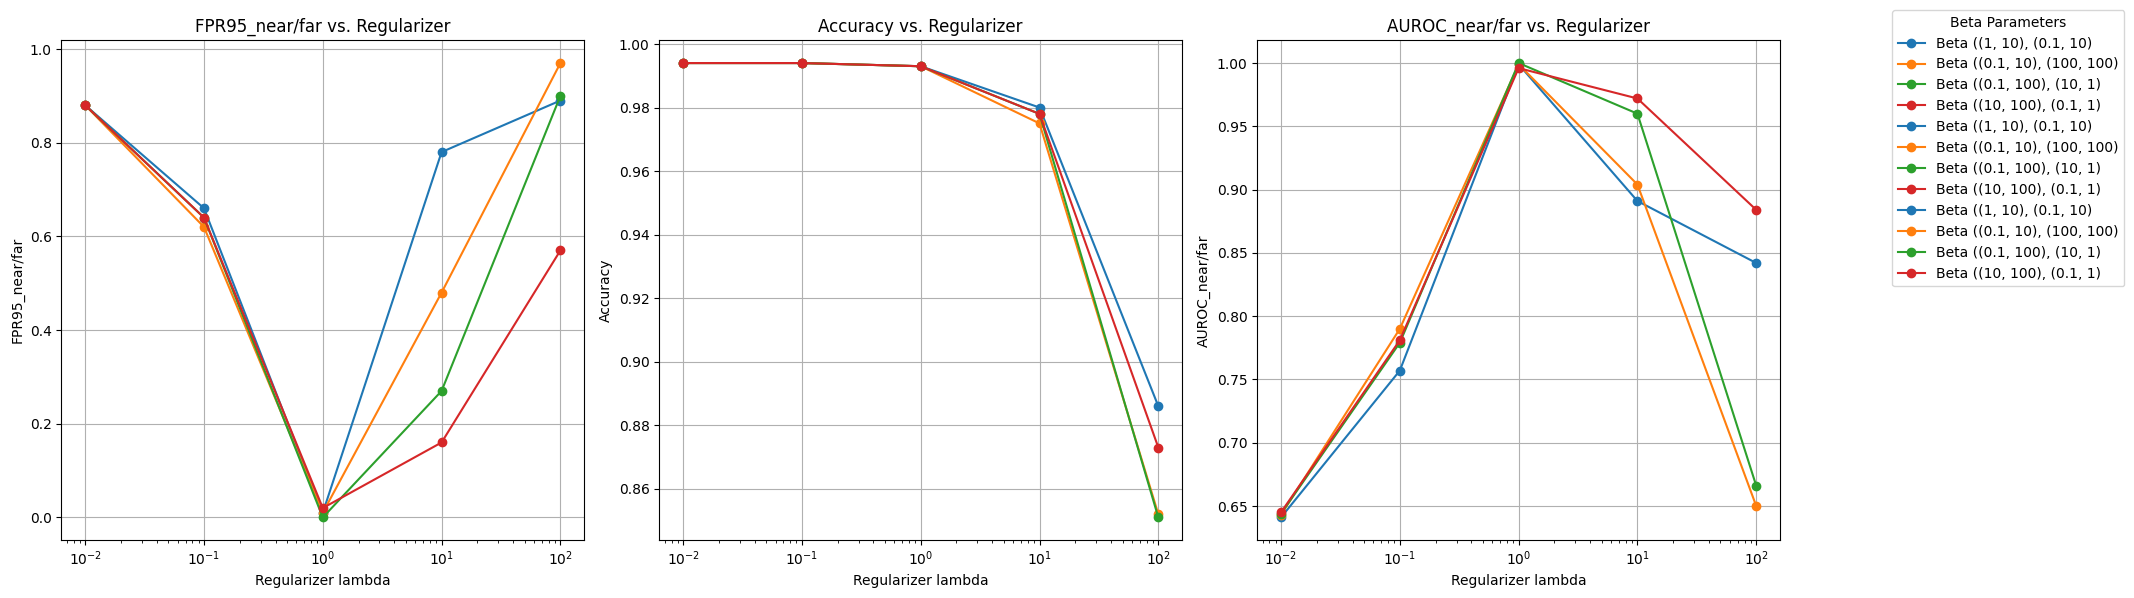

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

# Cargando datos desde un archivo Excel
df = pd.read_excel('/content/drive/MyDrive/tesis_2024/propuesta/params_study/regularizer_betas_v1.xlsx')

# Preparación para graficar
beta_params_unique = df['beta_params'].unique()

# Configurar el layout de los subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas

# Primer subplot para FPR95_near/far
for beta in beta_params_unique:
    subset = df[df['beta_params'] == beta].sort_values('regularizer')
    axs[0].plot(subset['regularizer'], subset['FPR95_near/far'], marker='o', label=f'Beta {beta}')
axs[0].set_title('FPR95_near/far vs. Regularizer')
axs[0].set_xlabel('Regularizer lambda')
axs[0].set_ylabel('FPR95_near/far')
axs[0].set_xscale('log')
axs[0].grid(True)

# Segundo subplot para accuracy
for beta in beta_params_unique:
    subset = df[df['beta_params'] == beta].sort_values('regularizer')
    axs[1].plot(subset['regularizer'], subset['acc'], marker='o', label=f'Beta {beta}')
axs[1].set_title('Accuracy vs. Regularizer')
axs[1].set_xlabel('Regularizer lambda')
axs[1].set_ylabel('Accuracy')
axs[1].set_xscale('log')
axs[1].grid(True)

# Tercer subplot para AUROC_near/far
for beta in beta_params_unique:
    subset = df[df['beta_params'] == beta].sort_values('regularizer')
    axs[2].plot(subset['regularizer'], subset['AUROC_near/far'], marker='o', label=f'Beta {beta}')
axs[2].set_title('AUROC_near/far vs. Regularizer')
axs[2].set_xlabel('Regularizer lambda')
axs[2].set_ylabel('AUROC_near/far')
axs[2].set_xscale('log')
axs[2].grid(True)

# Ajustar la leyenda y el layout
fig.legend(title='Beta Parameters', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

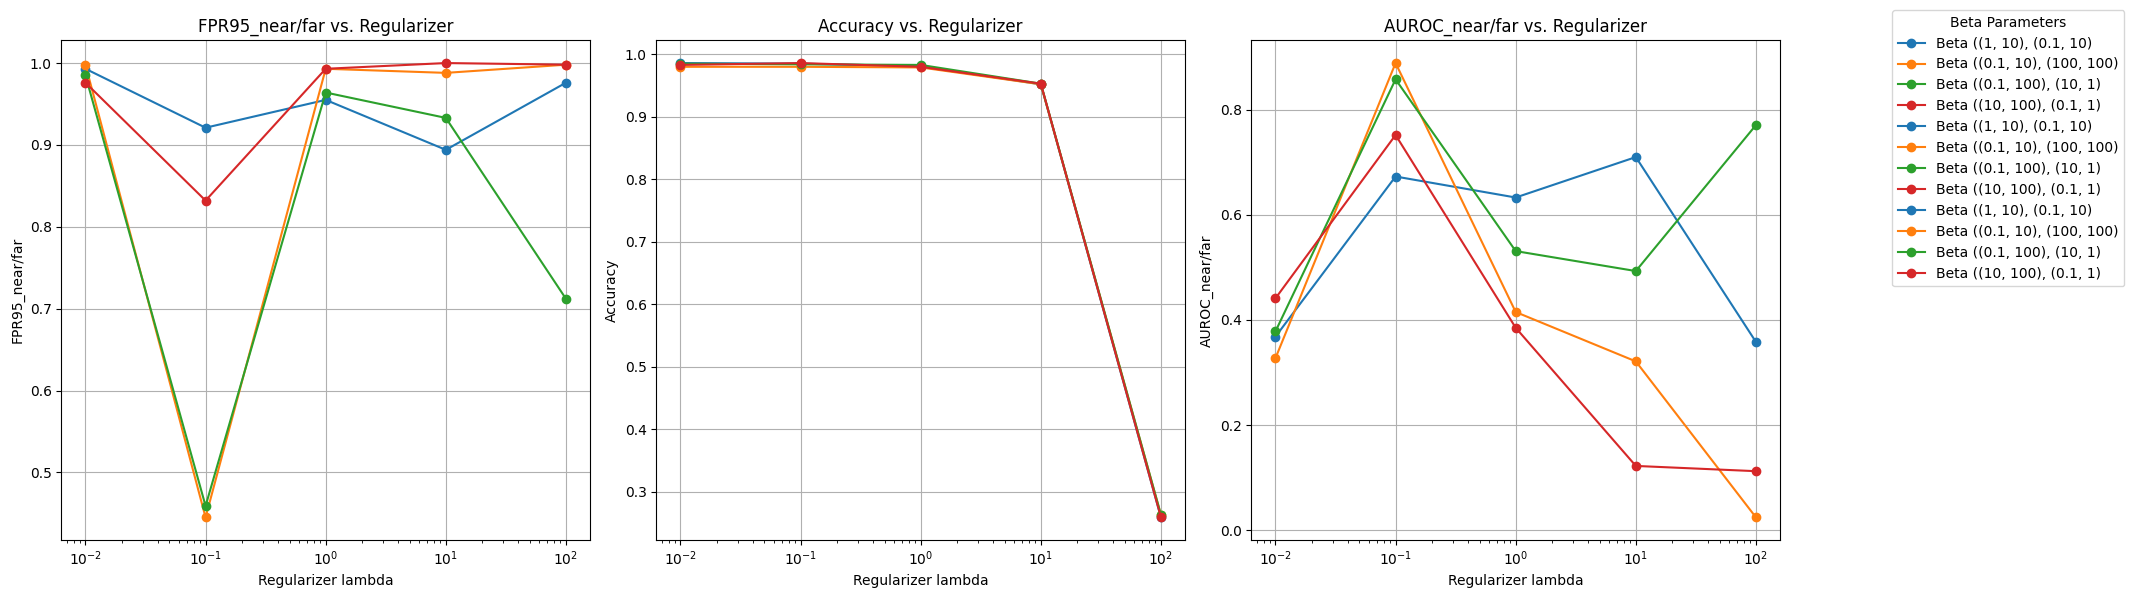

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

# Cargando datos desde un archivo Excel
df = pd.read_excel('/content/drive/MyDrive/tesis_2024/propuesta/params_study/regularizer_betas_v1.xlsx')

# Preparación para graficar
beta_params_unique = df['beta_params'].unique()

# Configurar el layout de los subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas

# Primer subplot para FPR95_near/far
for beta in beta_params_unique:
    subset = df[df['beta_params'] == beta].sort_values('regularizer')
    axs[0].plot(subset['regularizer'], subset['FPR95_near/far'], marker='o', label=f'Beta {beta}')
axs[0].set_title('FPR95_near/far vs. Regularizer')
axs[0].set_xlabel('Regularizer lambda')
axs[0].set_ylabel('FPR95_near/far')
axs[0].set_xscale('log')
axs[0].grid(True)

# Segundo subplot para accuracy
for beta in beta_params_unique:
    subset = df[df['beta_params'] == beta].sort_values('regularizer')
    axs[1].plot(subset['regularizer'], subset['acc'], marker='o', label=f'Beta {beta}')
axs[1].set_title('Accuracy vs. Regularizer')
axs[1].set_xlabel('Regularizer lambda')
axs[1].set_ylabel('Accuracy')
axs[1].set_xscale('log')
axs[1].grid(True)

# Tercer subplot para AUROC_near/far
for beta in beta_params_unique:
    subset = df[df['beta_params'] == beta].sort_values('regularizer')
    axs[2].plot(subset['regularizer'], subset['AUROC_near/far'], marker='o', label=f'Beta {beta}')
axs[2].set_title('AUROC_near/far vs. Regularizer')
axs[2].set_xlabel('Regularizer lambda')
axs[2].set_ylabel('AUROC_near/far')
axs[2].set_xscale('log')
axs[2].grid(True)

# Ajustar la leyenda y el layout
fig.legend(title='Beta Parameters', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt

# Cargando datos desde un archivo Excel
df = pd.read_excel('/content/drive/MyDrive/tesis_2024/propuesta/params_study/regularizer_betas_v2.xlsx')

# Preparación para graficar
beta_params_unique = df['beta_params'].unique()

# Configurar el layout de los subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 fila, 3 columnas

# Primer subplot para FPR95_near/far
for beta in beta_params_unique:
    subset = df[df['beta_params'] == beta].sort_values('regularizer')
    axs[0].plot(subset['regularizer'], subset['FPR95_near/far'], marker='o', label=f'Beta {beta}')
axs[0].set_title('FPR95_near/far vs. Regularizer')
axs[0].set_xlabel('Regularizer lambda')
axs[0].set_ylabel('FPR95_near/far')
axs[0].set_xscale('log')
axs[0].grid(True)

# Segundo subplot para accuracy
for beta in beta_params_unique:
    subset = df[df['beta_params'] == beta].sort_values('regularizer')
    axs[1].plot(subset['regularizer'], subset['acc'], marker='o', label=f'Beta {beta}')
axs[1].set_title('Accuracy vs. Regularizer')
axs[1].set_xlabel('Regularizer lambda')
axs[1].set_ylabel('Accuracy')
axs[1].set_xscale('log')
axs[1].grid(True)

# Tercer subplot para AUROC_near/far
for beta in beta_params_unique:
    subset = df[df['beta_params'] == beta].sort_values('regularizer')
    axs[2].plot(subset['regularizer'], subset['AUROC_near/far'], marker='o', label=f'Beta {beta}')
axs[2].set_title('AUROC_near/far vs. Regularizer')
axs[2].set_xlabel('Regularizer lambda')
axs[2].set_ylabel('AUROC_near/far')
axs[2].set_xscale('log')
axs[2].grid(True)

# Ajustar la leyenda y el layout
fig.legend(title='Beta Parameters', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

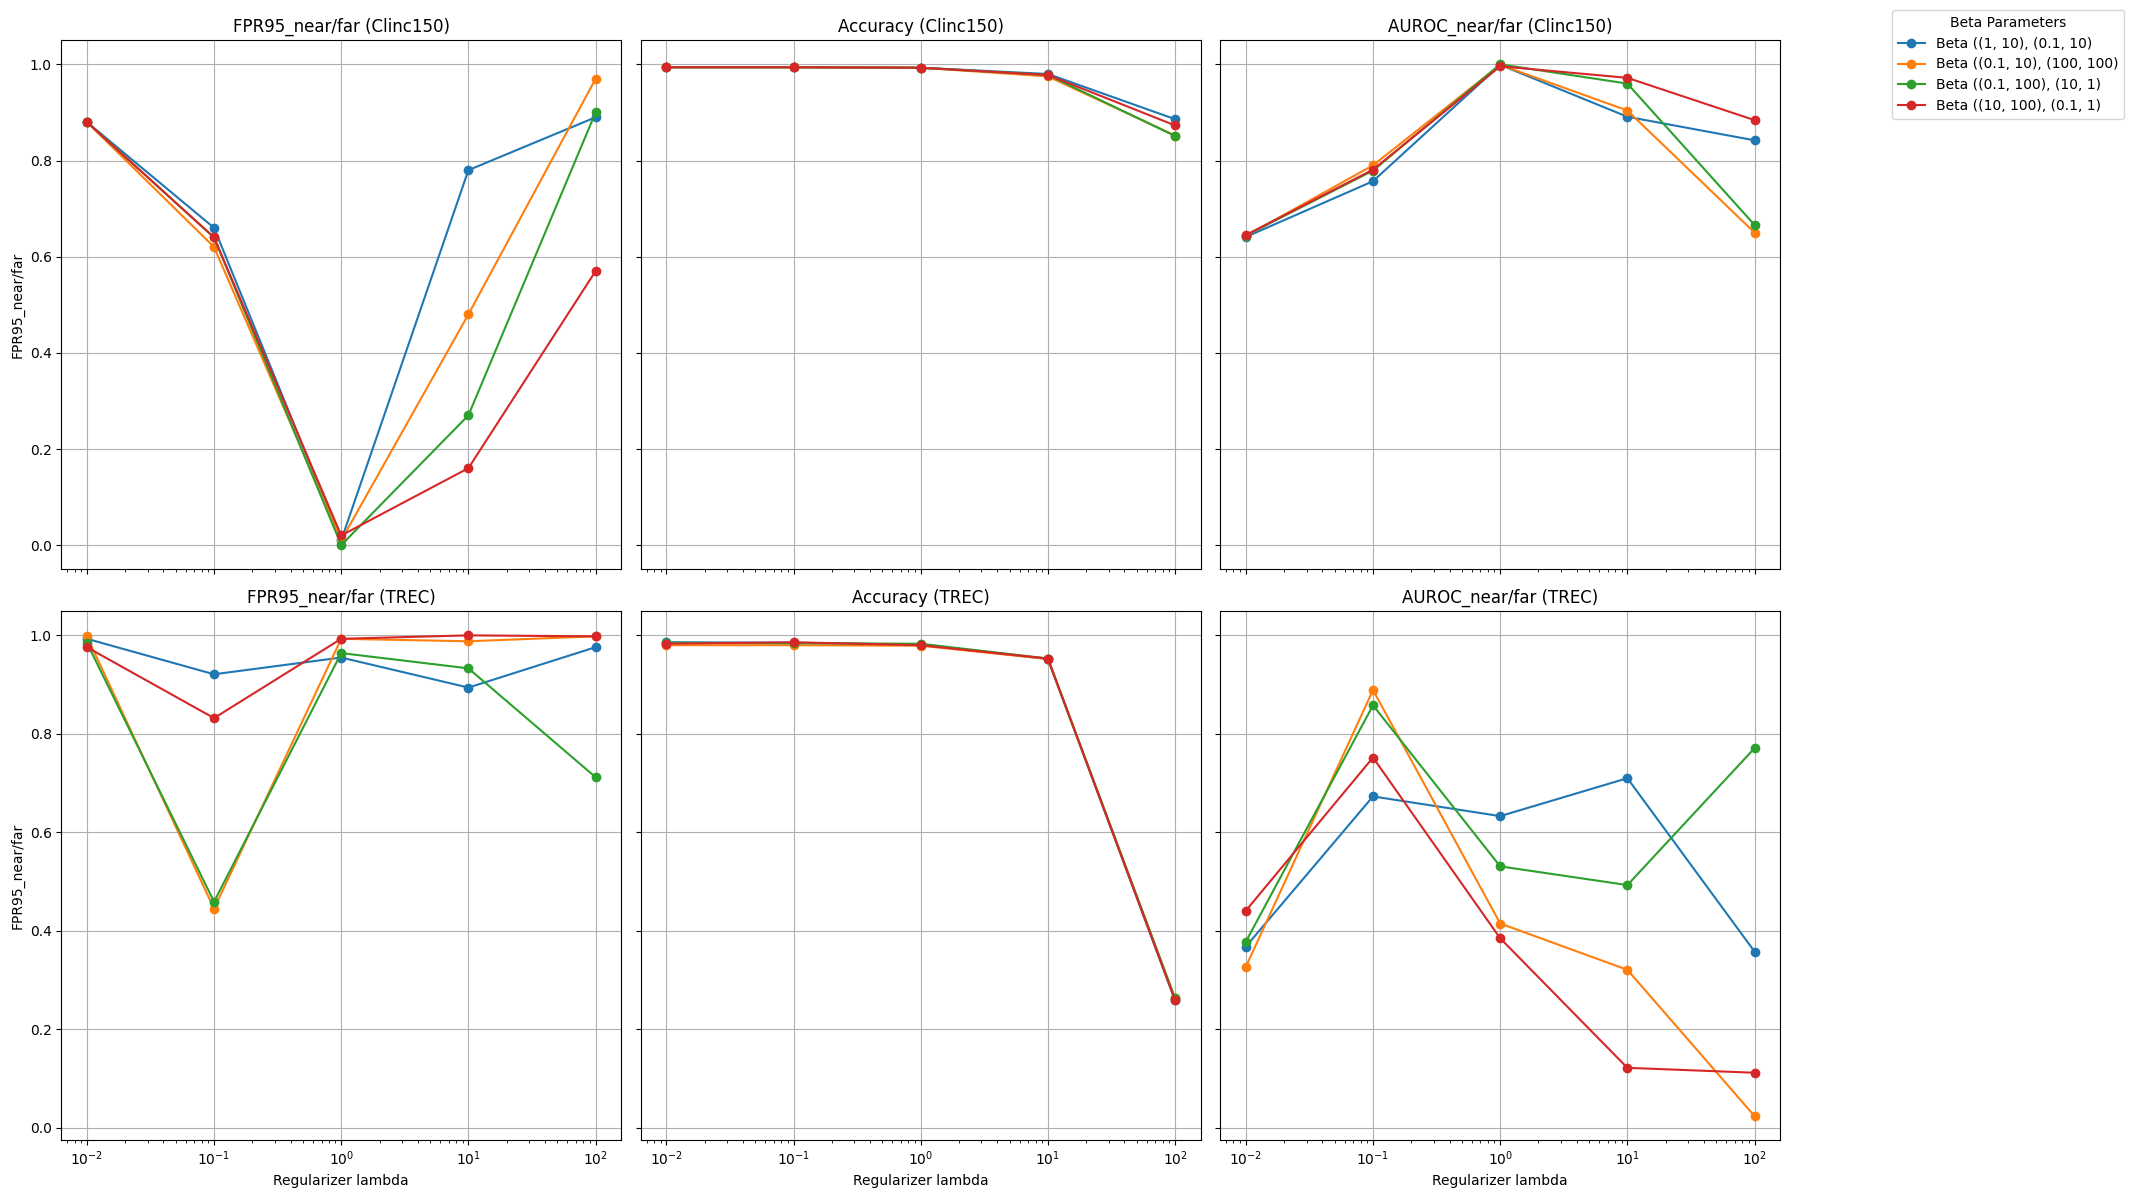

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos de ambos archivos Excel
df_clinc150 = pd.read_excel('/content/drive/MyDrive/tesis_2024/propuesta/params_study/regularizer_betas_v1.xlsx')
df_trec = pd.read_excel('/content/drive/MyDrive/tesis_2024/propuesta/params_study/regularizer_betas_v2.xlsx')

# Configurar el layout de los subplots (2 filas, 3 columnas)
fig, axs = plt.subplots(2, 3, figsize=(18, 12), sharex='col', sharey='row')  # Compartir eje X por columna y eje Y por fila

# Definir una función para trazar datos
def plot_data(ax, df, metric, title, xlabel=False, ylabel=False):
    beta_params_unique = df['beta_params'].unique()
    for beta in beta_params_unique:
        subset = df[df['beta_params'] == beta].sort_values('regularizer')
        ax.plot(subset['regularizer'], subset[metric], marker='o', label=f'Beta {beta}')
    if xlabel:
        ax.set_xlabel('Regularizer lambda')
    if ylabel:
        ax.set_ylabel(metric)
    ax.set_title(title)
    ax.set_xscale('log')
    ax.grid(True)

# Clinc150 data plotting
plot_data(axs[0, 0], df_clinc150, 'FPR95_near/far', 'FPR95_near/far (Clinc150)', ylabel=True)
plot_data(axs[0, 1], df_clinc150, 'acc', 'Accuracy (Clinc150)')
plot_data(axs[0, 2], df_clinc150, 'AUROC_near/far', 'AUROC_near/far (Clinc150)')

# TREC data plotting
plot_data(axs[1, 0], df_trec, 'FPR95_near/far', 'FPR95_near/far (TREC)', xlabel=True, ylabel=True)
plot_data(axs[1, 1], df_trec, 'acc', 'Accuracy (TREC)', xlabel=True)
plot_data(axs[1, 2], df_trec, 'AUROC_near/far', 'AUROC_near/far (TREC)', xlabel=True)

# Ajustar la leyenda y el layout globalmente
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, title='Beta Parameters', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/tesis_2024/paper/regularizer_betas.eps', format='eps')
plt.show()